<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/images/IDSNlogo.png" width="300" alt="cognitiveclass.ai logo"  />
</center>

<h1 align="center"><font size="5">Classification with Python</font></h1>


In this notebook we try to practice all the classification algorithms that we have learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Let's first load required libraries:


In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,roc_auc_score,classification_report,precision_score,recall_score,roc_curve,auc,accuracy_score,f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

### About dataset


This dataset is about past loans. The **Loan_train.csv** data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
| -------------- | ------------------------------------------------------------------------------------- |
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |


Let's download the dataset


In [3]:
!wget -O loan_train.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv

--2022-04-14 08:40:29--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.45.118.108
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.45.118.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0s      

2022-04-14 08:40:30 (203 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File


In [4]:
df = pd.read_csv('loan_train.csv')
df.head()

Unnamed: 0  Unnamed: 0.1 loan_status  Principal  terms effective_date  \
0           0             0     PAIDOFF       1000     30       9/8/2016   
1           2             2     PAIDOFF       1000     30       9/8/2016   
2           3             3     PAIDOFF       1000     15       9/8/2016   
3           4             4     PAIDOFF       1000     30       9/9/2016   
4           6             6     PAIDOFF       1000     30       9/9/2016   

    due_date  age             education  Gender  
0  10/7/2016   45  High School or Below    male  
1  10/7/2016   33              Bechalor  female  
2  9/22/2016   27               college    male  
3  10/8/2016   28               college  female  
4  10/8/2016   29               college    male

In [5]:
df.shape

(346, 10)

### Concise Summary

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346 entries, 0 to 345
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      346 non-null    int64 
 1   Unnamed: 0.1    346 non-null    int64 
 2   loan_status     346 non-null    object
 3   Principal       346 non-null    int64 
 4   terms           346 non-null    int64 
 5   effective_date  346 non-null    object
 6   due_date        346 non-null    object
 7   age             346 non-null    int64 
 8   education       346 non-null    object
 9   Gender          346 non-null    object
dtypes: int64(5), object(5)
memory usage: 27.2+ KB


loan_status,effective_date,due_date,education,Gender features are of object datatypes , they need to convert in appropriate data type such that effective_date and due_date features need to convert into datetime and rest need to convert into int 

### Convert to date time object


In [7]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

Unnamed: 0  Unnamed: 0.1 loan_status  Principal  terms effective_date  \
0           0             0     PAIDOFF       1000     30     2016-09-08   
1           2             2     PAIDOFF       1000     30     2016-09-08   
2           3             3     PAIDOFF       1000     15     2016-09-08   
3           4             4     PAIDOFF       1000     30     2016-09-09   
4           6             6     PAIDOFF       1000     30     2016-09-09   

    due_date  age             education  Gender  
0 2016-10-07   45  High School or Below    male  
1 2016-10-07   33              Bechalor  female  
2 2016-09-22   27               college    male  
3 2016-10-08   28               college  female  
4 2016-10-08   29               college    male

# Data visualization and pre-processing


Let’s see how many of each class is in our data set


In [8]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection


Let's plot some columns to underestand data better:


In [9]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Solving environment: done

# All requested packages already installed.



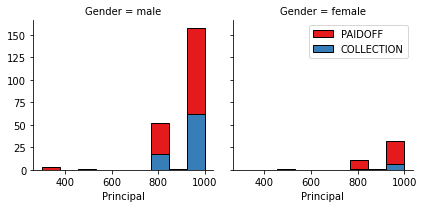

In [10]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

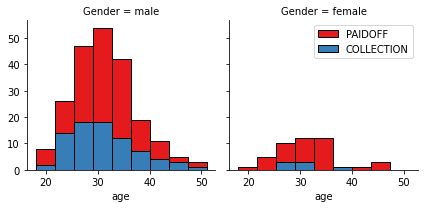

In [11]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction


### Let's look at the day of the week people get the loan


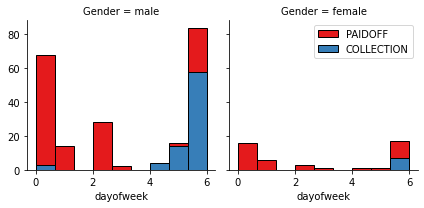

In [12]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week don't pay it off, so let's use Feature binarization to set a threshold value less than day 4


In [13]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

Unnamed: 0  Unnamed: 0.1 loan_status  Principal  terms effective_date  \
0           0             0     PAIDOFF       1000     30     2016-09-08   
1           2             2     PAIDOFF       1000     30     2016-09-08   
2           3             3     PAIDOFF       1000     15     2016-09-08   
3           4             4     PAIDOFF       1000     30     2016-09-09   
4           6             6     PAIDOFF       1000     30     2016-09-09   

    due_date  age             education  Gender  dayofweek  weekend  
0 2016-10-07   45  High School or Below    male          3        0  
1 2016-10-07   33              Bechalor  female          3        0  
2 2016-09-22   27               college    male          3        0  
3 2016-10-08   28               college  female          4        1  
4 2016-10-08   29               college    male          4        1

## Convert Categorical features to numerical values


Let's look at gender:


In [14]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64


86 % of female pay there loans while only 73 % of males pay there loan


Let's convert male to 0 and female to 1:


In [15]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

Unnamed: 0  Unnamed: 0.1 loan_status  Principal  terms effective_date  \
0           0             0     PAIDOFF       1000     30     2016-09-08   
1           2             2     PAIDOFF       1000     30     2016-09-08   
2           3             3     PAIDOFF       1000     15     2016-09-08   
3           4             4     PAIDOFF       1000     30     2016-09-09   
4           6             6     PAIDOFF       1000     30     2016-09-09   

    due_date  age             education  Gender  dayofweek  weekend  
0 2016-10-07   45  High School or Below       0          3        0  
1 2016-10-07   33              Bechalor       1          3        0  
2 2016-09-22   27               college       0          3        0  
3 2016-10-08   28               college       1          4        1  
4 2016-10-08   29               college       0          4        1

## One Hot Encoding

#### How about education?


In [16]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Features before One Label Encoding


In [17]:
df[['Principal','terms','age','Gender','education']].head()

Principal  terms  age  Gender             education
0       1000     30   45       0  High School or Below
1       1000     30   33       1              Bechalor
2       1000     15   27       0               college
3       1000     30   28       1               college
4       1000     30   29       0               college

#### Use one Label encoding technique to conver categorical varables to binary variables


In [18]:
le = LabelEncoder()

In [19]:
df['education'] = le.fit_transform(df['education'])

In [20]:
df['loan_status'] = le.fit_transform(df['loan_status'])

In [21]:
df['effective_date'] = le.fit_transform(df['effective_date'])

In [22]:
df['due_date'] = le.fit_transform(df['due_date'])

In [23]:
df.head()

Unnamed: 0  Unnamed: 0.1  loan_status  Principal  terms  effective_date  \
0           0             0            1       1000     30               0   
1           2             2            1       1000     30               0   
2           3             3            1       1000     15               0   
3           4             4            1       1000     30               1   
4           6             6            1       1000     30               1   

   due_date  age  education  Gender  dayofweek  weekend  
0        11   45          1       0          3        0  
1        11   33          0       1          3        0  
2         4   27          3       0          3        0  
3        12   28          3       1          4        1  
4        12   29          3       0          4        1

### Feature Selection


Let's define feature sets, X:


In [24]:
X = df.drop(df[['Unnamed: 0','Unnamed: 0.1','loan_status']],axis = 1)
X[0:5]

Principal  terms  effective_date  due_date  age  education  Gender  \
0       1000     30               0        11   45          1       0   
1       1000     30               0        11   33          0       1   
2       1000     15               0         4   27          3       0   
3       1000     30               1        12   28          3       1   
4       1000     30               1        12   29          3       0   

   dayofweek  weekend  
0          3        0  
1          3        0  
2          3        0  
3          4        1  
4          4        1

What are our lables?


In [25]:
y = df['loan_status']
y

0      1
1      1
2      1
3      1
4      1
      ..
341    0
342    0
343    0
344    0
345    0
Name: loan_status, Length: 346, dtype: int64

## Normalize Data


Data Standardization give data zero mean and unit variance (technically should be done after train test split)


In [26]:
sclar = preprocessing.StandardScaler()

In [27]:
X_sc = sclar.fit_transform(X)

In [28]:
X = pd.DataFrame(X_sc,columns=['Principal','terms','effective_date','due_date','age','education','Gender','dayofweek','weekend'])

In [29]:
X

Principal     terms  effective_date  due_date       age  education  \
0     0.515785  0.920718       -3.018614 -0.101253  2.331526  -0.646919   
1     0.515785  0.920718       -3.018614 -0.101253  0.341701  -1.521270   
2     0.515785 -0.959111       -3.018614 -1.714638 -0.653211   1.101783   
3     0.515785  0.920718       -2.149695  0.129231 -0.487392   1.101783   
4     0.515785  0.920718       -2.149695  0.129231 -0.321573   1.101783   
..         ...       ...             ...       ...       ...        ...   
341  -1.314589 -0.959111       -0.411858 -1.023187  0.175883  -0.646919   
342   0.515785  0.920718       -0.411858  0.590198 -0.984848  -0.646919   
343  -1.314589 -0.959111        0.457061 -0.792704  1.336614   1.101783   
344   0.515785  0.920718        0.457061  2.203583 -0.487392   1.101783   
345   0.515785  0.920718        0.457061  0.820681 -0.819029   1.101783   

       Gender  dayofweek   weekend  
0   -0.420560  -0.261221 -1.205778  
1    2.377782  -0.261221 -1.205778  
2   -0.420560  -0.261221 -1.205778  
3    2.377782   0.121755  0.829340  
4   -0.420560   0.121755  0.829340  
..        ...        ...       ...  
341 -0.420560   0.887707  0.829340  
342 -0.420560   0.887707  0.829340  
343 -0.420560  -1.410148 -1.205778  
344 -0.420560  -1.410148 -1.205778  
345 -0.420560  -1.410148 -1.205778  

[346 rows x 9 columns]

# Classification


Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:

*   K Nearest Neighbor(KNN)
*   Decision Tree
*   Support Vector Machine
*   Logistic Regression

\__ Notice:\__

*   You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
*   You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
*   You should include the code of the algorithm in the following cells.


# K Nearest Neighbor(KNN)

Notice: You should find the best k to build the model with the best accuracy.\
**warning:** You should not use the **loan_test.csv** for finding the best k, however, you can split your train_loan.csv into train and test to find the best **k**.


In [30]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [31]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((276, 9), (70, 9), (276,), (70,))

In [32]:
for i in range(1,21,2):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    print("For", i ,"Neighbours ")
    print("training accuracy",knn.score(X_train,y_train))
    print("Testing accuracy",knn.score(X_test,y_test))
    print("*******************************")

For 1 Neighbours 
training accuracy 0.9420289855072463
Testing accuracy 0.7285714285714285
*******************************
For 3 Neighbours 
training accuracy 0.8623188405797102
Testing accuracy 0.7142857142857143
*******************************
For 5 Neighbours 
training accuracy 0.8079710144927537
Testing accuracy 0.7
*******************************
For 7 Neighbours 
training accuracy 0.8079710144927537
Testing accuracy 0.6571428571428571
*******************************
For 9 Neighbours 
training accuracy 0.8115942028985508
Testing accuracy 0.6857142857142857
*******************************
For 11 Neighbours 
training accuracy 0.782608695652174
Testing accuracy 0.7285714285714285
*******************************
For 13 Neighbours 
training accuracy 0.8007246376811594
Testing accuracy 0.7428571428571429
*******************************
For 15 Neighbours 
training accuracy 0.7862318840579711
Testing accuracy 0.7142857142857143
*******************************
For 17 Neighbours 
training a

from above observation we can say that n_neighbours = 13 fits the best as Accuracy for training is 80% and testing is 74% as there is low baise and low variance ,but value of n neighbor 13 which is two high so lets perform parameter tunning 

In [33]:
knn = KNeighborsClassifier()

# Hyperparameter Optimization
parameters = {'n_neighbors': [1,3,5,7,9,11,13,15,17], 
              'weights': ['uniform', 'distance'],
              'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'leaf_size' : [10, 20, 30, 50],
              'p':[1,2]
             }

# Run the grid search
grid_obj = GridSearchCV(knn, parameters,cv=10,scoring= 'accuracy', n_jobs= -1, verbose= 3)

grid_obj


GridSearchCV(cv=10, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'leaf_size': [10, 20, 30, 50],
                         'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17],
                         'p': [1, 2], 'weights': ['uniform', 'distance']},
             scoring='accuracy', verbose=3)

In [34]:
grid_obj = grid_obj.fit(X_train, y_train)

# Set the knn to the best combination of parameters
knn = grid_obj.best_estimator_
knn


Fitting 10 folds for each of 576 candidates, totalling 5760 fits
[CV 1/10] END algorithm=auto, leaf_size=10, n_neighbors=1, p=1, weights=uniform;, score=0.750 total time=   0.0s
[CV 3/10] END algorithm=auto, leaf_size=10, n_neighbors=1, p=1, weights=uniform;, score=0.643 total time=   0.0s
[CV 4/10] END algorithm=auto, leaf_size=10, n_neighbors=1, p=1, weights=uniform;, score=0.750 total time=   0.0s
[CV 5/10] END algorithm=auto, leaf_size=10, n_neighbors=1, p=1, weights=uniform;, score=0.643 total time=   0.0s
[CV 6/10] END algorithm=auto, leaf_size=10, n_neighbors=1, p=1, weights=uniform;, score=0.643 total time=   0.0s
[CV 7/10] END algorithm=auto, leaf_size=10, n_neighbors=1, p=1, weights=uniform;, score=0.778 total time=   0.0s
[CV 8/10] END algorithm=auto, leaf_size=10, n_neighbors=1, p=1, weights=uniform;, score=0.741 total time=   0.0s
[CV 9/10] END algorithm=auto, leaf_size=10, n_neighbors=1, p=1, weights=uniform;, score=0.815 total time=   0.0s
[CV 10/10] END algorithm=auto, 

[CV 2/10] END algorithm=auto, leaf_size=10, n_neighbors=1, p=1, weights=uniform;, score=0.536 total time=   0.0s
[CV 7/10] END algorithm=auto, leaf_size=10, n_neighbors=3, p=1, weights=uniform;, score=0.741 total time=   0.0s
[CV 8/10] END algorithm=auto, leaf_size=10, n_neighbors=3, p=1, weights=uniform;, score=0.741 total time=   0.0s
[CV 9/10] END algorithm=auto, leaf_size=10, n_neighbors=3, p=1, weights=uniform;, score=0.778 total time=   0.0s
[CV 10/10] END algorithm=auto, leaf_size=10, n_neighbors=3, p=1, weights=uniform;, score=0.704 total time=   0.0s
[CV 1/10] END algorithm=auto, leaf_size=10, n_neighbors=3, p=1, weights=distance;, score=0.714 total time=   0.0s
[CV 2/10] END algorithm=auto, leaf_size=10, n_neighbors=3, p=1, weights=distance;, score=0.571 total time=   0.0s
[CV 3/10] END algorithm=auto, leaf_size=10, n_neighbors=3, p=1, weights=distance;, score=0.786 total time=   0.0s
[CV 4/10] END algorithm=auto, leaf_size=10, n_neighbors=3, p=1, weights=distance;, score=0.8

[CV 10/10] END algorithm=auto, leaf_size=10, n_neighbors=9, p=2, weights=uniform;, score=0.704 total time=   0.0s
[CV 1/10] END algorithm=auto, leaf_size=10, n_neighbors=9, p=2, weights=distance;, score=0.714 total time=   0.0s
[CV 2/10] END algorithm=auto, leaf_size=10, n_neighbors=9, p=2, weights=distance;, score=0.571 total time=   0.0s
[CV 3/10] END algorithm=auto, leaf_size=10, n_neighbors=9, p=2, weights=distance;, score=0.821 total time=   0.0s
[CV 4/10] END algorithm=auto, leaf_size=10, n_neighbors=9, p=2, weights=distance;, score=0.786 total time=   0.0s
[CV 5/10] END algorithm=auto, leaf_size=10, n_neighbors=9, p=2, weights=distance;, score=0.750 total time=   0.0s
[CV 6/10] END algorithm=auto, leaf_size=10, n_neighbors=9, p=2, weights=distance;, score=0.714 total time=   0.0s
[CV 7/10] END algorithm=auto, leaf_size=10, n_neighbors=9, p=2, weights=distance;, score=0.667 total time=   0.0s
[CV 8/10] END algorithm=auto, leaf_size=10, n_neighbors=9, p=2, weights=distance;, score

[CV 5/10] END algorithm=auto, leaf_size=10, n_neighbors=17, p=1, weights=uniform;, score=0.750 total time=   0.0s
[CV 6/10] END algorithm=auto, leaf_size=10, n_neighbors=17, p=1, weights=uniform;, score=0.679 total time=   0.0s
[CV 9/10] END algorithm=auto, leaf_size=10, n_neighbors=17, p=2, weights=distance;, score=0.815 total time=   0.0s
[CV 10/10] END algorithm=auto, leaf_size=10, n_neighbors=17, p=2, weights=distance;, score=0.630 total time=   0.0s
[CV 1/10] END algorithm=auto, leaf_size=20, n_neighbors=1, p=1, weights=uniform;, score=0.786 total time=   0.0s
[CV 2/10] END algorithm=auto, leaf_size=20, n_neighbors=1, p=1, weights=uniform;, score=0.536 total time=   0.0s
[CV 3/10] END algorithm=auto, leaf_size=20, n_neighbors=1, p=1, weights=uniform;, score=0.679 total time=   0.0s
[CV 4/10] END algorithm=auto, leaf_size=20, n_neighbors=1, p=1, weights=uniform;, score=0.750 total time=   0.0s
[CV 5/10] END algorithm=auto, leaf_size=20, n_neighbors=1, p=1, weights=uniform;, score=0

[CV 3/10] END algorithm=auto, leaf_size=20, n_neighbors=7, p=1, weights=distance;, score=0.786 total time=   0.0s
[CV 4/10] END algorithm=auto, leaf_size=20, n_neighbors=7, p=1, weights=distance;, score=0.786 total time=   0.0s
[CV 5/10] END algorithm=auto, leaf_size=20, n_neighbors=7, p=1, weights=distance;, score=0.679 total time=   0.0s
[CV 6/10] END algorithm=auto, leaf_size=20, n_neighbors=7, p=1, weights=distance;, score=0.750 total time=   0.0s
[CV 7/10] END algorithm=auto, leaf_size=20, n_neighbors=7, p=1, weights=distance;, score=0.704 total time=   0.0s
[CV 8/10] END algorithm=auto, leaf_size=20, n_neighbors=7, p=1, weights=distance;, score=0.778 total time=   0.0s
[CV 9/10] END algorithm=auto, leaf_size=20, n_neighbors=7, p=1, weights=distance;, score=0.815 total time=   0.0s
[CV 10/10] END algorithm=auto, leaf_size=20, n_neighbors=7, p=1, weights=distance;, score=0.593 total time=   0.0s
[CV 1/10] END algorithm=auto, leaf_size=20, n_neighbors=7, p=2, weights=uniform;, score

[CV 3/10] END algorithm=auto, leaf_size=20, n_neighbors=15, p=2, weights=uniform;, score=0.714 total time=   0.0s
[CV 4/10] END algorithm=auto, leaf_size=20, n_neighbors=15, p=2, weights=uniform;, score=0.750 total time=   0.0s
[CV 5/10] END algorithm=auto, leaf_size=20, n_neighbors=15, p=2, weights=uniform;, score=0.643 total time=   0.0s
[CV 6/10] END algorithm=auto, leaf_size=20, n_neighbors=15, p=2, weights=uniform;, score=0.750 total time=   0.0s
[CV 7/10] END algorithm=auto, leaf_size=20, n_neighbors=15, p=2, weights=uniform;, score=0.741 total time=   0.0s
[CV 8/10] END algorithm=auto, leaf_size=20, n_neighbors=15, p=2, weights=uniform;, score=0.778 total time=   0.0s
[CV 9/10] END algorithm=auto, leaf_size=20, n_neighbors=15, p=2, weights=uniform;, score=0.889 total time=   0.0s
[CV 10/10] END algorithm=auto, leaf_size=20, n_neighbors=15, p=2, weights=uniform;, score=0.704 total time=   0.0s
[CV 1/10] END algorithm=auto, leaf_size=20, n_neighbors=15, p=2, weights=distance;, sco

[CV 6/10] END algorithm=auto, leaf_size=30, n_neighbors=3, p=1, weights=uniform;, score=0.750 total time=   0.0s
[CV 7/10] END algorithm=auto, leaf_size=30, n_neighbors=3, p=1, weights=uniform;, score=0.778 total time=   0.0s
[CV 8/10] END algorithm=auto, leaf_size=30, n_neighbors=3, p=1, weights=uniform;, score=0.741 total time=   0.0s
[CV 9/10] END algorithm=auto, leaf_size=30, n_neighbors=3, p=1, weights=uniform;, score=0.778 total time=   0.0s
[CV 10/10] END algorithm=auto, leaf_size=30, n_neighbors=3, p=1, weights=uniform;, score=0.704 total time=   0.0s
[CV 1/10] END algorithm=auto, leaf_size=30, n_neighbors=3, p=1, weights=distance;, score=0.714 total time=   0.0s
[CV 2/10] END algorithm=auto, leaf_size=30, n_neighbors=3, p=1, weights=distance;, score=0.571 total time=   0.0s
[CV 3/10] END algorithm=auto, leaf_size=30, n_neighbors=3, p=1, weights=distance;, score=0.786 total time=   0.0s
[CV 4/10] END algorithm=auto, leaf_size=30, n_neighbors=3, p=1, weights=distance;, score=0.8

[CV 2/10] END algorithm=auto, leaf_size=30, n_neighbors=9, p=2, weights=uniform;, score=0.643 total time=   0.0s
[CV 5/10] END algorithm=auto, leaf_size=30, n_neighbors=11, p=1, weights=distance;, score=0.714 total time=   0.0s
[CV 6/10] END algorithm=auto, leaf_size=30, n_neighbors=11, p=1, weights=distance;, score=0.714 total time=   0.0s
[CV 7/10] END algorithm=auto, leaf_size=30, n_neighbors=11, p=1, weights=distance;, score=0.667 total time=   0.0s
[CV 8/10] END algorithm=auto, leaf_size=30, n_neighbors=11, p=1, weights=distance;, score=0.778 total time=   0.0s
[CV 9/10] END algorithm=auto, leaf_size=30, n_neighbors=11, p=1, weights=distance;, score=0.815 total time=   0.0s
[CV 10/10] END algorithm=auto, leaf_size=30, n_neighbors=11, p=1, weights=distance;, score=0.593 total time=   0.0s
[CV 1/10] END algorithm=auto, leaf_size=30, n_neighbors=11, p=2, weights=uniform;, score=0.750 total time=   0.0s
[CV 2/10] END algorithm=auto, leaf_size=30, n_neighbors=11, p=2, weights=uniform;,

[CV 9/10] END algorithm=auto, leaf_size=30, n_neighbors=17, p=2, weights=uniform;, score=0.889 total time=   0.0s
[CV 10/10] END algorithm=auto, leaf_size=30, n_neighbors=17, p=2, weights=uniform;, score=0.667 total time=   0.0s
[CV 1/10] END algorithm=auto, leaf_size=30, n_neighbors=17, p=2, weights=distance;, score=0.679 total time=   0.0s
[CV 2/10] END algorithm=auto, leaf_size=30, n_neighbors=17, p=2, weights=distance;, score=0.571 total time=   0.0s
[CV 3/10] END algorithm=auto, leaf_size=30, n_neighbors=17, p=2, weights=distance;, score=0.857 total time=   0.0s
[CV 4/10] END algorithm=auto, leaf_size=30, n_neighbors=17, p=2, weights=distance;, score=0.750 total time=   0.0s
[CV 5/10] END algorithm=auto, leaf_size=30, n_neighbors=17, p=2, weights=distance;, score=0.679 total time=   0.0s
[CV 6/10] END algorithm=auto, leaf_size=30, n_neighbors=17, p=2, weights=distance;, score=0.643 total time=   0.0s
[CV 7/10] END algorithm=auto, leaf_size=30, n_neighbors=17, p=2, weights=distance

[CV 6/10] END algorithm=auto, leaf_size=50, n_neighbors=9, p=2, weights=uniform;, score=0.750 total time=   0.0s
[CV 7/10] END algorithm=auto, leaf_size=50, n_neighbors=9, p=2, weights=uniform;, score=0.741 total time=   0.0s
[CV 8/10] END algorithm=auto, leaf_size=50, n_neighbors=9, p=2, weights=uniform;, score=0.778 total time=   0.0s
[CV 9/10] END algorithm=auto, leaf_size=50, n_neighbors=9, p=2, weights=uniform;, score=0.852 total time=   0.0s
[CV 10/10] END algorithm=auto, leaf_size=50, n_neighbors=9, p=2, weights=uniform;, score=0.704 total time=   0.0s
[CV 1/10] END algorithm=auto, leaf_size=50, n_neighbors=9, p=2, weights=distance;, score=0.714 total time=   0.0s
[CV 2/10] END algorithm=auto, leaf_size=50, n_neighbors=9, p=2, weights=distance;, score=0.571 total time=   0.0s
[CV 3/10] END algorithm=auto, leaf_size=50, n_neighbors=9, p=2, weights=distance;, score=0.821 total time=   0.0s
[CV 4/10] END algorithm=auto, leaf_size=50, n_neighbors=9, p=2, weights=distance;, score=0.7

[CV 3/10] END algorithm=ball_tree, leaf_size=10, n_neighbors=1, p=1, weights=uniform;, score=0.643 total time=   0.0s
[CV 4/10] END algorithm=ball_tree, leaf_size=10, n_neighbors=1, p=1, weights=uniform;, score=0.750 total time=   0.0s
[CV 5/10] END algorithm=ball_tree, leaf_size=10, n_neighbors=1, p=1, weights=uniform;, score=0.643 total time=   0.0s
[CV 6/10] END algorithm=ball_tree, leaf_size=10, n_neighbors=1, p=1, weights=uniform;, score=0.643 total time=   0.0s
[CV 9/10] END algorithm=ball_tree, leaf_size=10, n_neighbors=1, p=2, weights=distance;, score=0.815 total time=   0.0s
[CV 10/10] END algorithm=ball_tree, leaf_size=10, n_neighbors=1, p=2, weights=distance;, score=0.519 total time=   0.0s
[CV 1/10] END algorithm=ball_tree, leaf_size=10, n_neighbors=3, p=1, weights=uniform;, score=0.679 total time=   0.0s
[CV 2/10] END algorithm=ball_tree, leaf_size=10, n_neighbors=3, p=1, weights=uniform;, score=0.571 total time=   0.0s
[CV 3/10] END algorithm=ball_tree, leaf_size=10, n_ne

[CV 6/10] END algorithm=ball_tree, leaf_size=10, n_neighbors=7, p=1, weights=distance;, score=0.750 total time=   0.0s
[CV 7/10] END algorithm=ball_tree, leaf_size=10, n_neighbors=7, p=1, weights=distance;, score=0.704 total time=   0.0s
[CV 8/10] END algorithm=ball_tree, leaf_size=10, n_neighbors=7, p=1, weights=distance;, score=0.778 total time=   0.0s
[CV 9/10] END algorithm=ball_tree, leaf_size=10, n_neighbors=7, p=1, weights=distance;, score=0.815 total time=   0.0s
[CV 10/10] END algorithm=ball_tree, leaf_size=10, n_neighbors=7, p=1, weights=distance;, score=0.593 total time=   0.0s
[CV 1/10] END algorithm=ball_tree, leaf_size=10, n_neighbors=7, p=2, weights=uniform;, score=0.714 total time=   0.0s
[CV 2/10] END algorithm=ball_tree, leaf_size=10, n_neighbors=7, p=2, weights=uniform;, score=0.607 total time=   0.0s
[CV 3/10] END algorithm=ball_tree, leaf_size=10, n_neighbors=7, p=2, weights=uniform;, score=0.821 total time=   0.0s
[CV 4/10] END algorithm=ball_tree, leaf_size=10, n

[CV 8/10] END algorithm=ball_tree, leaf_size=10, n_neighbors=13, p=2, weights=uniform;, score=0.741 total time=   0.0s
[CV 9/10] END algorithm=ball_tree, leaf_size=10, n_neighbors=13, p=2, weights=uniform;, score=0.889 total time=   0.0s
[CV 10/10] END algorithm=ball_tree, leaf_size=10, n_neighbors=13, p=2, weights=uniform;, score=0.704 total time=   0.0s
[CV 1/10] END algorithm=ball_tree, leaf_size=10, n_neighbors=13, p=2, weights=distance;, score=0.714 total time=   0.0s
[CV 2/10] END algorithm=ball_tree, leaf_size=10, n_neighbors=13, p=2, weights=distance;, score=0.571 total time=   0.0s
[CV 3/10] END algorithm=ball_tree, leaf_size=10, n_neighbors=13, p=2, weights=distance;, score=0.821 total time=   0.0s
[CV 4/10] END algorithm=ball_tree, leaf_size=10, n_neighbors=13, p=2, weights=distance;, score=0.750 total time=   0.0s
[CV 5/10] END algorithm=ball_tree, leaf_size=10, n_neighbors=13, p=2, weights=distance;, score=0.679 total time=   0.0s
[CV 6/10] END algorithm=ball_tree, leaf_si

[CV 10/10] END algorithm=ball_tree, leaf_size=20, n_neighbors=1, p=2, weights=distance;, score=0.593 total time=   0.0s
[CV 1/10] END algorithm=ball_tree, leaf_size=20, n_neighbors=3, p=1, weights=uniform;, score=0.679 total time=   0.0s
[CV 2/10] END algorithm=ball_tree, leaf_size=20, n_neighbors=3, p=1, weights=uniform;, score=0.571 total time=   0.0s
[CV 3/10] END algorithm=ball_tree, leaf_size=20, n_neighbors=3, p=1, weights=uniform;, score=0.821 total time=   0.0s
[CV 4/10] END algorithm=ball_tree, leaf_size=20, n_neighbors=3, p=1, weights=uniform;, score=0.786 total time=   0.0s
[CV 5/10] END algorithm=ball_tree, leaf_size=20, n_neighbors=3, p=1, weights=uniform;, score=0.714 total time=   0.0s
[CV 6/10] END algorithm=ball_tree, leaf_size=20, n_neighbors=3, p=1, weights=uniform;, score=0.750 total time=   0.0s
[CV 7/10] END algorithm=ball_tree, leaf_size=20, n_neighbors=3, p=1, weights=uniform;, score=0.778 total time=   0.0s
[CV 8/10] END algorithm=ball_tree, leaf_size=20, n_nei

[CV 7/10] END algorithm=ball_tree, leaf_size=20, n_neighbors=11, p=2, weights=uniform;, score=0.778 total time=   0.0s
[CV 8/10] END algorithm=ball_tree, leaf_size=20, n_neighbors=11, p=2, weights=uniform;, score=0.741 total time=   0.0s
[CV 9/10] END algorithm=ball_tree, leaf_size=20, n_neighbors=11, p=2, weights=uniform;, score=0.852 total time=   0.0s
[CV 10/10] END algorithm=ball_tree, leaf_size=20, n_neighbors=11, p=2, weights=uniform;, score=0.667 total time=   0.0s
[CV 1/10] END algorithm=ball_tree, leaf_size=20, n_neighbors=11, p=2, weights=distance;, score=0.714 total time=   0.0s
[CV 2/10] END algorithm=ball_tree, leaf_size=20, n_neighbors=11, p=2, weights=distance;, score=0.571 total time=   0.0s
[CV 3/10] END algorithm=ball_tree, leaf_size=20, n_neighbors=11, p=2, weights=distance;, score=0.821 total time=   0.0s
[CV 4/10] END algorithm=ball_tree, leaf_size=20, n_neighbors=11, p=2, weights=distance;, score=0.786 total time=   0.0s
[CV 5/10] END algorithm=ball_tree, leaf_siz

[CV 9/10] END algorithm=ball_tree, leaf_size=20, n_neighbors=17, p=2, weights=distance;, score=0.815 total time=   0.0s
[CV 10/10] END algorithm=ball_tree, leaf_size=20, n_neighbors=17, p=2, weights=distance;, score=0.630 total time=   0.0s
[CV 1/10] END algorithm=ball_tree, leaf_size=30, n_neighbors=1, p=1, weights=uniform;, score=0.786 total time=   0.0s
[CV 2/10] END algorithm=ball_tree, leaf_size=30, n_neighbors=1, p=1, weights=uniform;, score=0.536 total time=   0.0s
[CV 3/10] END algorithm=ball_tree, leaf_size=30, n_neighbors=1, p=1, weights=uniform;, score=0.679 total time=   0.0s
[CV 4/10] END algorithm=ball_tree, leaf_size=30, n_neighbors=1, p=1, weights=uniform;, score=0.750 total time=   0.0s
[CV 5/10] END algorithm=ball_tree, leaf_size=30, n_neighbors=1, p=1, weights=uniform;, score=0.679 total time=   0.0s
[CV 6/10] END algorithm=ball_tree, leaf_size=30, n_neighbors=1, p=1, weights=uniform;, score=0.643 total time=   0.0s
[CV 7/10] END algorithm=ball_tree, leaf_size=30, n_

[CV 2/10] END algorithm=ball_tree, leaf_size=30, n_neighbors=7, p=1, weights=distance;, score=0.607 total time=   0.0s
[CV 3/10] END algorithm=ball_tree, leaf_size=30, n_neighbors=7, p=1, weights=distance;, score=0.786 total time=   0.0s
[CV 4/10] END algorithm=ball_tree, leaf_size=30, n_neighbors=7, p=1, weights=distance;, score=0.786 total time=   0.0s
[CV 5/10] END algorithm=ball_tree, leaf_size=30, n_neighbors=7, p=1, weights=distance;, score=0.679 total time=   0.0s
[CV 6/10] END algorithm=ball_tree, leaf_size=30, n_neighbors=7, p=1, weights=distance;, score=0.750 total time=   0.0s
[CV 7/10] END algorithm=ball_tree, leaf_size=30, n_neighbors=7, p=1, weights=distance;, score=0.704 total time=   0.0s
[CV 8/10] END algorithm=ball_tree, leaf_size=30, n_neighbors=7, p=1, weights=distance;, score=0.778 total time=   0.0s
[CV 9/10] END algorithm=ball_tree, leaf_size=30, n_neighbors=7, p=1, weights=distance;, score=0.815 total time=   0.0s
[CV 10/10] END algorithm=ball_tree, leaf_size=30

[CV 8/10] END algorithm=ball_tree, leaf_size=30, n_neighbors=13, p=2, weights=distance;, score=0.778 total time=   0.0s
[CV 1/10] END algorithm=ball_tree, leaf_size=30, n_neighbors=15, p=2, weights=distance;, score=0.714 total time=   0.0s
[CV 2/10] END algorithm=ball_tree, leaf_size=30, n_neighbors=15, p=2, weights=distance;, score=0.607 total time=   0.0s
[CV 3/10] END algorithm=ball_tree, leaf_size=30, n_neighbors=15, p=2, weights=distance;, score=0.857 total time=   0.0s
[CV 4/10] END algorithm=ball_tree, leaf_size=30, n_neighbors=15, p=2, weights=distance;, score=0.750 total time=   0.0s
[CV 5/10] END algorithm=ball_tree, leaf_size=30, n_neighbors=15, p=2, weights=distance;, score=0.679 total time=   0.0s
[CV 6/10] END algorithm=ball_tree, leaf_size=30, n_neighbors=15, p=2, weights=distance;, score=0.643 total time=   0.0s
[CV 7/10] END algorithm=ball_tree, leaf_size=30, n_neighbors=15, p=2, weights=distance;, score=0.667 total time=   0.0s
[CV 8/10] END algorithm=ball_tree, leaf_

[CV 2/10] END algorithm=ball_tree, leaf_size=50, n_neighbors=5, p=1, weights=uniform;, score=0.500 total time=   0.0s
[CV 3/10] END algorithm=ball_tree, leaf_size=50, n_neighbors=5, p=1, weights=uniform;, score=0.786 total time=   0.0s
[CV 4/10] END algorithm=ball_tree, leaf_size=50, n_neighbors=5, p=1, weights=uniform;, score=0.821 total time=   0.0s
[CV 5/10] END algorithm=ball_tree, leaf_size=50, n_neighbors=5, p=1, weights=uniform;, score=0.714 total time=   0.0s
[CV 6/10] END algorithm=ball_tree, leaf_size=50, n_neighbors=5, p=1, weights=uniform;, score=0.786 total time=   0.0s
[CV 7/10] END algorithm=ball_tree, leaf_size=50, n_neighbors=5, p=1, weights=uniform;, score=0.815 total time=   0.0s
[CV 8/10] END algorithm=ball_tree, leaf_size=50, n_neighbors=5, p=1, weights=uniform;, score=0.741 total time=   0.0s
[CV 9/10] END algorithm=ball_tree, leaf_size=50, n_neighbors=5, p=1, weights=uniform;, score=0.852 total time=   0.0s
[CV 10/10] END algorithm=ball_tree, leaf_size=50, n_neig

[CV 10/10] END algorithm=ball_tree, leaf_size=50, n_neighbors=9, p=2, weights=distance;, score=0.630 total time=   0.0s[CV 5/10] END algorithm=ball_tree, leaf_size=50, n_neighbors=11, p=1, weights=distance;, score=0.679 total time=   0.0s
[CV 6/10] END algorithm=ball_tree, leaf_size=50, n_neighbors=11, p=1, weights=distance;, score=0.714 total time=   0.0s
[CV 7/10] END algorithm=ball_tree, leaf_size=50, n_neighbors=11, p=1, weights=distance;, score=0.667 total time=   0.0s
[CV 8/10] END algorithm=ball_tree, leaf_size=50, n_neighbors=11, p=1, weights=distance;, score=0.778 total time=   0.0s
[CV 9/10] END algorithm=ball_tree, leaf_size=50, n_neighbors=11, p=1, weights=distance;, score=0.815 total time=   0.0s
[CV 10/10] END algorithm=ball_tree, leaf_size=50, n_neighbors=11, p=1, weights=distance;, score=0.593 total time=   0.0s
[CV 1/10] END algorithm=ball_tree, leaf_size=50, n_neighbors=11, p=2, weights=uniform;, score=0.750 total time=   0.0s
[CV 2/10] END algorithm=ball_tree, leaf_s

[CV 5/10] END algorithm=ball_tree, leaf_size=50, n_neighbors=15, p=2, weights=distance;, score=0.679 total time=   0.0s
[CV 6/10] END algorithm=ball_tree, leaf_size=50, n_neighbors=15, p=2, weights=distance;, score=0.643 total time=   0.0s
[CV 7/10] END algorithm=ball_tree, leaf_size=50, n_neighbors=15, p=2, weights=distance;, score=0.704 total time=   0.0s
[CV 8/10] END algorithm=ball_tree, leaf_size=50, n_neighbors=15, p=2, weights=distance;, score=0.778 total time=   0.0s
[CV 9/10] END algorithm=ball_tree, leaf_size=50, n_neighbors=15, p=2, weights=distance;, score=0.815 total time=   0.0s
[CV 10/10] END algorithm=ball_tree, leaf_size=50, n_neighbors=15, p=2, weights=distance;, score=0.593 total time=   0.0s
[CV 1/10] END algorithm=ball_tree, leaf_size=50, n_neighbors=17, p=1, weights=uniform;, score=0.750 total time=   0.0s
[CV 2/10] END algorithm=ball_tree, leaf_size=50, n_neighbors=17, p=1, weights=uniform;, score=0.607 total time=   0.0s
[CV 3/10] END algorithm=ball_tree, leaf_s

[CV 8/10] END algorithm=kd_tree, leaf_size=10, n_neighbors=5, p=1, weights=uniform;, score=0.704 total time=   0.0s
[CV 9/10] END algorithm=kd_tree, leaf_size=10, n_neighbors=5, p=1, weights=uniform;, score=0.852 total time=   0.0s
[CV 10/10] END algorithm=kd_tree, leaf_size=10, n_neighbors=5, p=1, weights=uniform;, score=0.667 total time=   0.0s
[CV 1/10] END algorithm=kd_tree, leaf_size=10, n_neighbors=5, p=1, weights=distance;, score=0.643 total time=   0.0s
[CV 2/10] END algorithm=kd_tree, leaf_size=10, n_neighbors=5, p=1, weights=distance;, score=0.571 total time=   0.0s
[CV 3/10] END algorithm=kd_tree, leaf_size=10, n_neighbors=5, p=1, weights=distance;, score=0.750 total time=   0.0s
[CV 4/10] END algorithm=kd_tree, leaf_size=10, n_neighbors=5, p=1, weights=distance;, score=0.821 total time=   0.0s
[CV 5/10] END algorithm=kd_tree, leaf_size=10, n_neighbors=5, p=1, weights=distance;, score=0.679 total time=   0.0s
[CV 6/10] END algorithm=kd_tree, leaf_size=10, n_neighbors=5, p=1,

[CV 2/10] END algorithm=kd_tree, leaf_size=10, n_neighbors=11, p=2, weights=uniform;, score=0.571 total time=   0.0s
[CV 3/10] END algorithm=kd_tree, leaf_size=10, n_neighbors=11, p=2, weights=uniform;, score=0.857 total time=   0.0s
[CV 4/10] END algorithm=kd_tree, leaf_size=10, n_neighbors=11, p=2, weights=uniform;, score=0.786 total time=   0.0s
[CV 5/10] END algorithm=kd_tree, leaf_size=10, n_neighbors=11, p=2, weights=uniform;, score=0.750 total time=   0.0s
[CV 6/10] END algorithm=kd_tree, leaf_size=10, n_neighbors=11, p=2, weights=uniform;, score=0.750 total time=   0.0s
[CV 7/10] END algorithm=kd_tree, leaf_size=10, n_neighbors=11, p=2, weights=uniform;, score=0.778 total time=   0.0s
[CV 8/10] END algorithm=kd_tree, leaf_size=10, n_neighbors=11, p=2, weights=uniform;, score=0.741 total time=   0.0s
[CV 9/10] END algorithm=kd_tree, leaf_size=10, n_neighbors=11, p=2, weights=uniform;, score=0.852 total time=   0.0s
[CV 10/10] END algorithm=kd_tree, leaf_size=10, n_neighbors=11, 

[CV 5/10] END algorithm=kd_tree, leaf_size=10, n_neighbors=17, p=2, weights=distance;, score=0.679 total time=   0.0s
[CV 6/10] END algorithm=kd_tree, leaf_size=10, n_neighbors=17, p=2, weights=distance;, score=0.643 total time=   0.0s
[CV 7/10] END algorithm=kd_tree, leaf_size=10, n_neighbors=17, p=2, weights=distance;, score=0.667 total time=   0.0s
[CV 8/10] END algorithm=kd_tree, leaf_size=10, n_neighbors=17, p=2, weights=distance;, score=0.741 total time=   0.0s
[CV 1/10] END algorithm=kd_tree, leaf_size=20, n_neighbors=1, p=2, weights=distance;, score=0.714 total time=   0.0s
[CV 2/10] END algorithm=kd_tree, leaf_size=20, n_neighbors=1, p=2, weights=distance;, score=0.536 total time=   0.0s
[CV 3/10] END algorithm=kd_tree, leaf_size=20, n_neighbors=1, p=2, weights=distance;, score=0.714 total time=   0.0s
[CV 4/10] END algorithm=kd_tree, leaf_size=20, n_neighbors=1, p=2, weights=distance;, score=0.750 total time=   0.0s
[CV 5/10] END algorithm=kd_tree, leaf_size=20, n_neighbors=1

[CV 2/10] END algorithm=kd_tree, leaf_size=20, n_neighbors=11, p=1, weights=distance;, score=0.571 total time=   0.0s
[CV 3/10] END algorithm=kd_tree, leaf_size=20, n_neighbors=11, p=1, weights=distance;, score=0.821 total time=   0.0s
[CV 4/10] END algorithm=kd_tree, leaf_size=20, n_neighbors=11, p=1, weights=distance;, score=0.750 total time=   0.0s
[CV 5/10] END algorithm=kd_tree, leaf_size=20, n_neighbors=11, p=1, weights=distance;, score=0.714 total time=   0.0s
[CV 6/10] END algorithm=kd_tree, leaf_size=20, n_neighbors=11, p=1, weights=distance;, score=0.714 total time=   0.0s
[CV 7/10] END algorithm=kd_tree, leaf_size=20, n_neighbors=11, p=1, weights=distance;, score=0.667 total time=   0.0s
[CV 8/10] END algorithm=kd_tree, leaf_size=20, n_neighbors=11, p=1, weights=distance;, score=0.778 total time=   0.0s
[CV 9/10] END algorithm=kd_tree, leaf_size=20, n_neighbors=11, p=1, weights=distance;, score=0.815 total time=   0.0s
[CV 10/10] END algorithm=kd_tree, leaf_size=20, n_neighb

[CV 5/10] END algorithm=kd_tree, leaf_size=20, n_neighbors=17, p=2, weights=uniform;, score=0.643 total time=   0.0s
[CV 6/10] END algorithm=kd_tree, leaf_size=20, n_neighbors=17, p=2, weights=uniform;, score=0.607 total time=   0.0s
[CV 7/10] END algorithm=kd_tree, leaf_size=20, n_neighbors=17, p=2, weights=uniform;, score=0.778 total time=   0.0s
[CV 8/10] END algorithm=kd_tree, leaf_size=20, n_neighbors=17, p=2, weights=uniform;, score=0.815 total time=   0.0s
[CV 9/10] END algorithm=kd_tree, leaf_size=20, n_neighbors=17, p=2, weights=uniform;, score=0.889 total time=   0.0s
[CV 10/10] END algorithm=kd_tree, leaf_size=20, n_neighbors=17, p=2, weights=uniform;, score=0.667 total time=   0.0s
[CV 3/10] END algorithm=kd_tree, leaf_size=30, n_neighbors=1, p=2, weights=uniform;, score=0.714 total time=   0.0s
[CV 4/10] END algorithm=kd_tree, leaf_size=30, n_neighbors=1, p=2, weights=uniform;, score=0.750 total time=   0.0s
[CV 5/10] END algorithm=kd_tree, leaf_size=30, n_neighbors=1, p=2

[CV 1/10] END algorithm=kd_tree, leaf_size=30, n_neighbors=7, p=2, weights=distance;, score=0.679 total time=   0.0s
[CV 2/10] END algorithm=kd_tree, leaf_size=30, n_neighbors=7, p=2, weights=distance;, score=0.571 total time=   0.0s
[CV 3/10] END algorithm=kd_tree, leaf_size=30, n_neighbors=7, p=2, weights=distance;, score=0.821 total time=   0.0s
[CV 4/10] END algorithm=kd_tree, leaf_size=30, n_neighbors=7, p=2, weights=distance;, score=0.750 total time=   0.0s
[CV 5/10] END algorithm=kd_tree, leaf_size=30, n_neighbors=7, p=2, weights=distance;, score=0.786 total time=   0.0s
[CV 6/10] END algorithm=kd_tree, leaf_size=30, n_neighbors=7, p=2, weights=distance;, score=0.714 total time=   0.0s
[CV 7/10] END algorithm=kd_tree, leaf_size=30, n_neighbors=7, p=2, weights=distance;, score=0.667 total time=   0.0s
[CV 8/10] END algorithm=kd_tree, leaf_size=30, n_neighbors=7, p=2, weights=distance;, score=0.778 total time=   0.0s
[CV 9/10] END algorithm=kd_tree, leaf_size=30, n_neighbors=7, p=

[CV 4/10] END algorithm=kd_tree, leaf_size=30, n_neighbors=15, p=1, weights=uniform;, score=0.750 total time=   0.0s
[CV 5/10] END algorithm=kd_tree, leaf_size=30, n_neighbors=15, p=1, weights=uniform;, score=0.643 total time=   0.0s
[CV 6/10] END algorithm=kd_tree, leaf_size=30, n_neighbors=15, p=1, weights=uniform;, score=0.679 total time=   0.0s
[CV 7/10] END algorithm=kd_tree, leaf_size=30, n_neighbors=15, p=1, weights=uniform;, score=0.704 total time=   0.0s
[CV 8/10] END algorithm=kd_tree, leaf_size=30, n_neighbors=15, p=1, weights=uniform;, score=0.778 total time=   0.0s
[CV 9/10] END algorithm=kd_tree, leaf_size=30, n_neighbors=15, p=1, weights=uniform;, score=0.852 total time=   0.0s
[CV 10/10] END algorithm=kd_tree, leaf_size=30, n_neighbors=15, p=1, weights=uniform;, score=0.667 total time=   0.0s
[CV 1/10] END algorithm=kd_tree, leaf_size=30, n_neighbors=15, p=1, weights=distance;, score=0.679 total time=   0.0s
[CV 2/10] END algorithm=kd_tree, leaf_size=30, n_neighbors=15,

[CV 7/10] END algorithm=kd_tree, leaf_size=50, n_neighbors=3, p=1, weights=distance;, score=0.630 total time=   0.0s
[CV 8/10] END algorithm=kd_tree, leaf_size=50, n_neighbors=3, p=1, weights=distance;, score=0.778 total time=   0.0s
[CV 9/10] END algorithm=kd_tree, leaf_size=50, n_neighbors=3, p=1, weights=distance;, score=0.815 total time=   0.0s
[CV 10/10] END algorithm=kd_tree, leaf_size=50, n_neighbors=3, p=1, weights=distance;, score=0.630 total time=   0.0s
[CV 1/10] END algorithm=kd_tree, leaf_size=50, n_neighbors=3, p=2, weights=uniform;, score=0.679 total time=   0.0s
[CV 2/10] END algorithm=kd_tree, leaf_size=50, n_neighbors=3, p=2, weights=uniform;, score=0.500 total time=   0.0s
[CV 3/10] END algorithm=kd_tree, leaf_size=50, n_neighbors=3, p=2, weights=uniform;, score=0.857 total time=   0.0s
[CV 4/10] END algorithm=kd_tree, leaf_size=50, n_neighbors=3, p=2, weights=uniform;, score=0.714 total time=   0.0s
[CV 5/10] END algorithm=kd_tree, leaf_size=50, n_neighbors=3, p=2, 

[CV 1/10] END algorithm=kd_tree, leaf_size=50, n_neighbors=9, p=2, weights=distance;, score=0.714 total time=   0.0s
[CV 2/10] END algorithm=kd_tree, leaf_size=50, n_neighbors=9, p=2, weights=distance;, score=0.571 total time=   0.0s
[CV 3/10] END algorithm=kd_tree, leaf_size=50, n_neighbors=9, p=2, weights=distance;, score=0.821 total time=   0.0s
[CV 4/10] END algorithm=kd_tree, leaf_size=50, n_neighbors=9, p=2, weights=distance;, score=0.786 total time=   0.0s
[CV 5/10] END algorithm=kd_tree, leaf_size=50, n_neighbors=9, p=2, weights=distance;, score=0.750 total time=   0.0s
[CV 6/10] END algorithm=kd_tree, leaf_size=50, n_neighbors=9, p=2, weights=distance;, score=0.714 total time=   0.0s
[CV 7/10] END algorithm=kd_tree, leaf_size=50, n_neighbors=9, p=2, weights=distance;, score=0.667 total time=   0.0s
[CV 8/10] END algorithm=kd_tree, leaf_size=50, n_neighbors=9, p=2, weights=distance;, score=0.778 total time=   0.0s
[CV 9/10] END algorithm=kd_tree, leaf_size=50, n_neighbors=9, p=

[CV 4/10] END algorithm=brute, leaf_size=10, n_neighbors=1, p=1, weights=distance;, score=0.750 total time=   0.0s[CV 4/10] END algorithm=kd_tree, leaf_size=50, n_neighbors=17, p=1, weights=uniform;, score=0.750 total time=   0.0s
[CV 5/10] END algorithm=kd_tree, leaf_size=50, n_neighbors=17, p=1, weights=uniform;, score=0.750 total time=   0.0s
[CV 6/10] END algorithm=kd_tree, leaf_size=50, n_neighbors=17, p=1, weights=uniform;, score=0.679 total time=   0.0s
[CV 7/10] END algorithm=kd_tree, leaf_size=50, n_neighbors=17, p=1, weights=uniform;, score=0.741 total time=   0.0s
[CV 8/10] END algorithm=kd_tree, leaf_size=50, n_neighbors=17, p=1, weights=uniform;, score=0.741 total time=   0.0s
[CV 9/10] END algorithm=kd_tree, leaf_size=50, n_neighbors=17, p=1, weights=uniform;, score=0.889 total time=   0.0s
[CV 10/10] END algorithm=kd_tree, leaf_size=50, n_neighbors=17, p=1, weights=uniform;, score=0.704 total time=   0.0s
[CV 1/10] END algorithm=kd_tree, leaf_size=50, n_neighbors=17, p=1

[CV 1/10] END algorithm=brute, leaf_size=10, n_neighbors=7, p=1, weights=distance;, score=0.643 total time=   0.0s
[CV 2/10] END algorithm=brute, leaf_size=10, n_neighbors=7, p=1, weights=distance;, score=0.607 total time=   0.0s
[CV 3/10] END algorithm=brute, leaf_size=10, n_neighbors=7, p=1, weights=distance;, score=0.786 total time=   0.0s
[CV 4/10] END algorithm=brute, leaf_size=10, n_neighbors=7, p=1, weights=distance;, score=0.786 total time=   0.0s
[CV 7/10] END algorithm=brute, leaf_size=10, n_neighbors=9, p=1, weights=uniform;, score=0.704 total time=   0.0s
[CV 8/10] END algorithm=brute, leaf_size=10, n_neighbors=9, p=1, weights=uniform;, score=0.704 total time=   0.0s
[CV 9/10] END algorithm=brute, leaf_size=10, n_neighbors=9, p=1, weights=uniform;, score=0.815 total time=   0.0s
[CV 10/10] END algorithm=brute, leaf_size=10, n_neighbors=9, p=1, weights=uniform;, score=0.704 total time=   0.0s
[CV 1/10] END algorithm=brute, leaf_size=10, n_neighbors=9, p=1, weights=distance;,

[CV 8/10] END algorithm=brute, leaf_size=10, n_neighbors=15, p=1, weights=distance;, score=0.778 total time=   0.0s
[CV 9/10] END algorithm=brute, leaf_size=10, n_neighbors=15, p=1, weights=distance;, score=0.815 total time=   0.0s
[CV 10/10] END algorithm=brute, leaf_size=10, n_neighbors=15, p=1, weights=distance;, score=0.593 total time=   0.0s
[CV 1/10] END algorithm=brute, leaf_size=10, n_neighbors=15, p=2, weights=uniform;, score=0.750 total time=   0.0s
[CV 2/10] END algorithm=brute, leaf_size=10, n_neighbors=15, p=2, weights=uniform;, score=0.643 total time=   0.0s
[CV 3/10] END algorithm=brute, leaf_size=10, n_neighbors=15, p=2, weights=uniform;, score=0.714 total time=   0.0s
[CV 4/10] END algorithm=brute, leaf_size=10, n_neighbors=15, p=2, weights=uniform;, score=0.750 total time=   0.0s
[CV 5/10] END algorithm=brute, leaf_size=10, n_neighbors=15, p=2, weights=uniform;, score=0.643 total time=   0.0s
[CV 6/10] END algorithm=brute, leaf_size=10, n_neighbors=15, p=2, weights=un

[CV 3/10] END algorithm=brute, leaf_size=20, n_neighbors=3, p=2, weights=distance;, score=0.821 total time=   0.0s
[CV 4/10] END algorithm=brute, leaf_size=20, n_neighbors=3, p=2, weights=distance;, score=0.786 total time=   0.0s
[CV 5/10] END algorithm=brute, leaf_size=20, n_neighbors=3, p=2, weights=distance;, score=0.750 total time=   0.0s
[CV 6/10] END algorithm=brute, leaf_size=20, n_neighbors=3, p=2, weights=distance;, score=0.714 total time=   0.0s
[CV 7/10] END algorithm=brute, leaf_size=20, n_neighbors=3, p=2, weights=distance;, score=0.630 total time=   0.0s
[CV 8/10] END algorithm=brute, leaf_size=20, n_neighbors=3, p=2, weights=distance;, score=0.778 total time=   0.0s
[CV 9/10] END algorithm=brute, leaf_size=20, n_neighbors=3, p=2, weights=distance;, score=0.815 total time=   0.0s
[CV 10/10] END algorithm=brute, leaf_size=20, n_neighbors=3, p=2, weights=distance;, score=0.556 total time=   0.0s
[CV 1/10] END algorithm=brute, leaf_size=20, n_neighbors=5, p=1, weights=unifor

[CV 7/10] END algorithm=brute, leaf_size=20, n_neighbors=11, p=2, weights=uniform;, score=0.741 total time=   0.0s
[CV 8/10] END algorithm=brute, leaf_size=20, n_neighbors=11, p=2, weights=uniform;, score=0.741 total time=   0.0s
[CV 9/10] END algorithm=brute, leaf_size=20, n_neighbors=11, p=2, weights=uniform;, score=0.852 total time=   0.0s
[CV 10/10] END algorithm=brute, leaf_size=20, n_neighbors=11, p=2, weights=uniform;, score=0.667 total time=   0.0s
[CV 1/10] END algorithm=brute, leaf_size=20, n_neighbors=11, p=2, weights=distance;, score=0.714 total time=   0.0s
[CV 2/10] END algorithm=brute, leaf_size=20, n_neighbors=11, p=2, weights=distance;, score=0.571 total time=   0.0s
[CV 3/10] END algorithm=brute, leaf_size=20, n_neighbors=11, p=2, weights=distance;, score=0.821 total time=   0.0s
[CV 4/10] END algorithm=brute, leaf_size=20, n_neighbors=11, p=2, weights=distance;, score=0.786 total time=   0.0s
[CV 5/10] END algorithm=brute, leaf_size=20, n_neighbors=11, p=2, weights=d

[CV 1/10] END algorithm=brute, leaf_size=30, n_neighbors=1, p=1, weights=uniform;, score=0.786 total time=   0.0s
[CV 2/10] END algorithm=brute, leaf_size=30, n_neighbors=1, p=1, weights=uniform;, score=0.571 total time=   0.0s
[CV 3/10] END algorithm=brute, leaf_size=30, n_neighbors=1, p=1, weights=uniform;, score=0.679 total time=   0.0s
[CV 4/10] END algorithm=brute, leaf_size=30, n_neighbors=1, p=1, weights=uniform;, score=0.750 total time=   0.0s
[CV 5/10] END algorithm=brute, leaf_size=30, n_neighbors=1, p=1, weights=uniform;, score=0.643 total time=   0.0s
[CV 6/10] END algorithm=brute, leaf_size=30, n_neighbors=1, p=1, weights=uniform;, score=0.643 total time=   0.0s
[CV 7/10] END algorithm=brute, leaf_size=30, n_neighbors=1, p=1, weights=uniform;, score=0.741 total time=   0.0s
[CV 8/10] END algorithm=brute, leaf_size=30, n_neighbors=1, p=1, weights=uniform;, score=0.741 total time=   0.0s
[CV 9/10] END algorithm=brute, leaf_size=30, n_neighbors=1, p=1, weights=uniform;, score

[CV 6/10] END algorithm=brute, leaf_size=30, n_neighbors=7, p=1, weights=distance;, score=0.750 total time=   0.0s
[CV 7/10] END algorithm=brute, leaf_size=30, n_neighbors=7, p=1, weights=distance;, score=0.704 total time=   0.0s
[CV 8/10] END algorithm=brute, leaf_size=30, n_neighbors=7, p=1, weights=distance;, score=0.778 total time=   0.0s
[CV 9/10] END algorithm=brute, leaf_size=30, n_neighbors=7, p=1, weights=distance;, score=0.815 total time=   0.0s
[CV 10/10] END algorithm=brute, leaf_size=30, n_neighbors=7, p=1, weights=distance;, score=0.593 total time=   0.0s
[CV 1/10] END algorithm=brute, leaf_size=30, n_neighbors=7, p=2, weights=uniform;, score=0.714 total time=   0.0s
[CV 2/10] END algorithm=brute, leaf_size=30, n_neighbors=7, p=2, weights=uniform;, score=0.607 total time=   0.0s
[CV 3/10] END algorithm=brute, leaf_size=30, n_neighbors=7, p=2, weights=uniform;, score=0.893 total time=   0.0s
[CV 4/10] END algorithm=brute, leaf_size=30, n_neighbors=7, p=2, weights=uniform;,

[CV 9/10] END algorithm=brute, leaf_size=30, n_neighbors=11, p=2, weights=distance;, score=0.852 total time=   0.0s
[CV 10/10] END algorithm=brute, leaf_size=30, n_neighbors=11, p=2, weights=distance;, score=0.593 total time=   0.0s
[CV 1/10] END algorithm=brute, leaf_size=30, n_neighbors=13, p=1, weights=uniform;, score=0.750 total time=   0.0s
[CV 2/10] END algorithm=brute, leaf_size=30, n_neighbors=13, p=1, weights=uniform;, score=0.607 total time=   0.0s
[CV 3/10] END algorithm=brute, leaf_size=30, n_neighbors=13, p=1, weights=uniform;, score=0.821 total time=   0.0s
[CV 4/10] END algorithm=brute, leaf_size=30, n_neighbors=13, p=1, weights=uniform;, score=0.750 total time=   0.0s
[CV 5/10] END algorithm=brute, leaf_size=30, n_neighbors=13, p=1, weights=uniform;, score=0.750 total time=   0.0s
[CV 6/10] END algorithm=brute, leaf_size=30, n_neighbors=13, p=1, weights=uniform;, score=0.679 total time=   0.0s
[CV 1/10] END algorithm=brute, leaf_size=30, n_neighbors=15, p=2, weights=dis

[CV 3/10] END algorithm=brute, leaf_size=50, n_neighbors=1, p=1, weights=distance;, score=0.679 total time=   0.0s
[CV 4/10] END algorithm=brute, leaf_size=50, n_neighbors=1, p=1, weights=distance;, score=0.750 total time=   0.0s
[CV 7/10] END algorithm=brute, leaf_size=50, n_neighbors=3, p=1, weights=uniform;, score=0.778 total time=   0.0s
[CV 8/10] END algorithm=brute, leaf_size=50, n_neighbors=3, p=1, weights=uniform;, score=0.741 total time=   0.0s
[CV 9/10] END algorithm=brute, leaf_size=50, n_neighbors=3, p=1, weights=uniform;, score=0.778 total time=   0.0s
[CV 10/10] END algorithm=brute, leaf_size=50, n_neighbors=3, p=1, weights=uniform;, score=0.704 total time=   0.0s
[CV 1/10] END algorithm=brute, leaf_size=50, n_neighbors=3, p=1, weights=distance;, score=0.714 total time=   0.0s
[CV 2/10] END algorithm=brute, leaf_size=50, n_neighbors=3, p=1, weights=distance;, score=0.571 total time=   0.0s
[CV 3/10] END algorithm=brute, leaf_size=50, n_neighbors=3, p=1, weights=distance;,

[CV 10/10] END algorithm=brute, leaf_size=50, n_neighbors=9, p=1, weights=distance;, score=0.593 total time=   0.0s
[CV 1/10] END algorithm=brute, leaf_size=50, n_neighbors=9, p=2, weights=uniform;, score=0.786 total time=   0.0s
[CV 2/10] END algorithm=brute, leaf_size=50, n_neighbors=9, p=2, weights=uniform;, score=0.607 total time=   0.0s
[CV 3/10] END algorithm=brute, leaf_size=50, n_neighbors=9, p=2, weights=uniform;, score=0.857 total time=   0.0s
[CV 4/10] END algorithm=brute, leaf_size=50, n_neighbors=9, p=2, weights=uniform;, score=0.786 total time=   0.0s
[CV 5/10] END algorithm=brute, leaf_size=50, n_neighbors=9, p=2, weights=uniform;, score=0.714 total time=   0.0s
[CV 6/10] END algorithm=brute, leaf_size=50, n_neighbors=9, p=2, weights=uniform;, score=0.750 total time=   0.0s
[CV 7/10] END algorithm=brute, leaf_size=50, n_neighbors=9, p=2, weights=uniform;, score=0.741 total time=   0.0s
[CV 8/10] END algorithm=brute, leaf_size=50, n_neighbors=9, p=2, weights=uniform;, sco

KNeighborsClassifier(algorithm='brute', leaf_size=10, n_neighbors=7)

In [35]:
# Train the model using the training sets 
#KNeighborsClassifier(algorithm='brute', leaf_size=10, n_neighbors=7)
knn.fit(X_train,y_train)
y_pred_knn_test = knn.predict(X_test)
y_pred_knn_train = knn.predict(X_train)

In [36]:
print("Checking for training Dataset")
Accuracy_trainknn=metrics.accuracy_score(y_train,y_pred_knn_train)
precision_trainknn=metrics.precision_score(y_train,y_pred_knn_train)
recall_trainknn=metrics.recall_score(y_train,y_pred_knn_train)
f1_score_trainknn=metrics.f1_score(y_train,y_pred_knn_train)
roc_auc_trainknn=metrics.roc_auc_score(y_train,y_pred_knn_train)
print("Model Name =",'K Nearest Neighbor' )
print("Accuracy is =",Accuracy_trainknn)
print("Precision score is =",precision_trainknn)
print("Recall score = ",recall_trainknn)
print("f1 SCore score is = ",f1_score_trainknn)
print("Roc_Auc score is= ",roc_auc_trainknn)

Checking for training Dataset
Model Name = K Nearest Neighbor
Accuracy is = 0.7971014492753623
Precision score is = 0.8333333333333334
Recall score =  0.9068627450980392
f1 SCore score is =  0.8685446009389671
Roc_Auc score is=  0.6964869281045751


In [37]:
print("For Checking on Training Dataset")
print('Confusion Matrix\n',confusion_matrix(y_pred_knn_train,y_train))
print("****************************************")
print('Classification Report\n',classification_report(y_pred_knn_train,y_train))
print("****************************************")
print('Accuracy Score\n',accuracy_score(y_pred_knn_train,y_train))

For Checking on Training Dataset
Confusion Matrix
 [[ 35  19]
 [ 37 185]]
****************************************
Classification Report
               precision    recall  f1-score   support

           0       0.49      0.65      0.56        54
           1       0.91      0.83      0.87       222

    accuracy                           0.80       276
   macro avg       0.70      0.74      0.71       276
weighted avg       0.82      0.80      0.81       276

****************************************
Accuracy Score
 0.7971014492753623


In [38]:
print("For Checking on Testing Dataset")
Accuracy_testknn=metrics.accuracy_score(y_test,y_pred_knn_test)
precision_testknn=metrics.precision_score(y_test,y_pred_knn_test)
recall_testknn=metrics.recall_score(y_test,y_pred_knn_test)
f1_score_testknn=metrics.f1_score(y_test,y_pred_knn_test)
roc_auc_testknn=metrics.roc_auc_score(y_test,y_pred_knn_test)

print("Model Name =",'K Nearest Neighbor')
print("Accuracy is ",Accuracy_testknn)
print("Precision score is ",precision_testknn)
print("Recall _score is",recall_testknn)
print("f1 SCore score is ",f1_score_testknn)
print("Roc_Auc score is",roc_auc_testknn)

For Checking on Testing Dataset
Model Name = K Nearest Neighbor
Accuracy is  0.7
Precision score is  0.7966101694915254
Recall _score is 0.8392857142857143
f1 SCore score is  0.8173913043478261
Roc_Auc score is 0.4910714285714286


In [39]:
print('Confusion Matrix\n',confusion_matrix(y_pred_knn_test,y_test))
print("****************************************")
print('Classification Report\n',classification_report(y_pred_knn_test,y_test))
print("****************************************")
print('Accuracy Score\n',accuracy_score(y_pred_knn_test,y_test))

Confusion Matrix
 [[ 2  9]
 [12 47]]
****************************************
Classification Report
               precision    recall  f1-score   support

           0       0.14      0.18      0.16        11
           1       0.84      0.80      0.82        59

    accuracy                           0.70        70
   macro avg       0.49      0.49      0.49        70
weighted avg       0.73      0.70      0.71        70

****************************************
Accuracy Score
 0.7


here Training Accuracy is 79% and Testing Accuracy is 70% with 7 neighbours

# Decision Tree


In [40]:
### Build Decision Tree model with default parameter
DT = DecisionTreeClassifier()
DT.fit(X_train,y_train)
print("training accuracy",DT.score(X_train,y_train))
print("Testing accuracy",DT.score(X_test,y_test))

training accuracy 0.9492753623188406
Testing accuracy 0.6714285714285714


Here Training Accuracy is 94% and Testing Accuracy is 67% for default parameter which is leading to overfitting as there is low baise and high variance 
so lets perform paramater tunning 

In [41]:
DTT = DecisionTreeClassifier()
# Hyperparameter Optimization
parameters = {'max_features': ['log2', 'sqrt','auto'], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [2, 3, 5, 10, 50], 
              'min_samples_split': [2, 3, 50, 100],
              'min_samples_leaf': [1, 5, 8, 10],
              'splitter':['best',"random"],
            'random_state':[10,51,42,101]
             }

# Run the grid search
grid_obj = GridSearchCV(DTT, parameters,cv=10,scoring= 'accuracy', n_jobs= -1, verbose=3)

grid_obj = grid_obj.fit(X_train, y_train)

Fitting 10 folds for each of 3840 candidates, totalling 38400 fits
[CV 6/10] END algorithm=brute, leaf_size=50, n_neighbors=11, p=2, weights=uniform;, score=0.750 total time=   0.0s
[CV 7/10] END algorithm=brute, leaf_size=50, n_neighbors=11, p=2, weights=uniform;, score=0.741 total time=   0.0s
[CV 8/10] END algorithm=brute, leaf_size=50, n_neighbors=11, p=2, weights=uniform;, score=0.741 total time=   0.0s
[CV 9/10] END algorithm=brute, leaf_size=50, n_neighbors=11, p=2, weights=uniform;, score=0.852 total time=   0.0s
[CV 10/10] END algorithm=brute, leaf_size=50, n_neighbors=11, p=2, weights=uniform;, score=0.667 total time=   0.0s
[CV 1/10] END algorithm=brute, leaf_size=50, n_neighbors=11, p=2, weights=distance;, score=0.714 total time=   0.0s
[CV 2/10] END algorithm=brute, leaf_size=50, n_neighbors=11, p=2, weights=distance;, score=0.571 total time=   0.0s
[CV 3/10] END algorithm=brute, leaf_size=50, n_neighbors=11, p=2, weights=distance;, score=0.821 total time=   0.0s
[CV 4/10]

[CV 7/10] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, random_state=10, splitter=best;, score=0.741 total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, random_state=10, splitter=best;, score=0.741 total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, random_state=10, splitter=best;, score=0.741 total time=   0.0s
[CV 10/10] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, random_state=10, splitter=best;, score=0.741 total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, random_state=10, splitter=random;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, random_state=10, splitter=random;, score=

[CV 6/10] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=3, random_state=10, splitter=random;, score=0.714 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=3, random_state=10, splitter=random;, score=0.741 total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=3, random_state=10, splitter=random;, score=0.741 total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=3, random_state=10, splitter=random;, score=0.741 total time=   0.0s
[CV 10/10] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=3, random_state=10, splitter=random;, score=0.741 total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=3, random_state=51, splitter=best;, 

[CV 2/10] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=100, random_state=10, splitter=random;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=100, random_state=42, splitter=best;, score=0.714 total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=100, random_state=42, splitter=best;, score=0.714 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=100, random_state=42, splitter=best;, score=0.741 total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=100, random_state=42, splitter=best;, score=0.741 total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=100, random_state=42, splitter=best

[CV 1/10] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=2, random_state=101, splitter=best;, score=0.750 total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=2, random_state=101, splitter=best;, score=0.536 total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=2, random_state=101, splitter=best;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=2, random_state=101, splitter=best;, score=0.714 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=2, random_state=101, splitter=best;, score=0.571 total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=2, random_state=101, splitter=best;, score

[CV 2/10] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=3, random_state=42, splitter=best;, score=0.750 total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=3, random_state=42, splitter=best;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=3, random_state=42, splitter=best;, score=0.750 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=3, random_state=101, splitter=random;, score=0.741 total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=3, random_state=101, splitter=random;, score=0.741 total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=3, random_state=101, splitter=random;, sc

[CV 3/10] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=50, random_state=101, splitter=random;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=50, random_state=101, splitter=random;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=50, random_state=101, splitter=random;, score=0.714 total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=50, random_state=101, splitter=random;, score=0.714 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=50, random_state=101, splitter=random;, score=0.741 total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=50, random_state=101, split

[CV 4/10] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=2, random_state=51, splitter=best;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=2, random_state=51, splitter=best;, score=0.750 total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=2, random_state=51, splitter=best;, score=0.714 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=2, random_state=51, splitter=best;, score=0.741 total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=2, random_state=51, splitter=best;, score=0.778 total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=2, random_state=101, splitter=best;, score=0.75

[CV 8/10] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=50, random_state=10, splitter=best;, score=0.741 total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=50, random_state=10, splitter=best;, score=0.741 total time=   0.0s
[CV 10/10] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=50, random_state=10, splitter=best;, score=0.741 total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=50, random_state=10, splitter=random;, score=0.750 total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=50, random_state=10, splitter=random;, score=0.750 total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=50, random_state=10, splitter=random;

[CV 4/10] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=50, random_state=42, splitter=random;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=50, random_state=42, splitter=random;, score=0.714 total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=50, random_state=42, splitter=random;, score=0.714 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=50, random_state=42, splitter=random;, score=0.741 total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=50, random_state=42, splitter=random;, score=0.741 total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=50, random_state=42, splitter=ra

[CV 7/10] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=10, min_samples_split=2, random_state=51, splitter=random;, score=0.741 total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=10, min_samples_split=2, random_state=51, splitter=random;, score=0.741 total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=10, min_samples_split=2, random_state=51, splitter=random;, score=0.704 total time=   0.0s
[CV 10/10] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=10, min_samples_split=2, random_state=51, splitter=random;, score=0.741 total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=10, min_samples_split=2, random_state=42, splitter=best;, score=0.750 total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=10, min_samples_split=2, random_state=42, splitter=bes

[CV 6/10] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=10, min_samples_split=3, random_state=51, splitter=random;, score=0.714 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=10, min_samples_split=3, random_state=51, splitter=random;, score=0.741 total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=10, min_samples_split=3, random_state=51, splitter=random;, score=0.741 total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=10, min_samples_split=3, random_state=51, splitter=random;, score=0.704 total time=   0.0s
[CV 10/10] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=10, min_samples_split=3, random_state=51, splitter=random;, score=0.741 total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=10, min_samples_split=3, random_state=42, splitter=b

[CV 9/10] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=10, min_samples_split=100, random_state=10, splitter=random;, score=0.741 total time=   0.0s
[CV 10/10] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=10, min_samples_split=100, random_state=10, splitter=random;, score=0.741 total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=10, min_samples_split=100, random_state=51, splitter=best;, score=0.643 total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=10, min_samples_split=100, random_state=51, splitter=best;, score=0.500 total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=10, min_samples_split=100, random_state=51, splitter=best;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=2, max_features=log2, min_samples_leaf=10, min_samples_split=100, random_state=51, spli

[CV 8/10] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, random_state=10, splitter=random;, score=0.741 total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, random_state=10, splitter=random;, score=0.741 total time=   0.0s
[CV 10/10] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, random_state=10, splitter=random;, score=0.741 total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, random_state=51, splitter=best;, score=0.714 total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, random_state=51, splitter=best;, score=0.750 total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, random_state=51, splitter=best;, scor

[CV 7/10] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, random_state=10, splitter=random;, score=0.741 total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, random_state=10, splitter=random;, score=0.741 total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, random_state=10, splitter=random;, score=0.741 total time=   0.0s
[CV 10/10] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, random_state=10, splitter=random;, score=0.741 total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, random_state=51, splitter=best;, score=0.714 total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, random_state=51, splitter=best;, sc

[CV 8/10] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=50, random_state=42, splitter=best;, score=0.741 total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=50, random_state=42, splitter=best;, score=0.741 total time=   0.0s
[CV 10/10] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=50, random_state=42, splitter=best;, score=0.741 total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=50, random_state=42, splitter=random;, score=0.750 total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=50, random_state=42, splitter=random;, score=0.750 total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=50, random_state=42, splitter=random;

[CV 9/10] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=100, random_state=101, splitter=random;, score=0.741 total time=   0.0s
[CV 10/10] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=100, random_state=101, splitter=random;, score=0.741 total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, random_state=10, splitter=best;, score=0.643 total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, random_state=10, splitter=best;, score=0.750 total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, random_state=10, splitter=best;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, random_state=10, splitter=best;, 

[CV 8/10] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, random_state=101, splitter=random;, score=0.741 total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, random_state=101, splitter=random;, score=0.741 total time=   0.0s
[CV 10/10] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, random_state=101, splitter=random;, score=0.741 total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, random_state=10, splitter=best;, score=0.643 total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, random_state=10, splitter=best;, score=0.750 total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, random_state=10, splitter=best;, s

[CV 9/10] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=5, min_samples_split=50, random_state=51, splitter=best;, score=0.741 total time=   0.0s
[CV 10/10] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=5, min_samples_split=50, random_state=51, splitter=best;, score=0.741 total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=5, min_samples_split=50, random_state=51, splitter=random;, score=0.750 total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=5, min_samples_split=50, random_state=51, splitter=random;, score=0.536 total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=5, min_samples_split=50, random_state=51, splitter=random;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=5, min_samples_split=50, random_state=51, splitter=rando

[CV 8/10] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=5, min_samples_split=100, random_state=51, splitter=best;, score=0.778 total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=5, min_samples_split=100, random_state=51, splitter=best;, score=0.741 total time=   0.0s
[CV 10/10] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=5, min_samples_split=100, random_state=51, splitter=best;, score=0.741 total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=5, min_samples_split=100, random_state=51, splitter=random;, score=0.750 total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=5, min_samples_split=100, random_state=51, splitter=random;, score=0.536 total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=5, min_samples_split=100, random_state=51, splitter=r

[CV 7/10] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, random_state=51, splitter=best;, score=0.741 total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, random_state=51, splitter=best;, score=0.778 total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, random_state=101, splitter=best;, score=0.750 total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, random_state=101, splitter=best;, score=0.536 total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, random_state=101, splitter=best;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, random_state=101, splitter=best;, score=0

[CV 8/10] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, random_state=42, splitter=random;, score=0.741 total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, random_state=42, splitter=random;, score=0.741 total time=   0.0s
[CV 10/10] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, random_state=42, splitter=random;, score=0.630 total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, random_state=101, splitter=best;, score=0.750 total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, random_state=101, splitter=best;, score=0.536 total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, random_state=101, splitter=best;, s

[CV 3/10] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=50, random_state=101, splitter=random;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=50, random_state=101, splitter=random;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=50, random_state=101, splitter=random;, score=0.714 total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=50, random_state=101, splitter=random;, score=0.714 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=50, random_state=101, splitter=random;, score=0.741 total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=50, random_state=101, split

[CV 2/10] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=100, random_state=101, splitter=random;, score=0.750 total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=100, random_state=101, splitter=random;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=100, random_state=101, splitter=random;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=100, random_state=101, splitter=random;, score=0.714 total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=100, random_state=101, splitter=random;, score=0.714 total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, random_state=51, s

[CV 3/10] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=10, min_samples_split=3, random_state=51, splitter=best;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=10, min_samples_split=3, random_state=51, splitter=best;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=10, min_samples_split=3, random_state=51, splitter=best;, score=0.750 total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=10, min_samples_split=3, random_state=51, splitter=best;, score=0.714 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=10, min_samples_split=3, random_state=51, splitter=best;, score=0.741 total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=10, min_samples_split=3, random_state=51, splitter=best;, score

[CV 2/10] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=10, min_samples_split=50, random_state=51, splitter=best;, score=0.500 total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=10, min_samples_split=50, random_state=51, splitter=best;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=10, min_samples_split=50, random_state=51, splitter=best;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=10, min_samples_split=50, random_state=51, splitter=best;, score=0.750 total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=10, min_samples_split=50, random_state=51, splitter=best;, score=0.714 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=10, min_samples_split=50, random_state=51, splitter=best;,

[CV 3/10] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=10, min_samples_split=100, random_state=42, splitter=random;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=10, min_samples_split=100, random_state=42, splitter=random;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=10, min_samples_split=100, random_state=42, splitter=random;, score=0.714 total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=10, min_samples_split=100, random_state=42, splitter=random;, score=0.714 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=10, min_samples_split=100, random_state=42, splitter=random;, score=0.741 total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=10, min_samples_split=100, random_state=42,

[CV 2/10] END criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, random_state=42, splitter=random;, score=0.750 total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, random_state=42, splitter=random;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, random_state=42, splitter=random;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, random_state=42, splitter=random;, score=0.714 total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, random_state=42, splitter=random;, score=0.714 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, random_state=42, splitter=random;,

[CV 1/10] END criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=3, random_state=42, splitter=random;, score=0.750 total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=3, random_state=42, splitter=random;, score=0.750 total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=3, random_state=42, splitter=random;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=3, random_state=42, splitter=random;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=3, random_state=42, splitter=random;, score=0.714 total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=3, random_state=42, splitter=random;,

[CV 10/10] END criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=50, random_state=42, splitter=best;, score=0.741 total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=50, random_state=42, splitter=random;, score=0.750 total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=50, random_state=42, splitter=random;, score=0.750 total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=50, random_state=42, splitter=random;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=50, random_state=42, splitter=random;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=50, random_state=42, splitter=ran

[CV 1/10] END criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=5, min_samples_split=2, random_state=10, splitter=best;, score=0.643 total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=5, min_samples_split=2, random_state=10, splitter=best;, score=0.750 total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=5, min_samples_split=2, random_state=10, splitter=best;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=5, min_samples_split=2, random_state=10, splitter=best;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=5, min_samples_split=2, random_state=10, splitter=best;, score=0.714 total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=5, min_samples_split=2, random_state=10, splitter=best;, score=0.714

[CV 10/10] END criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=5, min_samples_split=2, random_state=101, splitter=random;, score=0.741 total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=5, min_samples_split=3, random_state=10, splitter=best;, score=0.643 total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=5, min_samples_split=3, random_state=10, splitter=best;, score=0.750 total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=5, min_samples_split=3, random_state=10, splitter=best;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=5, min_samples_split=3, random_state=10, splitter=best;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=5, min_samples_split=3, random_state=10, splitter=best;, score=0

[CV 1/10] END criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=5, min_samples_split=50, random_state=51, splitter=random;, score=0.750 total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=5, min_samples_split=50, random_state=51, splitter=random;, score=0.536 total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=5, min_samples_split=50, random_state=51, splitter=random;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=5, min_samples_split=50, random_state=51, splitter=random;, score=0.714 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=5, min_samples_split=50, random_state=51, splitter=random;, score=0.571 total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=5, min_samples_split=50, random_state=51, splitter=ra

[CV 10/10] END criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=5, min_samples_split=100, random_state=51, splitter=best;, score=0.741 total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=5, min_samples_split=100, random_state=51, splitter=random;, score=0.750 total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=5, min_samples_split=100, random_state=51, splitter=random;, score=0.536 total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=5, min_samples_split=100, random_state=51, splitter=random;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=5, min_samples_split=100, random_state=51, splitter=random;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=5, min_samples_split=100, random_state=51, splitt

[CV 1/10] END criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=8, min_samples_split=2, random_state=101, splitter=best;, score=0.750 total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=8, min_samples_split=2, random_state=101, splitter=best;, score=0.536 total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=8, min_samples_split=2, random_state=101, splitter=best;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=8, min_samples_split=2, random_state=101, splitter=best;, score=0.714 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=8, min_samples_split=2, random_state=101, splitter=best;, score=0.571 total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=8, min_samples_split=2, random_state=101, splitter=best;, score

[CV 10/10] END criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=8, min_samples_split=3, random_state=42, splitter=random;, score=0.630 total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=8, min_samples_split=3, random_state=101, splitter=best;, score=0.750 total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=8, min_samples_split=3, random_state=101, splitter=best;, score=0.536 total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=8, min_samples_split=3, random_state=101, splitter=best;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=8, min_samples_split=3, random_state=101, splitter=best;, score=0.714 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=8, min_samples_split=3, random_state=101, splitter=best;, sco

[CV 9/10] END criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=8, min_samples_split=50, random_state=42, splitter=random;, score=0.741 total time=   0.0s
[CV 10/10] END criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=8, min_samples_split=50, random_state=42, splitter=random;, score=0.630 total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=8, min_samples_split=100, random_state=10, splitter=random;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=8, min_samples_split=100, random_state=10, splitter=random;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=8, min_samples_split=100, random_state=10, splitter=random;, score=0.714 total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=8, min_samples_split=100, random_state=10, splitt

[CV 9/10] END criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=10, min_samples_split=3, random_state=10, splitter=best;, score=0.741 total time=   0.0s
[CV 10/10] END criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=10, min_samples_split=3, random_state=10, splitter=best;, score=0.741 total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=10, min_samples_split=3, random_state=10, splitter=random;, score=0.750 total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=10, min_samples_split=3, random_state=10, splitter=random;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=10, min_samples_split=3, random_state=42, splitter=best;, score=0.714 total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=10, min_samples_split=3, random_state=42, splitter=best;, 

[CV 1/10] END criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=10, min_samples_split=50, random_state=42, splitter=best;, score=0.750 total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=10, min_samples_split=50, random_state=42, splitter=best;, score=0.750 total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=10, min_samples_split=50, random_state=42, splitter=best;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=10, min_samples_split=50, random_state=42, splitter=best;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=10, min_samples_split=50, random_state=42, splitter=best;, score=0.714 total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=10, min_samples_split=50, random_state=42, splitter=best;,

[CV 10/10] END criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=10, min_samples_split=100, random_state=51, splitter=random;, score=0.741 total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=10, min_samples_split=100, random_state=42, splitter=best;, score=0.750 total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=10, min_samples_split=100, random_state=42, splitter=best;, score=0.750 total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=10, min_samples_split=100, random_state=42, splitter=best;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=10, min_samples_split=100, random_state=42, splitter=best;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=10, min_samples_split=100, random_state=42, splitt

[CV 9/10] END criterion=entropy, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, random_state=51, splitter=random;, score=0.778 total time=   0.0s
[CV 10/10] END criterion=entropy, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, random_state=51, splitter=random;, score=0.667 total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, random_state=42, splitter=best;, score=0.750 total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, random_state=42, splitter=best;, score=0.500 total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, random_state=42, splitter=best;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, random_state=42, splitter=best;, score=

[CV 8/10] END criterion=entropy, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=3, random_state=51, splitter=random;, score=0.778 total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=3, random_state=51, splitter=random;, score=0.778 total time=   0.0s
[CV 10/10] END criterion=entropy, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=3, random_state=51, splitter=random;, score=0.667 total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=3, random_state=42, splitter=best;, score=0.750 total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=3, random_state=42, splitter=best;, score=0.500 total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=3, random_state=42, splitter=best;, scor

[CV 9/10] END criterion=entropy, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=50, random_state=101, splitter=best;, score=0.741 total time=   0.0s
[CV 10/10] END criterion=entropy, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=50, random_state=101, splitter=best;, score=0.741 total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=50, random_state=101, splitter=random;, score=0.750 total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=50, random_state=101, splitter=random;, score=0.750 total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=50, random_state=101, splitter=random;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=50, random_state=101, splitter

[CV 8/10] END criterion=entropy, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=100, random_state=101, splitter=best;, score=0.741 total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=100, random_state=101, splitter=best;, score=0.704 total time=   0.0s
[CV 10/10] END criterion=entropy, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=100, random_state=101, splitter=best;, score=0.741 total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=100, random_state=101, splitter=random;, score=0.750 total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=100, random_state=101, splitter=random;, score=0.750 total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=100, random_state=101, spli

[CV 9/10] END criterion=entropy, max_depth=3, max_features=log2, min_samples_leaf=5, min_samples_split=3, random_state=10, splitter=random;, score=0.741 total time=   0.0s
[CV 10/10] END criterion=entropy, max_depth=3, max_features=log2, min_samples_leaf=5, min_samples_split=3, random_state=10, splitter=random;, score=0.630 total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=3, max_features=log2, min_samples_leaf=5, min_samples_split=3, random_state=51, splitter=best;, score=0.750 total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=3, max_features=log2, min_samples_leaf=5, min_samples_split=3, random_state=51, splitter=best;, score=0.536 total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=3, max_features=log2, min_samples_leaf=5, min_samples_split=3, random_state=51, splitter=best;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=3, max_features=log2, min_samples_leaf=5, min_samples_split=3, random_state=51, splitter=best;, score=

[CV 8/10] END criterion=entropy, max_depth=3, max_features=log2, min_samples_leaf=5, min_samples_split=50, random_state=10, splitter=random;, score=0.741 total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=3, max_features=log2, min_samples_leaf=5, min_samples_split=50, random_state=10, splitter=random;, score=0.741 total time=   0.0s
[CV 10/10] END criterion=entropy, max_depth=3, max_features=log2, min_samples_leaf=5, min_samples_split=50, random_state=10, splitter=random;, score=0.630 total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=3, max_features=log2, min_samples_leaf=5, min_samples_split=50, random_state=51, splitter=best;, score=0.679 total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=3, max_features=log2, min_samples_leaf=5, min_samples_split=50, random_state=51, splitter=best;, score=0.536 total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=3, max_features=log2, min_samples_leaf=5, min_samples_split=50, random_state=51, splitter=best;

[CV 10/10] END criterion=entropy, max_depth=3, max_features=log2, min_samples_leaf=5, min_samples_split=100, random_state=101, splitter=random;, score=0.741 total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=3, max_features=log2, min_samples_leaf=8, min_samples_split=2, random_state=10, splitter=best;, score=0.679 total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=3, max_features=log2, min_samples_leaf=8, min_samples_split=2, random_state=10, splitter=best;, score=0.500 total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=3, max_features=log2, min_samples_leaf=8, min_samples_split=2, random_state=10, splitter=best;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=3, max_features=log2, min_samples_leaf=8, min_samples_split=2, random_state=10, splitter=best;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=3, max_features=log2, min_samples_leaf=8, min_samples_split=2, random_state=10, splitter=best;, score

[CV 9/10] END criterion=entropy, max_depth=3, max_features=log2, min_samples_leaf=8, min_samples_split=2, random_state=101, splitter=random;, score=0.741 total time=   0.0s
[CV 10/10] END criterion=entropy, max_depth=3, max_features=log2, min_samples_leaf=8, min_samples_split=2, random_state=101, splitter=random;, score=0.741 total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=3, max_features=log2, min_samples_leaf=8, min_samples_split=3, random_state=10, splitter=best;, score=0.679 total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=3, max_features=log2, min_samples_leaf=8, min_samples_split=3, random_state=10, splitter=best;, score=0.500 total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=3, max_features=log2, min_samples_leaf=8, min_samples_split=3, random_state=10, splitter=best;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=3, max_features=log2, min_samples_leaf=8, min_samples_split=3, random_state=10, splitter=best;, scor

[CV 7/10] END criterion=entropy, max_depth=3, max_features=log2, min_samples_leaf=8, min_samples_split=50, random_state=51, splitter=best;, score=0.741 total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=3, max_features=log2, min_samples_leaf=8, min_samples_split=50, random_state=51, splitter=best;, score=0.778 total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=3, max_features=log2, min_samples_leaf=8, min_samples_split=50, random_state=101, splitter=best;, score=0.714 total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=3, max_features=log2, min_samples_leaf=8, min_samples_split=50, random_state=101, splitter=best;, score=0.643 total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=3, max_features=log2, min_samples_leaf=8, min_samples_split=50, random_state=101, splitter=best;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=3, max_features=log2, min_samples_leaf=8, min_samples_split=50, random_state=101, splitter=best;, s

[CV 7/10] END criterion=entropy, max_depth=3, max_features=log2, min_samples_leaf=8, min_samples_split=50, random_state=101, splitter=random;, score=0.741 total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=3, max_features=log2, min_samples_leaf=8, min_samples_split=50, random_state=101, splitter=random;, score=0.741 total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=3, max_features=log2, min_samples_leaf=8, min_samples_split=50, random_state=101, splitter=random;, score=0.741 total time=   0.0s
[CV 10/10] END criterion=entropy, max_depth=3, max_features=log2, min_samples_leaf=8, min_samples_split=50, random_state=101, splitter=random;, score=0.630 total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=3, max_features=log2, min_samples_leaf=8, min_samples_split=100, random_state=10, splitter=best;, score=0.750 total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=3, max_features=log2, min_samples_leaf=8, min_samples_split=100, random_state=10, splitt

[CV 6/10] END criterion=entropy, max_depth=3, max_features=log2, min_samples_leaf=8, min_samples_split=100, random_state=101, splitter=random;, score=0.714 total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=3, max_features=log2, min_samples_leaf=10, min_samples_split=2, random_state=51, splitter=best;, score=0.852 total time=   0.0s
[CV 10/10] END criterion=entropy, max_depth=3, max_features=log2, min_samples_leaf=10, min_samples_split=2, random_state=51, splitter=best;, score=0.630 total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=3, max_features=log2, min_samples_leaf=10, min_samples_split=2, random_state=51, splitter=random;, score=0.786 total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=3, max_features=log2, min_samples_leaf=10, min_samples_split=2, random_state=51, splitter=random;, score=0.643 total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=3, max_features=log2, min_samples_leaf=10, min_samples_split=2, random_state=51, splitter=ran

[CV 7/10] END criterion=entropy, max_depth=3, max_features=log2, min_samples_leaf=10, min_samples_split=3, random_state=51, splitter=best;, score=0.741 total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=3, max_features=log2, min_samples_leaf=10, min_samples_split=3, random_state=51, splitter=best;, score=0.778 total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=3, max_features=log2, min_samples_leaf=10, min_samples_split=3, random_state=51, splitter=best;, score=0.852 total time=   0.0s
[CV 10/10] END criterion=entropy, max_depth=3, max_features=log2, min_samples_leaf=10, min_samples_split=3, random_state=51, splitter=best;, score=0.630 total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=3, max_features=log2, min_samples_leaf=10, min_samples_split=3, random_state=51, splitter=random;, score=0.786 total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=3, max_features=log2, min_samples_leaf=10, min_samples_split=3, random_state=51, splitter=random;, 

[CV 6/10] END criterion=entropy, max_depth=3, max_features=log2, min_samples_leaf=10, min_samples_split=50, random_state=51, splitter=best;, score=0.679 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=3, max_features=log2, min_samples_leaf=10, min_samples_split=50, random_state=51, splitter=best;, score=0.704 total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=3, max_features=log2, min_samples_leaf=10, min_samples_split=50, random_state=51, splitter=best;, score=0.741 total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=3, max_features=log2, min_samples_leaf=10, min_samples_split=50, random_state=101, splitter=best;, score=0.714 total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=3, max_features=log2, min_samples_leaf=10, min_samples_split=50, random_state=101, splitter=best;, score=0.643 total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=3, max_features=log2, min_samples_leaf=10, min_samples_split=50, random_state=101, splitter=bes

[CV 7/10] END criterion=entropy, max_depth=3, max_features=log2, min_samples_leaf=10, min_samples_split=100, random_state=42, splitter=random;, score=0.741 total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=3, max_features=log2, min_samples_leaf=10, min_samples_split=100, random_state=42, splitter=random;, score=0.741 total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=3, max_features=log2, min_samples_leaf=10, min_samples_split=100, random_state=42, splitter=random;, score=0.741 total time=   0.0s
[CV 10/10] END criterion=entropy, max_depth=3, max_features=log2, min_samples_leaf=10, min_samples_split=100, random_state=42, splitter=random;, score=0.630 total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=3, max_features=log2, min_samples_leaf=10, min_samples_split=100, random_state=101, splitter=best;, score=0.750 total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=3, max_features=log2, min_samples_leaf=10, min_samples_split=100, random_state=101

[CV 6/10] END criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, random_state=42, splitter=random;, score=0.679 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, random_state=42, splitter=random;, score=0.815 total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, random_state=42, splitter=random;, score=0.741 total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, random_state=42, splitter=random;, score=0.815 total time=   0.0s
[CV 10/10] END criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, random_state=42, splitter=random;, score=0.741 total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, random_state=10, splitter=random;

[CV 7/10] END criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=50, random_state=10, splitter=best;, score=0.704 total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=50, random_state=10, splitter=best;, score=0.741 total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=50, random_state=10, splitter=best;, score=0.741 total time=   0.0s
[CV 10/10] END criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=50, random_state=10, splitter=best;, score=0.667 total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=50, random_state=10, splitter=random;, score=0.750 total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=50, random_state=10, splitter=random;, 

[CV 6/10] END criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=100, random_state=10, splitter=best;, score=0.679 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=100, random_state=10, splitter=best;, score=0.741 total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=100, random_state=10, splitter=best;, score=0.741 total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=100, random_state=10, splitter=best;, score=0.741 total time=   0.0s
[CV 10/10] END criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=100, random_state=10, splitter=best;, score=0.667 total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=100, random_state=10, splitter=rando

[CV 7/10] END criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, random_state=51, splitter=random;, score=0.741 total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, random_state=51, splitter=random;, score=0.778 total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, random_state=51, splitter=random;, score=0.778 total time=   0.0s
[CV 10/10] END criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, random_state=51, splitter=random;, score=0.667 total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, random_state=42, splitter=best;, score=0.750 total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, random_state=42, splitter=best;, sc

[CV 9/10] END criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, random_state=101, splitter=best;, score=0.778 total time=   0.0s
[CV 10/10] END criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, random_state=101, splitter=best;, score=0.741 total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, random_state=101, splitter=random;, score=0.750 total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, random_state=101, splitter=random;, score=0.536 total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, random_state=101, splitter=random;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, random_state=101, splitter=rando

[CV 8/10] END criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=5, min_samples_split=50, random_state=101, splitter=best;, score=0.741 total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=5, min_samples_split=50, random_state=101, splitter=best;, score=0.778 total time=   0.0s
[CV 10/10] END criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=5, min_samples_split=50, random_state=101, splitter=best;, score=0.741 total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=5, min_samples_split=50, random_state=101, splitter=random;, score=0.750 total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=5, min_samples_split=50, random_state=101, splitter=random;, score=0.750 total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=5, min_samples_split=50, random_state=101, splitter=r

[CV 8/10] END criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, random_state=10, splitter=random;, score=0.741 total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, random_state=10, splitter=random;, score=0.741 total time=   0.0s
[CV 10/10] END criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, random_state=10, splitter=random;, score=0.630 total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, random_state=51, splitter=best;, score=0.750 total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, random_state=51, splitter=best;, score=0.536 total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, random_state=51, splitter=best;, scor

[CV 7/10] END criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, random_state=10, splitter=random;, score=0.741 total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, random_state=10, splitter=random;, score=0.741 total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, random_state=10, splitter=random;, score=0.741 total time=   0.0s
[CV 10/10] END criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, random_state=10, splitter=random;, score=0.630 total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, random_state=51, splitter=best;, score=0.750 total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, random_state=51, splitter=best;, sc

[CV 6/10] END criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=8, min_samples_split=50, random_state=10, splitter=random;, score=0.714 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=8, min_samples_split=50, random_state=10, splitter=random;, score=0.741 total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=8, min_samples_split=50, random_state=10, splitter=random;, score=0.741 total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=8, min_samples_split=50, random_state=10, splitter=random;, score=0.741 total time=   0.0s
[CV 10/10] END criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=8, min_samples_split=50, random_state=10, splitter=random;, score=0.630 total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=8, min_samples_split=50, random_state=51, splitter=b

[CV 7/10] END criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=8, min_samples_split=100, random_state=42, splitter=best;, score=0.741 total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=8, min_samples_split=100, random_state=42, splitter=best;, score=0.778 total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=8, min_samples_split=100, random_state=42, splitter=best;, score=0.704 total time=   0.0s
[CV 10/10] END criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=8, min_samples_split=100, random_state=42, splitter=best;, score=0.667 total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=8, min_samples_split=100, random_state=42, splitter=random;, score=0.679 total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=8, min_samples_split=100, random_state=42, splitter=ran

[CV 6/10] END criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, random_state=42, splitter=best;, score=0.750 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, random_state=42, splitter=best;, score=0.704 total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, random_state=42, splitter=best;, score=0.778 total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, random_state=42, splitter=best;, score=0.704 total time=   0.0s
[CV 10/10] END criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, random_state=42, splitter=best;, score=0.667 total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, random_state=42, splitter=random;, sc

[CV 7/10] END criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=10, min_samples_split=3, random_state=101, splitter=random;, score=0.741 total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=10, min_samples_split=3, random_state=101, splitter=random;, score=0.741 total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=10, min_samples_split=3, random_state=101, splitter=random;, score=0.741 total time=   0.0s
[CV 10/10] END criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=10, min_samples_split=3, random_state=101, splitter=random;, score=0.741 total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=10, min_samples_split=50, random_state=10, splitter=best;, score=0.643 total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=10, min_samples_split=50, random_state=10, splitt

[CV 6/10] END criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=10, min_samples_split=50, random_state=101, splitter=random;, score=0.714 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=10, min_samples_split=50, random_state=101, splitter=random;, score=0.741 total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=10, min_samples_split=50, random_state=101, splitter=random;, score=0.741 total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=10, min_samples_split=50, random_state=101, splitter=random;, score=0.741 total time=   0.0s
[CV 10/10] END criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=10, min_samples_split=50, random_state=101, splitter=random;, score=0.630 total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=10, min_samples_split=100, random_state=10

[CV 5/10] END criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=10, min_samples_split=100, random_state=101, splitter=random;, score=0.714 total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=10, min_samples_split=100, random_state=101, splitter=random;, score=0.714 total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, random_state=51, splitter=best;, score=0.778 total time=   0.0s
[CV 10/10] END criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, random_state=51, splitter=best;, score=0.630 total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, random_state=51, splitter=random;, score=0.714 total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, random_state=51, splitter=ran

[CV 6/10] END criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=3, random_state=51, splitter=best;, score=0.679 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=3, random_state=51, splitter=best;, score=0.667 total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=3, random_state=51, splitter=best;, score=0.778 total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=3, random_state=51, splitter=best;, score=0.778 total time=   0.0s
[CV 10/10] END criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=3, random_state=51, splitter=best;, score=0.630 total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=3, random_state=51, splitter=random;, score=0.

[CV 5/10] END criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=50, random_state=51, splitter=best;, score=0.607 total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=50, random_state=51, splitter=best;, score=0.679 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=50, random_state=51, splitter=best;, score=0.778 total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=50, random_state=51, splitter=best;, score=0.741 total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=50, random_state=101, splitter=best;, score=0.750 total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=50, random_state=101, splitter=best;, sco

[CV 6/10] END criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=100, random_state=42, splitter=random;, score=0.714 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=100, random_state=42, splitter=random;, score=0.815 total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=100, random_state=42, splitter=random;, score=0.741 total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=100, random_state=42, splitter=random;, score=0.815 total time=   0.0s
[CV 10/10] END criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=100, random_state=42, splitter=random;, score=0.741 total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=100, random_state=101, spl

[CV 5/10] END criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=5, min_samples_split=2, random_state=42, splitter=random;, score=0.714 total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=5, min_samples_split=2, random_state=42, splitter=random;, score=0.679 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=5, min_samples_split=2, random_state=42, splitter=random;, score=0.704 total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=5, min_samples_split=2, random_state=42, splitter=random;, score=0.778 total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=5, min_samples_split=2, random_state=42, splitter=random;, score=0.815 total time=   0.0s
[CV 10/10] END criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=5, min_samples_split=2, random_state=42, splitter=random;

[CV 6/10] END criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=5, min_samples_split=50, random_state=10, splitter=best;, score=0.679 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=5, min_samples_split=50, random_state=10, splitter=best;, score=0.704 total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=5, min_samples_split=50, random_state=10, splitter=best;, score=0.741 total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=5, min_samples_split=50, random_state=10, splitter=best;, score=0.778 total time=   0.0s
[CV 10/10] END criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=5, min_samples_split=50, random_state=10, splitter=best;, score=0.667 total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=5, min_samples_split=50, random_state=10, splitter=random;, sc

[CV 5/10] END criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=5, min_samples_split=100, random_state=10, splitter=best;, score=0.750 total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=5, min_samples_split=100, random_state=10, splitter=best;, score=0.679 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=5, min_samples_split=100, random_state=10, splitter=best;, score=0.741 total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=5, min_samples_split=100, random_state=10, splitter=best;, score=0.741 total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=5, min_samples_split=100, random_state=10, splitter=best;, score=0.778 total time=   0.0s
[CV 10/10] END criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=5, min_samples_split=100, random_state=10, splitter=best;

[CV 6/10] END criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=8, min_samples_split=2, random_state=51, splitter=random;, score=0.714 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=8, min_samples_split=2, random_state=51, splitter=random;, score=0.704 total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=8, min_samples_split=2, random_state=51, splitter=random;, score=0.778 total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=8, min_samples_split=2, random_state=51, splitter=random;, score=0.741 total time=   0.0s
[CV 10/10] END criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=8, min_samples_split=2, random_state=51, splitter=random;, score=0.741 total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=8, min_samples_split=2, random_state=42, splitter=best;, 

[CV 3/10] END criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=8, min_samples_split=3, random_state=10, splitter=best;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=8, min_samples_split=3, random_state=10, splitter=best;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=8, min_samples_split=3, random_state=10, splitter=best;, score=0.750 total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=8, min_samples_split=3, random_state=10, splitter=best;, score=0.750 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=8, min_samples_split=3, random_state=10, splitter=best;, score=0.704 total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=8, min_samples_split=3, random_state=10, splitter=best;, score=0.741

[CV 4/10] END criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=8, min_samples_split=50, random_state=51, splitter=random;, score=0.786 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=8, min_samples_split=50, random_state=51, splitter=random;, score=0.643 total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=8, min_samples_split=50, random_state=51, splitter=random;, score=0.714 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=8, min_samples_split=50, random_state=51, splitter=random;, score=0.704 total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=8, min_samples_split=50, random_state=51, splitter=random;, score=0.778 total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=8, min_samples_split=50, random_state=51, splitter=ra

[CV 4/10] END criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=10, min_samples_split=2, random_state=101, splitter=best;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=10, min_samples_split=2, random_state=101, splitter=best;, score=0.714 total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=10, min_samples_split=2, random_state=101, splitter=best;, score=0.714 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=10, min_samples_split=2, random_state=101, splitter=best;, score=0.741 total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=10, min_samples_split=2, random_state=101, splitter=best;, score=0.704 total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=10, min_samples_split=2, random_state=101, splitter=best;,

[CV 3/10] END criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=10, min_samples_split=3, random_state=101, splitter=best;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=10, min_samples_split=3, random_state=101, splitter=best;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=10, min_samples_split=3, random_state=101, splitter=best;, score=0.714 total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=10, min_samples_split=3, random_state=101, splitter=best;, score=0.714 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=10, min_samples_split=3, random_state=101, splitter=best;, score=0.741 total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=10, min_samples_split=3, random_state=101, splitter=best;,

[CV 10/10] END criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=10, min_samples_split=50, random_state=101, splitter=random;, score=0.630 total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=10, min_samples_split=100, random_state=10, splitter=best;, score=0.750 total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=10, min_samples_split=100, random_state=10, splitter=best;, score=0.500 total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=10, min_samples_split=100, random_state=10, splitter=best;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=10, min_samples_split=100, random_state=10, splitter=best;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=10, min_samples_split=100, random_state=10, splitt

[CV 3/10] END criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, random_state=101, splitter=best;, score=0.714 total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, random_state=101, splitter=best;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, random_state=101, splitter=best;, score=0.643 total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, random_state=101, splitter=best;, score=0.679 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, random_state=101, splitter=best;, score=0.778 total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, random_state=101, splitter=best;, score

[CV 2/10] END criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, random_state=101, splitter=best;, score=0.536 total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, random_state=101, splitter=best;, score=0.714 total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, random_state=101, splitter=best;, score=0.714 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, random_state=101, splitter=best;, score=0.643 total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, random_state=101, splitter=best;, score=0.679 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, random_state=101, splitter=best;, score

[CV 3/10] END criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=100, random_state=10, splitter=random;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=100, random_state=10, splitter=random;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=100, random_state=10, splitter=random;, score=0.714 total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=100, random_state=10, splitter=random;, score=0.714 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=100, random_state=10, splitter=random;, score=0.741 total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=100, random_state=10, split

[CV 2/10] END criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=2, random_state=10, splitter=random;, score=0.571 total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=2, random_state=10, splitter=random;, score=0.714 total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=2, random_state=10, splitter=random;, score=0.786 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=2, random_state=10, splitter=random;, score=0.607 total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=2, random_state=10, splitter=random;, score=0.679 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=2, random_state=10, splitter=random;,

[CV 1/10] END criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=3, random_state=10, splitter=random;, score=0.821 total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=3, random_state=10, splitter=random;, score=0.571 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=3, random_state=42, splitter=best;, score=0.679 total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=3, random_state=42, splitter=best;, score=0.786 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=3, random_state=42, splitter=best;, score=0.741 total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=3, random_state=42, splitter=best;, score=0

[CV 2/10] END criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=50, random_state=42, splitter=best;, score=0.607 total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=50, random_state=42, splitter=best;, score=0.714 total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=50, random_state=42, splitter=best;, score=0.786 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=50, random_state=42, splitter=best;, score=0.714 total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=50, random_state=42, splitter=best;, score=0.679 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=50, random_state=42, splitter=best;, score

[CV 1/10] END criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=100, random_state=42, splitter=best;, score=0.714 total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=100, random_state=42, splitter=best;, score=0.500 total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=100, random_state=42, splitter=best;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=100, random_state=42, splitter=best;, score=0.750 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=100, random_state=101, splitter=random;, score=0.704 total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=100, random_state=101, splitter=ra

[CV 2/10] END criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=2, random_state=101, splitter=random;, score=0.536 total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=2, random_state=101, splitter=random;, score=0.786 total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=2, random_state=101, splitter=random;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=2, random_state=101, splitter=random;, score=0.643 total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=2, random_state=101, splitter=random;, score=0.750 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=2, random_state=101, splitter=ra

[CV 2/10] END criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=50, random_state=42, splitter=random;, score=0.536 total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=50, random_state=42, splitter=random;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=50, random_state=42, splitter=random;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=50, random_state=42, splitter=random;, score=0.750 total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=50, random_state=42, splitter=random;, score=0.714 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=50, random_state=42, splitter=ra

[CV 3/10] END criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=10, min_samples_split=2, random_state=10, splitter=best;, score=0.714 total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=10, min_samples_split=2, random_state=10, splitter=best;, score=0.786 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=10, min_samples_split=2, random_state=10, splitter=best;, score=0.750 total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=10, min_samples_split=2, random_state=10, splitter=best;, score=0.714 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=10, min_samples_split=2, random_state=10, splitter=best;, score=0.741 total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=10, min_samples_split=2, random_state=10, splitter=best;, score

[CV 2/10] END criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=10, min_samples_split=3, random_state=10, splitter=best;, score=0.571 total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=10, min_samples_split=3, random_state=10, splitter=best;, score=0.714 total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=10, min_samples_split=3, random_state=10, splitter=best;, score=0.786 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=10, min_samples_split=3, random_state=10, splitter=best;, score=0.750 total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=10, min_samples_split=3, random_state=10, splitter=best;, score=0.714 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=10, min_samples_split=3, random_state=10, splitter=best;, score

[CV 3/10] END criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=10, min_samples_split=50, random_state=51, splitter=random;, score=0.786 total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=10, min_samples_split=50, random_state=51, splitter=random;, score=0.786 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=10, min_samples_split=50, random_state=51, splitter=random;, score=0.643 total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=10, min_samples_split=50, random_state=51, splitter=random;, score=0.714 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=10, min_samples_split=50, random_state=51, splitter=random;, score=0.778 total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=10, min_samples_split=50, random_state=51, split

[CV 2/10] END criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=10, min_samples_split=100, random_state=51, splitter=random;, score=0.536 total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=10, min_samples_split=100, random_state=51, splitter=random;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=10, min_samples_split=100, random_state=51, splitter=random;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=10, min_samples_split=100, random_state=51, splitter=random;, score=0.571 total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=10, min_samples_split=100, random_state=51, splitter=random;, score=0.714 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=10, min_samples_split=100, random_state=51,

[CV 3/10] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, random_state=101, splitter=best;, score=0.714 total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, random_state=101, splitter=best;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, random_state=101, splitter=best;, score=0.643 total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, random_state=101, splitter=best;, score=0.679 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, random_state=101, splitter=best;, score=0.778 total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, random_state=101, splitter=best;, score

[CV 2/10] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, random_state=101, splitter=best;, score=0.536 total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, random_state=101, splitter=best;, score=0.714 total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, random_state=101, splitter=best;, score=0.714 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, random_state=101, splitter=best;, score=0.643 total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, random_state=101, splitter=best;, score=0.679 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, random_state=101, splitter=best;, score

[CV 3/10] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=100, random_state=10, splitter=random;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=100, random_state=10, splitter=random;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=100, random_state=10, splitter=random;, score=0.714 total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=100, random_state=10, splitter=random;, score=0.714 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=100, random_state=10, splitter=random;, score=0.741 total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=100, random_state=10, split

[CV 2/10] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, random_state=10, splitter=random;, score=0.571 total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, random_state=10, splitter=random;, score=0.714 total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, random_state=10, splitter=random;, score=0.786 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, random_state=10, splitter=random;, score=0.607 total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, random_state=10, splitter=random;, score=0.679 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, random_state=10, splitter=random;,

[CV 1/10] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, random_state=10, splitter=random;, score=0.821 total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, random_state=10, splitter=random;, score=0.571 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, random_state=42, splitter=best;, score=0.679 total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, random_state=42, splitter=best;, score=0.786 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, random_state=42, splitter=best;, score=0.741 total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, random_state=42, splitter=best;, score=0

[CV 2/10] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=50, random_state=42, splitter=best;, score=0.607 total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=50, random_state=42, splitter=best;, score=0.714 total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=50, random_state=42, splitter=best;, score=0.786 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=50, random_state=42, splitter=best;, score=0.714 total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=50, random_state=42, splitter=best;, score=0.679 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=50, random_state=42, splitter=best;, score

[CV 1/10] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=100, random_state=42, splitter=best;, score=0.714 total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=100, random_state=42, splitter=best;, score=0.500 total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=100, random_state=42, splitter=best;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=100, random_state=42, splitter=best;, score=0.750 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=100, random_state=101, splitter=random;, score=0.704 total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=100, random_state=101, splitter=ra

[CV 2/10] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, random_state=101, splitter=random;, score=0.536 total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, random_state=101, splitter=random;, score=0.786 total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, random_state=101, splitter=random;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, random_state=101, splitter=random;, score=0.643 total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, random_state=101, splitter=random;, score=0.750 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, random_state=101, splitter=ra

[CV 1/10] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, random_state=101, splitter=random;, score=0.679 total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, random_state=101, splitter=random;, score=0.536 total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, random_state=101, splitter=random;, score=0.786 total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, random_state=101, splitter=random;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, random_state=101, splitter=random;, score=0.643 total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, random_state=101, splitter=ra

[CV 10/10] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=50, random_state=101, splitter=best;, score=0.593 total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=50, random_state=101, splitter=random;, score=0.750 total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=50, random_state=101, splitter=random;, score=0.607 total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=50, random_state=101, splitter=random;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=50, random_state=101, splitter=random;, score=0.786 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=50, random_state=101, splitt

[CV 9/10] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=100, random_state=101, splitter=best;, score=0.704 total time=   0.0s
[CV 10/10] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=100, random_state=101, splitter=best;, score=0.741 total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=100, random_state=101, splitter=random;, score=0.750 total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=100, random_state=101, splitter=random;, score=0.607 total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=100, random_state=101, splitter=random;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=100, random_state=101, sp

[CV 10/10] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=3, random_state=10, splitter=random;, score=0.704 total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=3, random_state=51, splitter=best;, score=0.643 total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=3, random_state=51, splitter=best;, score=0.571 total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=3, random_state=51, splitter=best;, score=0.679 total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=3, random_state=51, splitter=best;, score=0.786 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=3, random_state=51, splitter=best;, sc

[CV 9/10] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=50, random_state=10, splitter=random;, score=0.704 total time=   0.0s
[CV 10/10] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=50, random_state=10, splitter=random;, score=0.741 total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=50, random_state=51, splitter=best;, score=0.643 total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=50, random_state=51, splitter=best;, score=0.607 total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=50, random_state=51, splitter=best;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=50, random_state=51, splitter=b

[CV 10/10] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=100, random_state=42, splitter=best;, score=0.667 total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=100, random_state=42, splitter=random;, score=0.679 total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=100, random_state=42, splitter=random;, score=0.643 total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=100, random_state=42, splitter=random;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=100, random_state=42, splitter=random;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=100, random_state=42, 

[CV 9/10] END criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, random_state=42, splitter=best;, score=0.778 total time=   0.0s
[CV 10/10] END criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, random_state=42, splitter=best;, score=0.630 total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, random_state=42, splitter=random;, score=0.714 total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, random_state=42, splitter=random;, score=0.500 total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, random_state=42, splitter=random;, score=0.714 total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, random_state=42, splitter=random;, sc

[CV 2/10] END criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=50, random_state=51, splitter=random;, score=0.643 total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=50, random_state=51, splitter=random;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=50, random_state=51, splitter=random;, score=0.786 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=50, random_state=51, splitter=random;, score=0.750 total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=50, random_state=51, splitter=random;, score=0.714 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=50, random_state=51, splitter=ra

[CV 9/10] END criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=100, random_state=42, splitter=best;, score=0.704 total time=   0.0s
[CV 10/10] END criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=100, random_state=42, splitter=best;, score=0.667 total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=100, random_state=42, splitter=random;, score=0.714 total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=100, random_state=42, splitter=random;, score=0.643 total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=100, random_state=42, splitter=random;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=100, random_state=42, splitter

[CV 8/10] END criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=5, min_samples_split=2, random_state=42, splitter=best;, score=0.741 total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=5, min_samples_split=2, random_state=42, splitter=best;, score=0.852 total time=   0.0s
[CV 10/10] END criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=5, min_samples_split=2, random_state=42, splitter=best;, score=0.778 total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=5, min_samples_split=2, random_state=42, splitter=random;, score=0.857 total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=5, min_samples_split=2, random_state=42, splitter=random;, score=0.536 total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=5, min_samples_split=2, random_state=42, splitter=random;, scor

[CV 3/10] END criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=5, min_samples_split=50, random_state=10, splitter=random;, score=0.714 total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=5, min_samples_split=50, random_state=10, splitter=random;, score=0.786 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=5, min_samples_split=50, random_state=10, splitter=random;, score=0.607 total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=5, min_samples_split=50, random_state=10, splitter=random;, score=0.679 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=5, min_samples_split=50, random_state=10, splitter=random;, score=0.778 total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=5, min_samples_split=50, random_state=10, splitter=ra

[CV 2/10] END criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=5, min_samples_split=100, random_state=10, splitter=random;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=5, min_samples_split=100, random_state=42, splitter=best;, score=0.607 total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=5, min_samples_split=100, random_state=42, splitter=best;, score=0.679 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=5, min_samples_split=100, random_state=42, splitter=best;, score=0.741 total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=5, min_samples_split=100, random_state=42, splitter=best;, score=0.778 total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=5, min_samples_split=100, random_state=42, splitter=best

[CV 3/10] END criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=8, min_samples_split=2, random_state=42, splitter=best;, score=0.714 total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=8, min_samples_split=2, random_state=42, splitter=best;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=8, min_samples_split=2, random_state=42, splitter=best;, score=0.679 total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=8, min_samples_split=2, random_state=42, splitter=best;, score=0.679 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=8, min_samples_split=2, random_state=42, splitter=best;, score=0.741 total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=8, min_samples_split=2, random_state=42, splitter=best;, score=0.741

[CV 2/10] END criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=8, min_samples_split=3, random_state=42, splitter=best;, score=0.536 total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=8, min_samples_split=3, random_state=42, splitter=best;, score=0.714 total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=8, min_samples_split=3, random_state=42, splitter=best;, score=0.750 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=8, min_samples_split=3, random_state=101, splitter=random;, score=0.889 total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=8, min_samples_split=3, random_state=101, splitter=random;, score=0.741 total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=8, min_samples_split=3, random_state=101, splitter=random;, sc

[CV 3/10] END criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=8, min_samples_split=50, random_state=101, splitter=random;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=8, min_samples_split=50, random_state=101, splitter=random;, score=0.786 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=8, min_samples_split=50, random_state=101, splitter=random;, score=0.714 total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=8, min_samples_split=50, random_state=101, splitter=random;, score=0.714 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=8, min_samples_split=50, random_state=101, splitter=random;, score=0.704 total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=8, min_samples_split=50, random_state=101, split

[CV 2/10] END criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=8, min_samples_split=100, random_state=101, splitter=random;, score=0.607 total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=8, min_samples_split=100, random_state=101, splitter=random;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=8, min_samples_split=100, random_state=101, splitter=random;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=8, min_samples_split=100, random_state=101, splitter=random;, score=0.714 total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=8, min_samples_split=100, random_state=101, splitter=random;, score=0.714 total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=10, min_samples_split=2, random_state=51, s

[CV 6/10] END criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=10, min_samples_split=3, random_state=42, splitter=random;, score=0.714 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=10, min_samples_split=3, random_state=42, splitter=random;, score=0.741 total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=10, min_samples_split=3, random_state=42, splitter=random;, score=0.741 total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=10, min_samples_split=3, random_state=42, splitter=random;, score=0.741 total time=   0.0s
[CV 10/10] END criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=10, min_samples_split=3, random_state=42, splitter=random;, score=0.630 total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=10, min_samples_split=3, random_state=101, splitter=

[CV 3/10] END criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=10, min_samples_split=50, random_state=51, splitter=best;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=10, min_samples_split=50, random_state=51, splitter=best;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=10, min_samples_split=50, random_state=51, splitter=best;, score=0.786 total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=10, min_samples_split=50, random_state=51, splitter=best;, score=0.679 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=10, min_samples_split=50, random_state=51, splitter=best;, score=0.704 total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=10, min_samples_split=50, random_state=51, splitter=best;,

[CV 4/10] END criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=10, min_samples_split=100, random_state=42, splitter=random;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=10, min_samples_split=100, random_state=42, splitter=random;, score=0.714 total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=10, min_samples_split=100, random_state=42, splitter=random;, score=0.714 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=10, min_samples_split=100, random_state=42, splitter=random;, score=0.741 total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=10, min_samples_split=100, random_state=42, splitter=random;, score=0.741 total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=10, min_samples_split=100, random_state=42,

[CV 3/10] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, random_state=42, splitter=random;, score=0.679 total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, random_state=42, splitter=random;, score=0.821 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, random_state=42, splitter=random;, score=0.714 total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, random_state=42, splitter=random;, score=0.643 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, random_state=42, splitter=random;, score=0.926 total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, random_state=42, splitter=ra

[CV 4/10] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=50, random_state=10, splitter=best;, score=0.857 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=50, random_state=10, splitter=best;, score=0.750 total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=50, random_state=10, splitter=best;, score=0.750 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=50, random_state=10, splitter=best;, score=0.815 total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=50, random_state=10, splitter=best;, score=0.778 total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=50, random_state=10, splitter=best;,

[CV 3/10] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=100, random_state=10, splitter=best;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=100, random_state=10, splitter=best;, score=0.786 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=100, random_state=10, splitter=best;, score=0.786 total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=100, random_state=10, splitter=best;, score=0.714 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=100, random_state=10, splitter=best;, score=0.815 total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=100, random_state=10, splitter=

[CV 5/10] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=2, random_state=101, splitter=best;, score=0.679 total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=2, random_state=101, splitter=best;, score=0.750 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=2, random_state=101, splitter=best;, score=0.741 total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=2, random_state=101, splitter=best;, score=0.778 total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=2, random_state=101, splitter=best;, score=0.741 total time=   0.0s
[CV 10/10] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=2, random_state=101, splitter=best;

[CV 4/10] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=3, random_state=101, splitter=best;, score=0.857 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=3, random_state=101, splitter=best;, score=0.679 total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=3, random_state=101, splitter=best;, score=0.750 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=3, random_state=101, splitter=best;, score=0.741 total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=3, random_state=101, splitter=best;, score=0.778 total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=3, random_state=101, splitter=best;,

[CV 5/10] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=100, random_state=10, splitter=random;, score=0.714 total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=100, random_state=10, splitter=random;, score=0.714 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=100, random_state=10, splitter=random;, score=0.741 total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=100, random_state=10, splitter=random;, score=0.741 total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=100, random_state=10, splitter=random;, score=0.741 total time=   0.0s
[CV 10/10] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=100, random_state=10

[CV 6/10] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=2, random_state=42, splitter=best;, score=0.750 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=2, random_state=42, splitter=best;, score=0.815 total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=2, random_state=42, splitter=best;, score=0.741 total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=2, random_state=42, splitter=best;, score=0.778 total time=   0.0s
[CV 10/10] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=2, random_state=42, splitter=best;, score=0.778 total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=2, random_state=42, splitter=random;, sc

[CV 7/10] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=3, random_state=101, splitter=random;, score=0.889 total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=3, random_state=101, splitter=random;, score=0.704 total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=3, random_state=101, splitter=random;, score=0.741 total time=   0.0s
[CV 10/10] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=3, random_state=101, splitter=random;, score=0.741 total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=50, random_state=10, splitter=best;, score=0.679 total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=50, random_state=10, splitt

[CV 6/10] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=50, random_state=101, splitter=random;, score=0.714 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=50, random_state=101, splitter=random;, score=0.704 total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=50, random_state=101, splitter=random;, score=0.778 total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=50, random_state=101, splitter=random;, score=0.778 total time=   0.0s
[CV 10/10] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=50, random_state=101, splitter=random;, score=0.704 total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=100, random_state=10

[CV 5/10] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=100, random_state=101, splitter=random;, score=0.714 total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=100, random_state=101, splitter=random;, score=0.714 total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=2, random_state=51, splitter=best;, score=0.778 total time=   0.0s
[CV 10/10] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=2, random_state=51, splitter=best;, score=0.667 total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=2, random_state=51, splitter=random;, score=0.607 total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=2, random_state=51, spli

[CV 6/10] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=3, random_state=51, splitter=best;, score=0.786 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=3, random_state=51, splitter=best;, score=0.704 total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=3, random_state=51, splitter=best;, score=0.778 total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=3, random_state=51, splitter=best;, score=0.778 total time=   0.0s
[CV 10/10] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=3, random_state=51, splitter=best;, score=0.667 total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=3, random_state=51, splitter=rando

[CV 3/10] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=50, random_state=101, splitter=random;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=50, random_state=101, splitter=random;, score=0.786 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=50, random_state=101, splitter=random;, score=0.750 total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=50, random_state=101, splitter=random;, score=0.714 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=50, random_state=101, splitter=random;, score=0.741 total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=50, random_stat

[CV 1/10] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, random_state=101, splitter=random;, score=0.750 total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, random_state=101, splitter=random;, score=0.607 total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, random_state=101, splitter=random;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, random_state=101, splitter=random;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, random_state=101, splitter=random;, score=0.714 total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, rando

[CV 2/10] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, random_state=51, splitter=best;, score=0.536 total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, random_state=51, splitter=best;, score=0.821 total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, random_state=51, splitter=best;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, random_state=51, splitter=best;, score=0.821 total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, random_state=51, splitter=best;, score=0.643 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, random_state=51, splitter=best;, score

[CV 1/10] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=50, random_state=51, splitter=best;, score=0.714 total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=50, random_state=51, splitter=best;, score=0.571 total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=50, random_state=51, splitter=best;, score=0.714 total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=50, random_state=51, splitter=best;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=50, random_state=51, splitter=best;, score=0.786 total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=50, random_state=51, splitter=best;,

[CV 2/10] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=100, random_state=42, splitter=random;, score=0.643 total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=100, random_state=42, splitter=random;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=100, random_state=42, splitter=random;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=100, random_state=42, splitter=random;, score=0.750 total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=100, random_state=42, splitter=random;, score=0.714 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=100, random_state=42,

[CV 1/10] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, random_state=42, splitter=random;, score=0.786 total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, random_state=42, splitter=random;, score=0.607 total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, random_state=42, splitter=random;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, random_state=42, splitter=random;, score=0.714 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, random_state=42, splitter=random;, score=0.679 total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, random_state=42, splitter=ra

[CV 2/10] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=50, random_state=10, splitter=best;, score=0.571 total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=50, random_state=10, splitter=best;, score=0.786 total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=50, random_state=10, splitter=best;, score=0.786 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=50, random_state=10, splitter=best;, score=0.643 total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=50, random_state=10, splitter=best;, score=0.750 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=50, random_state=10, splitter=best;,

[CV 2/10] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=100, random_state=51, splitter=random;, score=0.536 total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=100, random_state=51, splitter=random;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=100, random_state=51, splitter=random;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=100, random_state=51, splitter=random;, score=0.571 total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=100, random_state=51, splitter=random;, score=0.714 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=100, random_state=51,

[CV 3/10] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, random_state=101, splitter=best;, score=0.786 total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, random_state=101, splitter=best;, score=0.821 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, random_state=101, splitter=best;, score=0.643 total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, random_state=101, splitter=best;, score=0.607 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, random_state=101, splitter=best;, score=0.778 total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, random_state=101, splitter=best;,

[CV 10/10] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, random_state=51, splitter=best;, score=0.593 total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, random_state=51, splitter=random;, score=0.786 total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, random_state=51, splitter=random;, score=0.679 total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, random_state=51, splitter=random;, score=0.821 total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, random_state=51, splitter=random;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, random_state=51, splitter=ran

[CV 1/10] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=50, random_state=101, splitter=best;, score=0.643 total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=50, random_state=101, splitter=best;, score=0.571 total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=50, random_state=101, splitter=best;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=50, random_state=101, splitter=best;, score=0.786 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=50, random_state=101, splitter=best;, score=0.821 total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=50, random_state=101, splitter=

[CV 10/10] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=100, random_state=42, splitter=random;, score=0.630 total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=100, random_state=101, splitter=best;, score=0.750 total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=100, random_state=101, splitter=best;, score=0.536 total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=100, random_state=101, splitter=best;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=100, random_state=101, splitter=best;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=100, random_state=101, s

[CV 9/10] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, random_state=42, splitter=random;, score=0.741 total time=   0.0s
[CV 10/10] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, random_state=42, splitter=random;, score=0.630 total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=3, random_state=10, splitter=random;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=3, random_state=10, splitter=random;, score=0.786 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=3, random_state=10, splitter=random;, score=0.714 total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=3, random_state=10, spli

[CV 10/10] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=50, random_state=10, splitter=best;, score=0.741 total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=50, random_state=10, splitter=random;, score=0.750 total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=50, random_state=10, splitter=random;, score=0.643 total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=50, random_state=10, splitter=random;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=50, random_state=10, splitter=random;, score=0.786 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=50, random_state=10, 

[CV 8/10] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=100, random_state=10, splitter=best;, score=0.741 total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=100, random_state=10, splitter=best;, score=0.778 total time=   0.0s
[CV 10/10] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=100, random_state=10, splitter=best;, score=0.667 total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=100, random_state=10, splitter=random;, score=0.750 total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=100, random_state=10, splitter=random;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=100, random_state=42

[CV 8/10] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, random_state=51, splitter=random;, score=0.778 total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, random_state=51, splitter=random;, score=0.704 total time=   0.0s
[CV 10/10] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, random_state=51, splitter=random;, score=0.593 total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, random_state=42, splitter=best;, score=0.679 total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, random_state=42, splitter=best;, score=0.643 total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, random_state=42, splitter=best;

[CV 6/10] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=50, random_state=51, splitter=random;, score=0.714 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=50, random_state=51, splitter=random;, score=0.815 total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=50, random_state=51, splitter=random;, score=0.815 total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=50, random_state=51, splitter=random;, score=0.889 total time=   0.0s
[CV 10/10] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=50, random_state=51, splitter=random;, score=0.704 total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=50, random_state=42, spli

[CV 5/10] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=100, random_state=51, splitter=random;, score=0.571 total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=100, random_state=51, splitter=random;, score=0.714 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=100, random_state=51, splitter=random;, score=0.741 total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=100, random_state=51, splitter=random;, score=0.741 total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=100, random_state=51, splitter=random;, score=0.704 total time=   0.0s
[CV 10/10] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=100, random_state=51

[CV 4/10] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=2, random_state=51, splitter=random;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=2, random_state=51, splitter=random;, score=0.643 total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=2, random_state=51, splitter=random;, score=0.679 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=2, random_state=51, splitter=random;, score=0.778 total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=2, random_state=51, splitter=random;, score=0.815 total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=2, random_state=51, splitter=ra

[CV 3/10] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=3, random_state=51, splitter=random;, score=0.786 total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=3, random_state=51, splitter=random;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=3, random_state=51, splitter=random;, score=0.643 total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=3, random_state=51, splitter=random;, score=0.679 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=3, random_state=51, splitter=random;, score=0.778 total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=3, random_state=51, splitter=ra

[CV 4/10] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=50, random_state=101, splitter=best;, score=0.786 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=50, random_state=101, splitter=best;, score=0.714 total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=50, random_state=101, splitter=best;, score=0.679 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=50, random_state=101, splitter=best;, score=0.741 total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=50, random_state=101, splitter=best;, score=0.704 total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=50, random_state=101, splitter=

[CV 3/10] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=100, random_state=101, splitter=best;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=100, random_state=101, splitter=best;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=100, random_state=101, splitter=best;, score=0.571 total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=100, random_state=101, splitter=best;, score=0.679 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=100, random_state=101, splitter=best;, score=0.741 total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=100, random_state=101, spl

[CV 4/10] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=3, random_state=10, splitter=random;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=3, random_state=10, splitter=random;, score=0.607 total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=3, random_state=10, splitter=random;, score=0.679 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=3, random_state=10, splitter=random;, score=0.778 total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=3, random_state=10, splitter=random;, score=0.741 total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=3, random_state=10, splitter=ra

[CV 3/10] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=50, random_state=10, splitter=random;, score=0.714 total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=50, random_state=10, splitter=random;, score=0.786 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=50, random_state=10, splitter=random;, score=0.643 total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=50, random_state=10, splitter=random;, score=0.679 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=50, random_state=10, splitter=random;, score=0.778 total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=50, random_state=10, split

[CV 2/10] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=100, random_state=10, splitter=random;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=100, random_state=42, splitter=best;, score=0.607 total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=100, random_state=42, splitter=best;, score=0.714 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=100, random_state=42, splitter=best;, score=0.741 total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=100, random_state=42, splitter=best;, score=0.778 total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=100, random_state=42, splitte

[CV 3/10] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=2, random_state=42, splitter=best;, score=0.714 total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=2, random_state=42, splitter=best;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=2, random_state=42, splitter=best;, score=0.679 total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=2, random_state=42, splitter=best;, score=0.750 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=2, random_state=42, splitter=best;, score=0.741 total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=2, random_state=42, splitter=best;,

[CV 2/10] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=3, random_state=42, splitter=best;, score=0.571 total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=3, random_state=42, splitter=best;, score=0.714 total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=3, random_state=42, splitter=best;, score=0.750 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=3, random_state=101, splitter=random;, score=0.778 total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=3, random_state=101, splitter=random;, score=0.741 total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=3, random_state=101, splitter

[CV 3/10] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, random_state=42, splitter=best;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, random_state=42, splitter=best;, score=0.750 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, random_state=101, splitter=random;, score=0.704 total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, random_state=101, splitter=random;, score=0.778 total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, random_state=101, splitter=random;, score=0.778 total time=   0.0s
[CV 10/10] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, random_sta

[CV 4/10] END criterion=entropy, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=2, random_state=101, splitter=random;, score=0.786 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=2, random_state=101, splitter=random;, score=0.679 total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=2, random_state=101, splitter=random;, score=0.679 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=2, random_state=101, splitter=random;, score=0.704 total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=2, random_state=101, splitter=random;, score=0.741 total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=2, random_state=101, split

[CV 3/10] END criterion=entropy, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=3, random_state=101, splitter=random;, score=0.607 total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=3, random_state=101, splitter=random;, score=0.786 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=3, random_state=101, splitter=random;, score=0.643 total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=3, random_state=101, splitter=random;, score=0.679 total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=50, random_state=51, splitter=best;, score=0.815 total time=   0.0s
[CV 10/10] END criterion=entropy, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=50, random_state=51, splitt

[CV 4/10] END criterion=entropy, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=100, random_state=51, splitter=best;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=100, random_state=51, splitter=best;, score=0.607 total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=100, random_state=51, splitter=best;, score=0.714 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=100, random_state=51, splitter=best;, score=0.778 total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=100, random_state=51, splitter=best;, score=0.741 total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=100, random_state=51, splitter=

[CV 3/10] END criterion=entropy, max_depth=50, max_features=log2, min_samples_leaf=5, min_samples_split=2, random_state=51, splitter=best;, score=0.714 total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=50, max_features=log2, min_samples_leaf=5, min_samples_split=2, random_state=51, splitter=best;, score=0.786 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=50, max_features=log2, min_samples_leaf=5, min_samples_split=2, random_state=51, splitter=best;, score=0.679 total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=50, max_features=log2, min_samples_leaf=5, min_samples_split=2, random_state=51, splitter=best;, score=0.714 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=50, max_features=log2, min_samples_leaf=5, min_samples_split=2, random_state=51, splitter=best;, score=0.704 total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=50, max_features=log2, min_samples_leaf=5, min_samples_split=2, random_state=51, splitter=best;, score

[CV 4/10] END criterion=entropy, max_depth=50, max_features=log2, min_samples_leaf=5, min_samples_split=3, random_state=42, splitter=random;, score=0.714 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=50, max_features=log2, min_samples_leaf=5, min_samples_split=3, random_state=42, splitter=random;, score=0.714 total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=50, max_features=log2, min_samples_leaf=5, min_samples_split=3, random_state=42, splitter=random;, score=0.714 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=50, max_features=log2, min_samples_leaf=5, min_samples_split=3, random_state=42, splitter=random;, score=0.852 total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=50, max_features=log2, min_samples_leaf=5, min_samples_split=3, random_state=42, splitter=random;, score=0.630 total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=50, max_features=log2, min_samples_leaf=5, min_samples_split=3, random_state=42, splitter=ra

[CV 3/10] END criterion=entropy, max_depth=50, max_features=log2, min_samples_leaf=5, min_samples_split=50, random_state=42, splitter=random;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=50, max_features=log2, min_samples_leaf=5, min_samples_split=50, random_state=42, splitter=random;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=50, max_features=log2, min_samples_leaf=5, min_samples_split=50, random_state=42, splitter=random;, score=0.643 total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=50, max_features=log2, min_samples_leaf=5, min_samples_split=50, random_state=42, splitter=random;, score=0.643 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=50, max_features=log2, min_samples_leaf=5, min_samples_split=50, random_state=42, splitter=random;, score=0.741 total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=50, max_features=log2, min_samples_leaf=5, min_samples_split=50, random_state=42, split

[CV 4/10] END criterion=entropy, max_depth=50, max_features=log2, min_samples_leaf=8, min_samples_split=2, random_state=10, splitter=best;, score=0.821 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=50, max_features=log2, min_samples_leaf=8, min_samples_split=2, random_state=10, splitter=best;, score=0.679 total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=50, max_features=log2, min_samples_leaf=8, min_samples_split=2, random_state=10, splitter=best;, score=0.679 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=50, max_features=log2, min_samples_leaf=8, min_samples_split=2, random_state=10, splitter=best;, score=0.704 total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=50, max_features=log2, min_samples_leaf=8, min_samples_split=2, random_state=10, splitter=best;, score=0.704 total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=50, max_features=log2, min_samples_leaf=8, min_samples_split=2, random_state=10, splitter=best;, score

[CV 3/10] END criterion=entropy, max_depth=50, max_features=log2, min_samples_leaf=8, min_samples_split=3, random_state=10, splitter=best;, score=0.786 total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=50, max_features=log2, min_samples_leaf=8, min_samples_split=3, random_state=10, splitter=best;, score=0.821 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=50, max_features=log2, min_samples_leaf=8, min_samples_split=3, random_state=10, splitter=best;, score=0.679 total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=50, max_features=log2, min_samples_leaf=8, min_samples_split=3, random_state=10, splitter=best;, score=0.679 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=50, max_features=log2, min_samples_leaf=8, min_samples_split=3, random_state=10, splitter=best;, score=0.704 total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=50, max_features=log2, min_samples_leaf=8, min_samples_split=3, random_state=10, splitter=best;, score

[CV 4/10] END criterion=entropy, max_depth=50, max_features=log2, min_samples_leaf=8, min_samples_split=50, random_state=51, splitter=random;, score=0.786 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=50, max_features=log2, min_samples_leaf=8, min_samples_split=50, random_state=51, splitter=random;, score=0.679 total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=50, max_features=log2, min_samples_leaf=8, min_samples_split=50, random_state=51, splitter=random;, score=0.643 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=50, max_features=log2, min_samples_leaf=8, min_samples_split=50, random_state=51, splitter=random;, score=0.778 total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=50, max_features=log2, min_samples_leaf=8, min_samples_split=50, random_state=51, splitter=random;, score=0.815 total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=50, max_features=log2, min_samples_leaf=8, min_samples_split=50, random_state=51, split

[CV 3/10] END criterion=entropy, max_depth=50, max_features=log2, min_samples_leaf=8, min_samples_split=100, random_state=51, splitter=random;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=50, max_features=log2, min_samples_leaf=8, min_samples_split=100, random_state=51, splitter=random;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=50, max_features=log2, min_samples_leaf=8, min_samples_split=100, random_state=51, splitter=random;, score=0.571 total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=50, max_features=log2, min_samples_leaf=8, min_samples_split=100, random_state=51, splitter=random;, score=0.714 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=50, max_features=log2, min_samples_leaf=8, min_samples_split=100, random_state=51, splitter=random;, score=0.741 total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=50, max_features=log2, min_samples_leaf=8, min_samples_split=100, random_state=51,

[CV 4/10] END criterion=entropy, max_depth=50, max_features=log2, min_samples_leaf=10, min_samples_split=2, random_state=101, splitter=best;, score=0.786 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=50, max_features=log2, min_samples_leaf=10, min_samples_split=2, random_state=101, splitter=best;, score=0.643 total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=50, max_features=log2, min_samples_leaf=10, min_samples_split=2, random_state=101, splitter=best;, score=0.714 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=50, max_features=log2, min_samples_leaf=10, min_samples_split=2, random_state=101, splitter=best;, score=0.741 total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=50, max_features=log2, min_samples_leaf=10, min_samples_split=2, random_state=101, splitter=best;, score=0.741 total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=50, max_features=log2, min_samples_leaf=10, min_samples_split=2, random_state=101, splitter=

[CV 3/10] END criterion=entropy, max_depth=50, max_features=log2, min_samples_leaf=10, min_samples_split=3, random_state=101, splitter=best;, score=0.786 total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=50, max_features=log2, min_samples_leaf=10, min_samples_split=3, random_state=101, splitter=best;, score=0.786 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=50, max_features=log2, min_samples_leaf=10, min_samples_split=3, random_state=101, splitter=best;, score=0.643 total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=50, max_features=log2, min_samples_leaf=10, min_samples_split=3, random_state=101, splitter=best;, score=0.714 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=50, max_features=log2, min_samples_leaf=10, min_samples_split=3, random_state=101, splitter=best;, score=0.741 total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=50, max_features=log2, min_samples_leaf=10, min_samples_split=3, random_state=101, splitter=

[CV 4/10] END criterion=entropy, max_depth=50, max_features=log2, min_samples_leaf=10, min_samples_split=100, random_state=10, splitter=random;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=50, max_features=log2, min_samples_leaf=10, min_samples_split=100, random_state=10, splitter=random;, score=0.714 total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=50, max_features=log2, min_samples_leaf=10, min_samples_split=100, random_state=10, splitter=random;, score=0.714 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=50, max_features=log2, min_samples_leaf=10, min_samples_split=100, random_state=10, splitter=random;, score=0.741 total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=50, max_features=log2, min_samples_leaf=10, min_samples_split=100, random_state=10, splitter=random;, score=0.741 total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=50, max_features=log2, min_samples_leaf=10, min_samples_split=100, random_sta

[CV 2/10] END criterion=entropy, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, random_state=10, splitter=random;, score=0.571 total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, random_state=10, splitter=random;, score=0.786 total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, random_state=10, splitter=random;, score=0.786 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, random_state=10, splitter=random;, score=0.750 total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, random_state=10, splitter=random;, score=0.679 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, random_state=10, splitter=ra

[CV 1/10] END criterion=entropy, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, random_state=10, splitter=random;, score=0.607 total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, random_state=10, splitter=random;, score=0.571 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, random_state=42, splitter=best;, score=0.714 total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, random_state=42, splitter=best;, score=0.607 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, random_state=42, splitter=best;, score=0.704 total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, random_state=42, splitter=best;, s

[CV 2/10] END criterion=entropy, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=50, random_state=42, splitter=best;, score=0.536 total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=50, random_state=42, splitter=best;, score=0.714 total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=50, random_state=42, splitter=best;, score=0.786 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=50, random_state=42, splitter=best;, score=0.821 total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=50, random_state=42, splitter=best;, score=0.714 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=50, random_state=42, splitter=best;,

[CV 1/10] END criterion=entropy, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=100, random_state=42, splitter=best;, score=0.714 total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=100, random_state=42, splitter=best;, score=0.500 total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=100, random_state=42, splitter=best;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=100, random_state=42, splitter=best;, score=0.750 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=100, random_state=101, splitter=random;, score=0.704 total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=100, random_state=101, split

[CV 2/10] END criterion=entropy, max_depth=50, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, random_state=101, splitter=random;, score=0.536 total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=50, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, random_state=101, splitter=random;, score=0.714 total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=50, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, random_state=101, splitter=random;, score=0.821 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=50, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, random_state=101, splitter=random;, score=0.679 total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=50, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, random_state=101, splitter=random;, score=0.714 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=50, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, random_state=101, split

[CV 8/10] END criterion=entropy, max_depth=50, max_features=sqrt, min_samples_leaf=5, min_samples_split=50, random_state=10, splitter=random;, score=0.778 total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=50, max_features=sqrt, min_samples_leaf=5, min_samples_split=50, random_state=10, splitter=random;, score=0.778 total time=   0.0s
[CV 10/10] END criterion=entropy, max_depth=50, max_features=sqrt, min_samples_leaf=5, min_samples_split=50, random_state=10, splitter=random;, score=0.741 total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=50, max_features=sqrt, min_samples_leaf=5, min_samples_split=50, random_state=51, splitter=best;, score=0.714 total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=50, max_features=sqrt, min_samples_leaf=5, min_samples_split=50, random_state=51, splitter=best;, score=0.500 total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=50, max_features=sqrt, min_samples_leaf=5, min_samples_split=50, random_state=51, splitter

[CV 9/10] END criterion=entropy, max_depth=50, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, random_state=10, splitter=best;, score=0.704 total time=   0.0s
[CV 10/10] END criterion=entropy, max_depth=50, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, random_state=10, splitter=best;, score=0.704 total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=50, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, random_state=10, splitter=random;, score=0.714 total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=50, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, random_state=10, splitter=random;, score=0.536 total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=50, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, random_state=10, splitter=random;, score=0.714 total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=50, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, random_state=10, splitter=rando

[CV 6/10] END criterion=entropy, max_depth=50, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, random_state=10, splitter=random;, score=0.679 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=50, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, random_state=10, splitter=random;, score=0.778 total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=50, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, random_state=10, splitter=random;, score=0.741 total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=50, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, random_state=10, splitter=random;, score=0.778 total time=   0.0s
[CV 10/10] END criterion=entropy, max_depth=50, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, random_state=10, splitter=random;, score=0.667 total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=50, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, random_state=51, splitter=b

[CV 4/10] END criterion=entropy, max_depth=50, max_features=sqrt, min_samples_leaf=8, min_samples_split=50, random_state=10, splitter=best;, score=0.786 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=50, max_features=sqrt, min_samples_leaf=8, min_samples_split=50, random_state=10, splitter=best;, score=0.643 total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=50, max_features=sqrt, min_samples_leaf=8, min_samples_split=50, random_state=10, splitter=best;, score=0.714 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=50, max_features=sqrt, min_samples_leaf=8, min_samples_split=50, random_state=10, splitter=best;, score=0.815 total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=50, max_features=sqrt, min_samples_leaf=8, min_samples_split=50, random_state=10, splitter=best;, score=0.741 total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=50, max_features=sqrt, min_samples_leaf=8, min_samples_split=50, random_state=10, splitter=best;,

[CV 3/10] END criterion=entropy, max_depth=50, max_features=sqrt, min_samples_leaf=8, min_samples_split=100, random_state=10, splitter=best;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=50, max_features=sqrt, min_samples_leaf=8, min_samples_split=100, random_state=10, splitter=best;, score=0.821 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=50, max_features=sqrt, min_samples_leaf=8, min_samples_split=100, random_state=10, splitter=best;, score=0.643 total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=50, max_features=sqrt, min_samples_leaf=8, min_samples_split=100, random_state=10, splitter=best;, score=0.750 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=50, max_features=sqrt, min_samples_leaf=8, min_samples_split=100, random_state=10, splitter=best;, score=0.741 total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=50, max_features=sqrt, min_samples_leaf=8, min_samples_split=100, random_state=10, splitter=

[CV 4/10] END criterion=entropy, max_depth=50, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, random_state=51, splitter=random;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=50, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, random_state=51, splitter=random;, score=0.643 total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=50, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, random_state=51, splitter=random;, score=0.679 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=50, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, random_state=51, splitter=random;, score=0.815 total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=50, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, random_state=51, splitter=random;, score=0.815 total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=50, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, random_state=51, split

[CV 3/10] END criterion=entropy, max_depth=50, max_features=sqrt, min_samples_leaf=10, min_samples_split=3, random_state=51, splitter=random;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=50, max_features=sqrt, min_samples_leaf=10, min_samples_split=3, random_state=51, splitter=random;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=50, max_features=sqrt, min_samples_leaf=10, min_samples_split=3, random_state=51, splitter=random;, score=0.643 total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=50, max_features=sqrt, min_samples_leaf=10, min_samples_split=3, random_state=51, splitter=random;, score=0.679 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=50, max_features=sqrt, min_samples_leaf=10, min_samples_split=3, random_state=51, splitter=random;, score=0.815 total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=50, max_features=sqrt, min_samples_leaf=10, min_samples_split=3, random_state=51, split

[CV 6/10] END criterion=entropy, max_depth=50, max_features=sqrt, min_samples_leaf=10, min_samples_split=100, random_state=10, splitter=random;, score=0.714 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=50, max_features=sqrt, min_samples_leaf=10, min_samples_split=100, random_state=10, splitter=random;, score=0.741 total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=50, max_features=sqrt, min_samples_leaf=10, min_samples_split=100, random_state=10, splitter=random;, score=0.741 total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=50, max_features=sqrt, min_samples_leaf=10, min_samples_split=100, random_state=10, splitter=random;, score=0.741 total time=   0.0s
[CV 10/10] END criterion=entropy, max_depth=50, max_features=sqrt, min_samples_leaf=10, min_samples_split=100, random_state=10, splitter=random;, score=0.741 total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=50, max_features=sqrt, min_samples_leaf=10, min_samples_split=100, random_st

[CV 5/10] END criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, random_state=10, splitter=random;, score=0.750 total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, random_state=10, splitter=random;, score=0.679 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, random_state=10, splitter=random;, score=0.741 total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, random_state=10, splitter=random;, score=0.704 total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, random_state=10, splitter=random;, score=0.704 total time=   0.0s
[CV 10/10] END criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, random_state=10, splitter=r

[CV 8/10] END criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=3, random_state=101, splitter=random;, score=0.704 total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=3, random_state=101, splitter=random;, score=0.778 total time=   0.0s
[CV 10/10] END criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=3, random_state=101, splitter=random;, score=0.556 total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=50, random_state=10, splitter=best;, score=0.679 total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=50, random_state=10, splitter=best;, score=0.536 total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=50, random_state=10, splitter

[CV 7/10] END criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=50, random_state=101, splitter=random;, score=0.852 total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=50, random_state=101, splitter=random;, score=0.778 total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=50, random_state=101, splitter=random;, score=0.741 total time=   0.0s
[CV 10/10] END criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=50, random_state=101, splitter=random;, score=0.741 total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=100, random_state=10, splitter=best;, score=0.786 total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=100, random_state=10, 


[CV 6/10] END criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=100, random_state=101, splitter=random;, score=0.714 total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=2, random_state=51, splitter=best;, score=0.704 total time=   0.0s
[CV 10/10] END criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=2, random_state=51, splitter=best;, score=0.704 total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=2, random_state=51, splitter=random;, score=0.750 total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=2, random_state=51, splitter=random;, score=0.500 total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=2, random_state=51, splitter=r

[CV 10/10] END criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=3, random_state=42, splitter=best;, score=0.704 total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=3, random_state=42, splitter=random;, score=0.714 total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=3, random_state=42, splitter=random;, score=0.607 total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=3, random_state=42, splitter=random;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=3, random_state=42, splitter=random;, score=0.714 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=3, random_state=42, splitter=ran

[CV 9/10] END criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=50, random_state=42, splitter=best;, score=0.778 total time=   0.0s
[CV 10/10] END criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=50, random_state=42, splitter=best;, score=0.741 total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=50, random_state=42, splitter=random;, score=0.714 total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=50, random_state=42, splitter=random;, score=0.500 total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=50, random_state=42, splitter=random;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=50, random_state=42, splitter

[CV 9/10] END criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=8, min_samples_split=2, random_state=10, splitter=best;, score=0.704 total time=   0.0s
[CV 10/10] END criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=8, min_samples_split=2, random_state=10, splitter=best;, score=0.704 total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=8, min_samples_split=2, random_state=10, splitter=random;, score=0.714 total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=8, min_samples_split=2, random_state=10, splitter=random;, score=0.536 total time=   0.0s
[CV 3/10] END criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=8, min_samples_split=2, random_state=10, splitter=random;, score=0.714 total time=   0.0s
[CV 4/10] END criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=8, min_samples_split=2, random_state=10, splitter=rando

[CV 8/10] END criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=8, min_samples_split=3, random_state=10, splitter=best;, score=0.704 total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=8, min_samples_split=3, random_state=10, splitter=best;, score=0.704 total time=   0.0s
[CV 10/10] END criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=8, min_samples_split=3, random_state=10, splitter=best;, score=0.704 total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=8, min_samples_split=3, random_state=10, splitter=random;, score=0.714 total time=   0.0s
[CV 2/10] END criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=8, min_samples_split=3, random_state=10, splitter=random;, score=0.536 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=8, min_samples_split=3, random_state=42, splitter=best;, 

[CV 5/10] END criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=8, min_samples_split=50, random_state=42, splitter=best;, score=0.714 total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=8, min_samples_split=50, random_state=42, splitter=best;, score=0.714 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=8, min_samples_split=50, random_state=42, splitter=best;, score=0.741 total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=8, min_samples_split=50, random_state=42, splitter=best;, score=0.741 total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=8, min_samples_split=50, random_state=42, splitter=best;, score=0.778 total time=   0.0s
[CV 10/10] END criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=8, min_samples_split=50, random_state=42, splitter=best;

[CV 4/10] END criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=8, min_samples_split=100, random_state=42, splitter=best;, score=0.750 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=8, min_samples_split=100, random_state=101, splitter=random;, score=0.704 total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=8, min_samples_split=100, random_state=101, splitter=random;, score=0.778 total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=8, min_samples_split=100, random_state=101, splitter=random;, score=0.778 total time=   0.0s
[CV 10/10] END criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=8, min_samples_split=100, random_state=101, splitter=random;, score=0.667 total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=2, random_state=1

[CV 5/10] END criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=2, random_state=101, splitter=random;, score=0.607 total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=2, random_state=101, splitter=random;, score=0.679 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=2, random_state=101, splitter=random;, score=0.778 total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=2, random_state=101, splitter=random;, score=0.741 total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=2, random_state=101, splitter=random;, score=0.741 total time=   0.0s
[CV 10/10] END criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=2, random_state=101

[CV 4/10] END criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=3, random_state=101, splitter=random;, score=0.714 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=3, random_state=101, splitter=random;, score=0.607 total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=3, random_state=101, splitter=random;, score=0.679 total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=50, random_state=51, splitter=best;, score=0.852 total time=   0.0s
[CV 10/10] END criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=50, random_state=51, splitter=best;, score=0.667 total time=   0.0s
[CV 1/10] END criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=50, random_state=51, sp

[CV 4/10] END criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=100, random_state=51, splitter=best;, score=0.714 total time=   0.0s
[CV 5/10] END criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=100, random_state=51, splitter=best;, score=0.750 total time=   0.0s
[CV 6/10] END criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=100, random_state=51, splitter=best;, score=0.714 total time=   0.0s
[CV 7/10] END criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=100, random_state=51, splitter=best;, score=0.741 total time=   0.0s
[CV 8/10] END criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=100, random_state=51, splitter=best;, score=0.778 total time=   0.0s
[CV 9/10] END criterion=entropy, max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=100, random_state=51, spl

[CV 3/10] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, random_state=51, splitter=best;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, random_state=51, splitter=best;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, random_state=51, splitter=best;, score=0.750 total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, random_state=51, splitter=best;, score=0.714 total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, random_state=51, splitter=best;, score=0.741 total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, random_state=51, splitter=best;, score=0.741 total time=   0.0

[CV 5/10] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=3, random_state=42, splitter=random;, score=0.714 total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=3, random_state=42, splitter=random;, score=0.714 total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=3, random_state=42, splitter=random;, score=0.741 total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=3, random_state=42, splitter=random;, score=0.741 total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=3, random_state=42, splitter=random;, score=0.741 total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=3, random_state=42, splitter=random;, score=0.741 tota

[CV 5/10] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=50, random_state=42, splitter=random;, score=0.714 total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=50, random_state=42, splitter=random;, score=0.714 total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=50, random_state=42, splitter=random;, score=0.741 total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=50, random_state=42, splitter=random;, score=0.741 total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=50, random_state=42, splitter=random;, score=0.741 total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=50, random_state=42, splitter=random;, score=0.74

[CV 7/10] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=2, random_state=10, splitter=best;, score=0.667 total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=2, random_state=10, splitter=best;, score=0.741 total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=2, random_state=10, splitter=best;, score=0.741 total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=2, random_state=10, splitter=best;, score=0.741 total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=2, random_state=10, splitter=random;, score=0.750 total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=2, random_state=10, splitter=random;, score=0.750 total time= 

[CV 7/10] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=3, random_state=10, splitter=best;, score=0.667 total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=3, random_state=10, splitter=best;, score=0.741 total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=3, random_state=10, splitter=best;, score=0.741 total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=3, random_state=10, splitter=best;, score=0.741 total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=3, random_state=10, splitter=random;, score=0.750 total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=3, random_state=10, splitter=random;, score=0.750 total time= 

[CV 9/10] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=50, random_state=51, splitter=random;, score=0.704 total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=50, random_state=51, splitter=random;, score=0.741 total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=50, random_state=42, splitter=best;, score=0.750 total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=50, random_state=42, splitter=best;, score=0.536 total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=50, random_state=42, splitter=best;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=50, random_state=42, splitter=best;, score=0.750 total 

[CV 9/10] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=100, random_state=51, splitter=random;, score=0.704 total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=100, random_state=51, splitter=random;, score=0.741 total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=100, random_state=42, splitter=best;, score=0.750 total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=100, random_state=42, splitter=best;, score=0.750 total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=100, random_state=42, splitter=best;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=5, min_samples_split=100, random_state=42, splitter=best;, score=0.750 

[CV 7/10] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=3, random_state=10, splitter=random;, score=0.741 total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=3, random_state=10, splitter=random;, score=0.741 total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=3, random_state=10, splitter=random;, score=0.741 total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=3, random_state=10, splitter=random;, score=0.741 total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=3, random_state=51, splitter=best;, score=0.643 total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=3, random_state=51, splitter=best;, score=0.500 total ti

[CV 7/10] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=50, random_state=10, splitter=random;, score=0.741 total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=50, random_state=10, splitter=random;, score=0.741 total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=50, random_state=10, splitter=random;, score=0.741 total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=50, random_state=10, splitter=random;, score=0.741 total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=50, random_state=51, splitter=best;, score=0.643 total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=50, random_state=51, splitter=best;, score=0.500 to

[CV 7/10] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=100, random_state=10, splitter=random;, score=0.741 total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=100, random_state=10, splitter=random;, score=0.741 total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=100, random_state=10, splitter=random;, score=0.741 total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=100, random_state=10, splitter=random;, score=0.741 total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=100, random_state=51, splitter=best;, score=0.643 total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=100, random_state=51, splitter=best;, score=0.

[CV 7/10] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=10, min_samples_split=2, random_state=10, splitter=random;, score=0.741 total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=10, min_samples_split=2, random_state=10, splitter=random;, score=0.741 total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=10, min_samples_split=2, random_state=10, splitter=random;, score=0.741 total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=10, min_samples_split=2, random_state=10, splitter=random;, score=0.741 total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=10, min_samples_split=2, random_state=51, splitter=best;, score=0.643 total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=10, min_samples_split=2, random_state=51, splitter=best;, score=0.500 to

[CV 9/10] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=10, min_samples_split=3, random_state=42, splitter=best;, score=0.741 total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=10, min_samples_split=3, random_state=42, splitter=best;, score=0.630 total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=10, min_samples_split=3, random_state=42, splitter=random;, score=0.679 total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=10, min_samples_split=3, random_state=42, splitter=random;, score=0.643 total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=10, min_samples_split=3, random_state=42, splitter=random;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=10, min_samples_split=3, random_state=42, splitter=random;, score=0.750 to

[CV 9/10] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=10, min_samples_split=50, random_state=42, splitter=best;, score=0.741 total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=10, min_samples_split=50, random_state=42, splitter=best;, score=0.630 total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=10, min_samples_split=50, random_state=42, splitter=random;, score=0.679 total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=10, min_samples_split=50, random_state=42, splitter=random;, score=0.643 total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=10, min_samples_split=50, random_state=42, splitter=random;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=10, min_samples_split=50, random_state=42, splitter=random;, score=0.

[CV 10/10] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=10, min_samples_split=100, random_state=101, splitter=random;, score=0.741 total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, random_state=10, splitter=best;, score=0.643 total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, random_state=10, splitter=best;, score=0.536 total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, random_state=10, splitter=best;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, random_state=10, splitter=best;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, random_state=10, splitter=best;, score=0.714 total time

[CV 10/10] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, random_state=101, splitter=random;, score=0.741 total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, random_state=10, splitter=best;, score=0.643 total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, random_state=10, splitter=best;, score=0.536 total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, random_state=10, splitter=best;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, random_state=10, splitter=best;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, random_state=10, splitter=best;, score=0.714 total time=  

[CV 2/10] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=50, random_state=51, splitter=random;, score=0.536 total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=50, random_state=51, splitter=random;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=50, random_state=51, splitter=random;, score=0.714 total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=50, random_state=51, splitter=random;, score=0.571 total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=50, random_state=51, splitter=random;, score=0.714 total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=50, random_state=51, splitter=random;, score=0.741

[CV 4/10] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=100, random_state=101, splitter=best;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=100, random_state=101, splitter=best;, score=0.571 total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=100, random_state=101, splitter=best;, score=0.679 total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=100, random_state=101, splitter=best;, score=0.741 total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=100, random_state=101, splitter=best;, score=0.741 total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=100, random_state=101, splitter=best;, score=0.704

[CV 4/10] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, random_state=101, splitter=best;, score=0.714 total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, random_state=101, splitter=best;, score=0.571 total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, random_state=101, splitter=best;, score=0.679 total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, random_state=101, splitter=best;, score=0.741 total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, random_state=101, splitter=best;, score=0.741 total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, random_state=101, splitter=best;, score=0.704 total time=

[CV 4/10] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, random_state=101, splitter=best;, score=0.714 total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, random_state=101, splitter=best;, score=0.571 total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, random_state=101, splitter=best;, score=0.679 total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, random_state=101, splitter=best;, score=0.741 total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, random_state=101, splitter=best;, score=0.741 total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, random_state=101, splitter=best;, score=0.704 total time=

[CV 6/10] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=5, min_samples_split=100, random_state=10, splitter=random;, score=0.714 total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=5, min_samples_split=100, random_state=10, splitter=random;, score=0.741 total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=5, min_samples_split=100, random_state=10, splitter=random;, score=0.741 total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=5, min_samples_split=100, random_state=10, splitter=random;, score=0.741 total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=5, min_samples_split=100, random_state=10, splitter=random;, score=0.741 total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=5, min_samples_split=100, random_state=51, splitter=best;, score=

[CV 6/10] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, random_state=10, splitter=random;, score=0.714 total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, random_state=10, splitter=random;, score=0.741 total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, random_state=10, splitter=random;, score=0.741 total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, random_state=10, splitter=random;, score=0.741 total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, random_state=10, splitter=random;, score=0.741 total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, random_state=51, splitter=best;, score=0.643 total 

[CV 8/10] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=50, random_state=51, splitter=random;, score=0.741 total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=50, random_state=51, splitter=random;, score=0.704 total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=50, random_state=51, splitter=random;, score=0.741 total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=50, random_state=42, splitter=best;, score=0.750 total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=50, random_state=42, splitter=best;, score=0.536 total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=50, random_state=42, splitter=best;, score=0.750 tota

[CV 8/10] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=100, random_state=42, splitter=best;, score=0.741 total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=100, random_state=42, splitter=best;, score=0.741 total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=100, random_state=42, splitter=best;, score=0.630 total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=100, random_state=42, splitter=random;, score=0.679 total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=100, random_state=42, splitter=random;, score=0.643 total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=100, random_state=42, splitter=random;, score=0.75

[CV 8/10] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, random_state=42, splitter=best;, score=0.741 total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, random_state=42, splitter=best;, score=0.741 total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, random_state=42, splitter=best;, score=0.630 total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, random_state=42, splitter=random;, score=0.679 total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, random_state=42, splitter=random;, score=0.643 total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, random_state=42, splitter=random;, score=0.750 tota

[CV 10/10] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=10, min_samples_split=3, random_state=101, splitter=random;, score=0.741 total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=10, min_samples_split=50, random_state=10, splitter=best;, score=0.643 total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=10, min_samples_split=50, random_state=10, splitter=best;, score=0.536 total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=10, min_samples_split=50, random_state=10, splitter=best;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=10, min_samples_split=50, random_state=10, splitter=best;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=10, min_samples_split=50, random_state=10, splitter=best;, score=0.714 to

[CV 10/10] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=10, min_samples_split=50, random_state=101, splitter=random;, score=0.741 total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=10, min_samples_split=100, random_state=10, splitter=best;, score=0.750 total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=10, min_samples_split=100, random_state=10, splitter=best;, score=0.750 total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=10, min_samples_split=100, random_state=10, splitter=best;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=10, min_samples_split=100, random_state=10, splitter=best;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=10, min_samples_split=100, random_state=10, splitter=best;, score=0.

[CV 1/10] END criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, random_state=51, splitter=random;, score=0.750 total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, random_state=51, splitter=random;, score=0.536 total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, random_state=51, splitter=random;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, random_state=51, splitter=random;, score=0.714 total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, random_state=51, splitter=random;, score=0.571 total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, random_state=51, splitter=random;, score=0.714 total

[CV 1/10] END criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=3, random_state=51, splitter=random;, score=0.750 total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=3, random_state=51, splitter=random;, score=0.536 total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=3, random_state=51, splitter=random;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=3, random_state=51, splitter=random;, score=0.714 total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=3, random_state=51, splitter=random;, score=0.571 total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=3, random_state=51, splitter=random;, score=0.714 total

[CV 3/10] END criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=50, random_state=101, splitter=best;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=50, random_state=101, splitter=best;, score=0.714 total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=50, random_state=101, splitter=best;, score=0.571 total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=50, random_state=101, splitter=best;, score=0.679 total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=50, random_state=101, splitter=best;, score=0.741 total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=50, random_state=101, splitter=best;, score=0.741 total

[CV 3/10] END criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=100, random_state=101, splitter=best;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=100, random_state=101, splitter=best;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=100, random_state=101, splitter=best;, score=0.571 total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=100, random_state=101, splitter=best;, score=0.679 total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=100, random_state=101, splitter=best;, score=0.741 total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=100, random_state=101, splitter=best;, score=0.741

[CV 5/10] END criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=5, min_samples_split=3, random_state=10, splitter=random;, score=0.714 total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=5, min_samples_split=3, random_state=10, splitter=random;, score=0.714 total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=5, min_samples_split=3, random_state=10, splitter=random;, score=0.741 total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=5, min_samples_split=3, random_state=10, splitter=random;, score=0.741 total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=5, min_samples_split=3, random_state=10, splitter=random;, score=0.741 total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=5, min_samples_split=3, random_state=10, splitter=random;, score=0.741 tota

[CV 5/10] END criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=5, min_samples_split=50, random_state=10, splitter=random;, score=0.714 total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=5, min_samples_split=50, random_state=10, splitter=random;, score=0.714 total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=5, min_samples_split=50, random_state=10, splitter=random;, score=0.741 total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=5, min_samples_split=50, random_state=10, splitter=random;, score=0.741 total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=5, min_samples_split=50, random_state=10, splitter=random;, score=0.741 total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=5, min_samples_split=50, random_state=10, splitter=random;, score=0.74

[CV 7/10] END criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=5, min_samples_split=100, random_state=42, splitter=best;, score=0.741 total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=5, min_samples_split=100, random_state=42, splitter=best;, score=0.741 total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=5, min_samples_split=100, random_state=42, splitter=best;, score=0.741 total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=5, min_samples_split=100, random_state=42, splitter=best;, score=0.630 total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=5, min_samples_split=100, random_state=42, splitter=random;, score=0.679 total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=5, min_samples_split=100, random_state=42, splitter=random;, score=0.750 

[CV 7/10] END criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=8, min_samples_split=2, random_state=42, splitter=best;, score=0.667 total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=8, min_samples_split=2, random_state=42, splitter=best;, score=0.741 total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=8, min_samples_split=2, random_state=42, splitter=best;, score=0.741 total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=8, min_samples_split=2, random_state=42, splitter=best;, score=0.630 total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=8, min_samples_split=2, random_state=42, splitter=random;, score=0.679 total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=8, min_samples_split=2, random_state=42, splitter=random;, score=0.643 total time= 

[CV 9/10] END criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=8, min_samples_split=3, random_state=101, splitter=random;, score=0.741 total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=8, min_samples_split=3, random_state=101, splitter=random;, score=0.741 total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=8, min_samples_split=50, random_state=10, splitter=best;, score=0.643 total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=8, min_samples_split=50, random_state=10, splitter=best;, score=0.536 total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=8, min_samples_split=50, random_state=10, splitter=best;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=8, min_samples_split=50, random_state=10, splitter=best;, score=0.750 total 

[CV 9/10] END criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=8, min_samples_split=50, random_state=101, splitter=random;, score=0.741 total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=8, min_samples_split=50, random_state=101, splitter=random;, score=0.741 total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=8, min_samples_split=100, random_state=10, splitter=best;, score=0.750 total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=8, min_samples_split=100, random_state=10, splitter=best;, score=0.750 total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=8, min_samples_split=100, random_state=10, splitter=best;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=8, min_samples_split=100, random_state=10, splitter=best;, score=0.750 

[CV 1/10] END criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=10, min_samples_split=2, random_state=51, splitter=random;, score=0.750 total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=10, min_samples_split=2, random_state=51, splitter=random;, score=0.536 total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=10, min_samples_split=2, random_state=51, splitter=random;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=10, min_samples_split=2, random_state=51, splitter=random;, score=0.714 total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=10, min_samples_split=2, random_state=51, splitter=random;, score=0.571 total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=10, min_samples_split=2, random_state=51, splitter=random;, score=0.714

[CV 1/10] END criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=10, min_samples_split=3, random_state=51, splitter=random;, score=0.750 total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=10, min_samples_split=3, random_state=51, splitter=random;, score=0.536 total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=10, min_samples_split=3, random_state=51, splitter=random;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=10, min_samples_split=3, random_state=51, splitter=random;, score=0.714 total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=10, min_samples_split=3, random_state=51, splitter=random;, score=0.571 total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=10, min_samples_split=3, random_state=51, splitter=random;, score=0.714

[CV 3/10] END criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=10, min_samples_split=50, random_state=42, splitter=random;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=10, min_samples_split=50, random_state=42, splitter=random;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=10, min_samples_split=50, random_state=42, splitter=random;, score=0.714 total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=10, min_samples_split=50, random_state=42, splitter=random;, score=0.714 total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=10, min_samples_split=50, random_state=42, splitter=random;, score=0.741 total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=2, max_features=auto, min_samples_leaf=10, min_samples_split=50, random_state=42, splitter=random;, score

[CV 4/10] END criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, random_state=10, splitter=best;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, random_state=10, splitter=best;, score=0.750 total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, random_state=10, splitter=best;, score=0.679 total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, random_state=10, splitter=best;, score=0.704 total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, random_state=10, splitter=best;, score=0.704 total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, random_state=10, splitter=best;, score=0.778 total time=   0.0

[CV 4/10] END criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=3, random_state=10, splitter=best;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=3, random_state=10, splitter=best;, score=0.750 total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=3, random_state=10, splitter=best;, score=0.679 total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=3, random_state=10, splitter=best;, score=0.704 total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=3, random_state=10, splitter=best;, score=0.704 total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=3, random_state=10, splitter=best;, score=0.778 total time=   0.0

[CV 6/10] END criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=50, random_state=42, splitter=best;, score=0.714 total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=50, random_state=42, splitter=best;, score=0.741 total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=50, random_state=42, splitter=best;, score=0.741 total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=50, random_state=42, splitter=best;, score=0.741 total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=50, random_state=42, splitter=best;, score=0.741 total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=50, random_state=42, splitter=random;, score=0.714 total ti

[CV 8/10] END criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=100, random_state=101, splitter=random;, score=0.741 total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=100, random_state=101, splitter=random;, score=0.741 total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=100, random_state=101, splitter=random;, score=0.741 total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=5, min_samples_split=2, random_state=10, splitter=best;, score=0.679 total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=5, min_samples_split=2, random_state=10, splitter=best;, score=0.464 total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=5, min_samples_split=2, random_state=10, splitter=best;, score=0.714 t

[CV 8/10] END criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=5, min_samples_split=2, random_state=101, splitter=random;, score=0.741 total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=5, min_samples_split=2, random_state=101, splitter=random;, score=0.741 total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=5, min_samples_split=2, random_state=101, splitter=random;, score=0.741 total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=5, min_samples_split=3, random_state=10, splitter=best;, score=0.679 total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=5, min_samples_split=3, random_state=10, splitter=best;, score=0.464 total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=5, min_samples_split=3, random_state=10, splitter=best;, score=0.714 total t

[CV 6/10] END criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=5, min_samples_split=50, random_state=51, splitter=random;, score=0.714 total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=5, min_samples_split=50, random_state=51, splitter=random;, score=0.741 total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=5, min_samples_split=50, random_state=51, splitter=random;, score=0.778 total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=5, min_samples_split=50, random_state=51, splitter=random;, score=0.778 total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=5, min_samples_split=50, random_state=51, splitter=random;, score=0.667 total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=5, min_samples_split=50, random_state=42, splitter=best;, score=0.750 

[CV 6/10] END criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=5, min_samples_split=100, random_state=51, splitter=random;, score=0.714 total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=5, min_samples_split=100, random_state=51, splitter=random;, score=0.741 total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=5, min_samples_split=100, random_state=51, splitter=random;, score=0.741 total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=5, min_samples_split=100, random_state=51, splitter=random;, score=0.704 total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=5, min_samples_split=100, random_state=51, splitter=random;, score=0.741 total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=5, min_samples_split=100, random_state=42, splitter=best;, score=

[CV 8/10] END criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=8, min_samples_split=2, random_state=101, splitter=best;, score=0.704 total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=8, min_samples_split=2, random_state=101, splitter=best;, score=0.741 total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=8, min_samples_split=2, random_state=101, splitter=best;, score=0.741 total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=8, min_samples_split=2, random_state=101, splitter=random;, score=0.750 total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=8, min_samples_split=2, random_state=101, splitter=random;, score=0.536 total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=8, min_samples_split=2, random_state=101, splitter=random;, score=0.750 tota

[CV 8/10] END criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=8, min_samples_split=3, random_state=101, splitter=best;, score=0.704 total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=8, min_samples_split=3, random_state=101, splitter=best;, score=0.741 total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=8, min_samples_split=3, random_state=101, splitter=best;, score=0.741 total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=8, min_samples_split=3, random_state=101, splitter=random;, score=0.750 total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=8, min_samples_split=3, random_state=101, splitter=random;, score=0.536 total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=8, min_samples_split=3, random_state=101, splitter=random;, score=0.750 tota

[CV 10/10] END criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=8, min_samples_split=100, random_state=10, splitter=random;, score=0.741 total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=8, min_samples_split=100, random_state=51, splitter=best;, score=0.643 total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=8, min_samples_split=100, random_state=51, splitter=best;, score=0.500 total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=8, min_samples_split=100, random_state=51, splitter=best;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=8, min_samples_split=100, random_state=51, splitter=best;, score=0.714 total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=8, min_samples_split=100, random_state=51, splitter=best;, score=0.750 to

[CV 10/10] END criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=10, min_samples_split=2, random_state=10, splitter=random;, score=0.630 total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=10, min_samples_split=2, random_state=51, splitter=best;, score=0.679 total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=10, min_samples_split=2, random_state=51, splitter=best;, score=0.536 total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=10, min_samples_split=2, random_state=51, splitter=best;, score=0.714 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=10, min_samples_split=2, random_state=51, splitter=best;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=10, min_samples_split=2, random_state=51, splitter=best;, score=0.750 total ti

[CV 2/10] END criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=10, min_samples_split=3, random_state=42, splitter=random;, score=0.536 total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=10, min_samples_split=3, random_state=42, splitter=random;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=10, min_samples_split=3, random_state=42, splitter=random;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=10, min_samples_split=3, random_state=42, splitter=random;, score=0.714 total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=10, min_samples_split=3, random_state=42, splitter=random;, score=0.714 total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=10, min_samples_split=3, random_state=42, splitter=random;, score=0.741

[CV 2/10] END criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=10, min_samples_split=50, random_state=42, splitter=random;, score=0.536 total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=10, min_samples_split=50, random_state=42, splitter=random;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=10, min_samples_split=50, random_state=42, splitter=random;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=10, min_samples_split=50, random_state=42, splitter=random;, score=0.714 total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=10, min_samples_split=50, random_state=42, splitter=random;, score=0.714 total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=10, min_samples_split=50, random_state=42, splitter=random;, score

[CV 1/10] END criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=10, min_samples_split=100, random_state=42, splitter=random;, score=0.679 total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=10, min_samples_split=100, random_state=42, splitter=random;, score=0.643 total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=10, min_samples_split=100, random_state=42, splitter=random;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=10, min_samples_split=100, random_state=42, splitter=random;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=10, min_samples_split=100, random_state=42, splitter=random;, score=0.714 total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=3, max_features=log2, min_samples_leaf=10, min_samples_split=100, random_state=42, splitter=random;,

[CV 1/10] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, random_state=42, splitter=random;, score=0.714 total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, random_state=42, splitter=random;, score=0.643 total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, random_state=42, splitter=random;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, random_state=42, splitter=random;, score=0.821 total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, random_state=42, splitter=random;, score=0.714 total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, random_state=42, splitter=random;, score=0.679 total

[CV 3/10] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=50, random_state=10, splitter=best;, score=0.786 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=50, random_state=10, splitter=best;, score=0.821 total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=50, random_state=10, splitter=best;, score=0.750 total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=50, random_state=10, splitter=best;, score=0.679 total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=50, random_state=10, splitter=best;, score=0.704 total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=50, random_state=10, splitter=best;, score=0.778 total time=

[CV 3/10] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=100, random_state=10, splitter=best;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=100, random_state=10, splitter=best;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=100, random_state=10, splitter=best;, score=0.750 total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=100, random_state=10, splitter=best;, score=0.679 total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=100, random_state=10, splitter=best;, score=0.741 total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=100, random_state=10, splitter=best;, score=0.741 total

[CV 7/10] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, random_state=101, splitter=best;, score=0.741 total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, random_state=101, splitter=best;, score=0.741 total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, random_state=101, splitter=best;, score=0.778 total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, random_state=101, splitter=best;, score=0.741 total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, random_state=101, splitter=random;, score=0.750 total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, random_state=101, splitter=random;, score=0.536 total 

[CV 7/10] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, random_state=101, splitter=best;, score=0.741 total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, random_state=101, splitter=best;, score=0.741 total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, random_state=101, splitter=best;, score=0.778 total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, random_state=101, splitter=best;, score=0.741 total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, random_state=101, splitter=random;, score=0.750 total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, random_state=101, splitter=random;, score=0.536 total 

[CV 9/10] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=5, min_samples_split=100, random_state=10, splitter=random;, score=0.741 total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=5, min_samples_split=100, random_state=10, splitter=random;, score=0.741 total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=5, min_samples_split=100, random_state=51, splitter=best;, score=0.643 total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=5, min_samples_split=100, random_state=51, splitter=best;, score=0.536 total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=5, min_samples_split=100, random_state=51, splitter=best;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=5, min_samples_split=100, random_state=51, splitter=best;, score=0.714 

[CV 9/10] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, random_state=10, splitter=random;, score=0.741 total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, random_state=10, splitter=random;, score=0.630 total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, random_state=51, splitter=best;, score=0.750 total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, random_state=51, splitter=best;, score=0.536 total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, random_state=51, splitter=best;, score=0.714 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, random_state=51, splitter=best;, score=0.750 total time= 

[CV 1/10] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, random_state=42, splitter=random;, score=0.750 total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, random_state=42, splitter=random;, score=0.536 total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, random_state=42, splitter=random;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, random_state=42, splitter=random;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, random_state=42, splitter=random;, score=0.714 total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, random_state=42, splitter=random;, score=0.714 total

[CV 1/10] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=8, min_samples_split=50, random_state=42, splitter=random;, score=0.750 total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=8, min_samples_split=50, random_state=42, splitter=random;, score=0.536 total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=8, min_samples_split=50, random_state=42, splitter=random;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=8, min_samples_split=50, random_state=42, splitter=random;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=8, min_samples_split=50, random_state=42, splitter=random;, score=0.714 total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=8, min_samples_split=50, random_state=42, splitter=random;, score=0.714

[CV 3/10] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, random_state=10, splitter=best;, score=0.714 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, random_state=10, splitter=best;, score=0.786 total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, random_state=10, splitter=best;, score=0.750 total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, random_state=10, splitter=best;, score=0.750 total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, random_state=10, splitter=best;, score=0.704 total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, random_state=10, splitter=best;, score=0.741 total time=

[CV 3/10] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=10, min_samples_split=3, random_state=10, splitter=best;, score=0.714 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=10, min_samples_split=3, random_state=10, splitter=best;, score=0.786 total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=10, min_samples_split=3, random_state=10, splitter=best;, score=0.750 total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=10, min_samples_split=3, random_state=10, splitter=best;, score=0.750 total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=10, min_samples_split=3, random_state=10, splitter=best;, score=0.704 total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=10, min_samples_split=3, random_state=10, splitter=best;, score=0.741 total time=

[CV 5/10] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=10, min_samples_split=50, random_state=51, splitter=random;, score=0.643 total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=10, min_samples_split=50, random_state=51, splitter=random;, score=0.714 total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=10, min_samples_split=50, random_state=51, splitter=random;, score=0.778 total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=10, min_samples_split=50, random_state=51, splitter=random;, score=0.815 total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=10, min_samples_split=50, random_state=51, splitter=random;, score=0.741 total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=10, min_samples_split=50, random_state=51, splitter=random;, scor

[CV 1/10] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=10, min_samples_split=100, random_state=101, splitter=best;, score=0.750 total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=10, min_samples_split=100, random_state=101, splitter=best;, score=0.536 total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=10, min_samples_split=100, random_state=101, splitter=best;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=10, min_samples_split=100, random_state=101, splitter=best;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=10, min_samples_split=100, random_state=101, splitter=best;, score=0.571 total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=10, min_samples_split=100, random_state=101, splitter=best;, score

[CV 10/10] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=3, random_state=51, splitter=best;, score=0.630 total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=3, random_state=51, splitter=random;, score=0.714 total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=3, random_state=51, splitter=random;, score=0.643 total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=3, random_state=51, splitter=random;, score=0.786 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=3, random_state=51, splitter=random;, score=0.786 total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=3, random_state=51, splitter=random;, score=0.643 total 

[CV 1/10] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=3, random_state=101, splitter=best;, score=0.643 total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=3, random_state=101, splitter=best;, score=0.643 total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=3, random_state=101, splitter=best;, score=0.714 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=3, random_state=101, splitter=best;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=3, random_state=101, splitter=best;, score=0.714 total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=3, random_state=101, splitter=best;, score=0.714 total time=

[CV 3/10] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=100, random_state=10, splitter=random;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=100, random_state=10, splitter=random;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=100, random_state=10, splitter=random;, score=0.714 total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=100, random_state=10, splitter=random;, score=0.714 total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=100, random_state=10, splitter=random;, score=0.741 total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=100, random_state=10, splitter=random;, score

[CV 3/10] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=5, min_samples_split=2, random_state=10, splitter=random;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=5, min_samples_split=2, random_state=10, splitter=random;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=5, min_samples_split=2, random_state=10, splitter=random;, score=0.714 total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=5, min_samples_split=2, random_state=10, splitter=random;, score=0.714 total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=5, min_samples_split=2, random_state=10, splitter=random;, score=0.741 total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=5, min_samples_split=2, random_state=10, splitter=random;, score=0.741 total

[CV 5/10] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=5, min_samples_split=3, random_state=42, splitter=best;, score=0.714 total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=5, min_samples_split=3, random_state=42, splitter=best;, score=0.714 total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=5, min_samples_split=3, random_state=42, splitter=best;, score=0.741 total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=5, min_samples_split=3, random_state=42, splitter=best;, score=0.741 total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=5, min_samples_split=3, random_state=42, splitter=best;, score=0.741 total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=5, min_samples_split=3, random_state=42, splitter=best;, score=0.704 total time=   0.

[CV 5/10] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=5, min_samples_split=50, random_state=42, splitter=best;, score=0.714 total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=5, min_samples_split=50, random_state=42, splitter=best;, score=0.714 total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=5, min_samples_split=50, random_state=42, splitter=best;, score=0.741 total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=5, min_samples_split=50, random_state=42, splitter=best;, score=0.741 total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=5, min_samples_split=50, random_state=42, splitter=best;, score=0.741 total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=5, min_samples_split=50, random_state=42, splitter=best;, score=0.741 total time

[CV 8/10] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=8, min_samples_split=2, random_state=10, splitter=best;, score=0.741 total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=8, min_samples_split=2, random_state=10, splitter=best;, score=0.778 total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=8, min_samples_split=2, random_state=10, splitter=best;, score=0.704 total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=8, min_samples_split=2, random_state=10, splitter=random;, score=0.679 total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=8, min_samples_split=2, random_state=10, splitter=random;, score=0.607 total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=8, min_samples_split=2, random_state=10, splitter=random;, score=0.750 total time

[CV 7/10] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=8, min_samples_split=2, random_state=101, splitter=random;, score=0.741 total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=8, min_samples_split=2, random_state=101, splitter=random;, score=0.741 total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=8, min_samples_split=2, random_state=101, splitter=random;, score=0.741 total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=8, min_samples_split=2, random_state=101, splitter=random;, score=0.741 total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=8, min_samples_split=3, random_state=10, splitter=best;, score=0.679 total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=8, min_samples_split=3, random_state=10, splitter=best;, score=0.464 tota

[CV 9/10] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=8, min_samples_split=50, random_state=51, splitter=best;, score=0.778 total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=8, min_samples_split=50, random_state=51, splitter=best;, score=0.667 total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=8, min_samples_split=50, random_state=51, splitter=random;, score=0.786 total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=8, min_samples_split=50, random_state=51, splitter=random;, score=0.607 total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=8, min_samples_split=50, random_state=51, splitter=random;, score=0.786 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=8, min_samples_split=50, random_state=51, splitter=random;, score=0.786 to

[CV 9/10] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=8, min_samples_split=100, random_state=51, splitter=best;, score=0.778 total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=8, min_samples_split=100, random_state=51, splitter=best;, score=0.630 total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=8, min_samples_split=100, random_state=51, splitter=random;, score=0.750 total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=8, min_samples_split=100, random_state=51, splitter=random;, score=0.536 total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=8, min_samples_split=100, random_state=51, splitter=random;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=8, min_samples_split=100, random_state=51, splitter=random;, score=0.

[CV 1/10] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=10, min_samples_split=2, random_state=101, splitter=best;, score=0.714 total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=10, min_samples_split=2, random_state=101, splitter=best;, score=0.643 total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=10, min_samples_split=2, random_state=101, splitter=best;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=10, min_samples_split=2, random_state=101, splitter=best;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=10, min_samples_split=2, random_state=101, splitter=best;, score=0.714 total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=10, min_samples_split=2, random_state=101, splitter=best;, score=0.714 total

[CV 1/10] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=10, min_samples_split=3, random_state=101, splitter=best;, score=0.714 total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=10, min_samples_split=3, random_state=101, splitter=best;, score=0.643 total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=10, min_samples_split=3, random_state=101, splitter=best;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=10, min_samples_split=3, random_state=101, splitter=best;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=10, min_samples_split=3, random_state=101, splitter=best;, score=0.714 total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=10, min_samples_split=3, random_state=101, splitter=best;, score=0.714 total

[CV 3/10] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=10, min_samples_split=100, random_state=10, splitter=random;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=10, min_samples_split=100, random_state=10, splitter=random;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=10, min_samples_split=100, random_state=10, splitter=random;, score=0.714 total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=10, min_samples_split=100, random_state=10, splitter=random;, score=0.714 total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=10, min_samples_split=100, random_state=10, splitter=random;, score=0.741 total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=10, min_samples_split=100, random_state=10, splitter=random;,

[CV 3/10] END criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, random_state=10, splitter=random;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, random_state=10, splitter=random;, score=0.857 total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, random_state=10, splitter=random;, score=0.679 total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, random_state=10, splitter=random;, score=0.714 total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, random_state=10, splitter=random;, score=0.778 total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, random_state=10, splitter=random;, score=0.778 total

[CV 5/10] END criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, random_state=42, splitter=best;, score=0.607 total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, random_state=42, splitter=best;, score=0.786 total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, random_state=42, splitter=best;, score=0.815 total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, random_state=42, splitter=best;, score=0.815 total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, random_state=42, splitter=best;, score=0.778 total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, random_state=42, splitter=best;, score=0.704 total time=   0.

[CV 5/10] END criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=50, random_state=42, splitter=best;, score=0.714 total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=50, random_state=42, splitter=best;, score=0.679 total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=50, random_state=42, splitter=best;, score=0.741 total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=50, random_state=42, splitter=best;, score=0.741 total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=50, random_state=42, splitter=best;, score=0.778 total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=50, random_state=42, splitter=best;, score=0.741 total time

[CV 4/10] END criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=2, random_state=51, splitter=random;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=2, random_state=51, splitter=random;, score=0.714 total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=2, random_state=51, splitter=random;, score=0.679 total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=2, random_state=51, splitter=random;, score=0.741 total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=2, random_state=51, splitter=random;, score=0.815 total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=2, random_state=51, splitter=random;, score=0.741 total

[CV 4/10] END criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=3, random_state=51, splitter=random;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=3, random_state=51, splitter=random;, score=0.714 total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=3, random_state=51, splitter=random;, score=0.679 total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=3, random_state=51, splitter=random;, score=0.741 total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=3, random_state=51, splitter=random;, score=0.815 total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=3, random_state=51, splitter=random;, score=0.741 total

[CV 6/10] END criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=50, random_state=101, splitter=best;, score=0.679 total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=50, random_state=101, splitter=best;, score=0.741 total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=50, random_state=101, splitter=best;, score=0.741 total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=50, random_state=101, splitter=best;, score=0.778 total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=50, random_state=101, splitter=best;, score=0.593 total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=50, random_state=101, splitter=random;, score=0.750 to

[CV 6/10] END criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=100, random_state=101, splitter=best;, score=0.679 total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=100, random_state=101, splitter=best;, score=0.741 total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=100, random_state=101, splitter=best;, score=0.741 total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=100, random_state=101, splitter=best;, score=0.704 total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=100, random_state=101, splitter=best;, score=0.741 total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=100, random_state=101, splitter=random;, score=0.

[CV 10/10] END criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=3, random_state=42, splitter=best;, score=0.704 total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=3, random_state=42, splitter=random;, score=0.750 total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=3, random_state=42, splitter=random;, score=0.536 total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=3, random_state=42, splitter=random;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=3, random_state=42, splitter=random;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=3, random_state=42, splitter=random;, score=0.714 total 

[CV 8/10] END criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=50, random_state=10, splitter=random;, score=0.815 total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=50, random_state=10, splitter=random;, score=0.778 total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=50, random_state=10, splitter=random;, score=0.741 total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=50, random_state=51, splitter=best;, score=0.643 total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=50, random_state=51, splitter=best;, score=0.607 total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=50, random_state=51, splitter=best;, score=0.714 tota

[CV 1/10] END criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=100, random_state=101, splitter=best;, score=0.750 total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=100, random_state=101, splitter=best;, score=0.536 total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=100, random_state=101, splitter=best;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=100, random_state=101, splitter=best;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=100, random_state=101, splitter=best;, score=0.571 total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=8, min_samples_split=100, random_state=101, splitter=best;, score=0.714

[CV 3/10] END criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=10, min_samples_split=3, random_state=10, splitter=random;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=10, min_samples_split=3, random_state=10, splitter=random;, score=0.786 total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=10, min_samples_split=3, random_state=10, splitter=random;, score=0.714 total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=10, min_samples_split=3, random_state=10, splitter=random;, score=0.679 total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=10, min_samples_split=3, random_state=10, splitter=random;, score=0.704 total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=10, min_samples_split=3, random_state=10, splitter=random;, score=0.741

[CV 3/10] END criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=10, min_samples_split=50, random_state=10, splitter=random;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=10, min_samples_split=50, random_state=10, splitter=random;, score=0.786 total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=10, min_samples_split=50, random_state=10, splitter=random;, score=0.643 total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=10, min_samples_split=50, random_state=10, splitter=random;, score=0.714 total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=10, min_samples_split=50, random_state=10, splitter=random;, score=0.778 total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=5, max_features=log2, min_samples_leaf=10, min_samples_split=50, random_state=10, splitter=random;, score

[CV 3/10] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, random_state=10, splitter=random;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, random_state=10, splitter=random;, score=0.857 total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, random_state=10, splitter=random;, score=0.679 total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, random_state=10, splitter=random;, score=0.714 total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, random_state=10, splitter=random;, score=0.778 total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, random_state=10, splitter=random;, score=0.778 total

[CV 5/10] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, random_state=42, splitter=best;, score=0.607 total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, random_state=42, splitter=best;, score=0.786 total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, random_state=42, splitter=best;, score=0.815 total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, random_state=42, splitter=best;, score=0.815 total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, random_state=42, splitter=best;, score=0.778 total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, random_state=42, splitter=best;, score=0.704 total time=   0.

[CV 3/10] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=50, random_state=10, splitter=random;, score=0.786 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=50, random_state=10, splitter=random;, score=0.786 total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=50, random_state=10, splitter=random;, score=0.786 total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=50, random_state=10, splitter=random;, score=0.750 total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=50, random_state=10, splitter=random;, score=0.741 total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=50, random_state=10, splitter=random;, score=0.778

[CV 5/10] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=100, random_state=42, splitter=best;, score=0.821 total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=100, random_state=42, splitter=best;, score=0.679 total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=100, random_state=42, splitter=best;, score=0.741 total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=100, random_state=42, splitter=best;, score=0.778 total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=100, random_state=42, splitter=best;, score=0.889 total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=100, random_state=42, splitter=best;, score=0.630 tota

[CV 5/10] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, random_state=42, splitter=best;, score=0.679 total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, random_state=42, splitter=best;, score=0.786 total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, random_state=42, splitter=best;, score=0.667 total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, random_state=42, splitter=best;, score=0.852 total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, random_state=42, splitter=best;, score=0.815 total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, random_state=42, splitter=best;, score=0.667 total time=   0.

[CV 7/10] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, random_state=101, splitter=random;, score=0.889 total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, random_state=101, splitter=random;, score=0.741 total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, random_state=101, splitter=random;, score=0.778 total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, random_state=101, splitter=random;, score=0.704 total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=50, random_state=10, splitter=best;, score=0.679 total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=50, random_state=10, splitter=best;, score=0.571 to

[CV 7/10] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=50, random_state=101, splitter=random;, score=0.741 total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=50, random_state=101, splitter=random;, score=0.741 total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=50, random_state=101, splitter=random;, score=0.815 total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=50, random_state=101, splitter=random;, score=0.667 total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=100, random_state=10, splitter=best;, score=0.786 total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=100, random_state=10, splitter=best;, score=0.

[CV 7/10] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=100, random_state=101, splitter=random;, score=0.704 total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=100, random_state=101, splitter=random;, score=0.778 total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=100, random_state=101, splitter=random;, score=0.778 total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=100, random_state=101, splitter=random;, score=0.667 total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, random_state=10, splitter=best;, score=0.714 total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, random_state=10, splitter=best;, score=0.

[CV 7/10] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, random_state=101, splitter=random;, score=0.889 total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, random_state=101, splitter=random;, score=0.741 total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, random_state=101, splitter=random;, score=0.741 total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, random_state=101, splitter=random;, score=0.741 total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, random_state=10, splitter=best;, score=0.714 total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, random_state=10, splitter=best;, score=0.500 tota

[CV 8/10] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=50, random_state=51, splitter=best;, score=0.741 total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=50, random_state=101, splitter=best;, score=0.643 total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=50, random_state=101, splitter=best;, score=0.571 total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=50, random_state=101, splitter=best;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=50, random_state=101, splitter=best;, score=0.786 total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=50, random_state=101, splitter=best;, score=0.821 total 

[CV 9/10] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=100, random_state=42, splitter=best;, score=0.778 total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=100, random_state=42, splitter=best;, score=0.630 total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=100, random_state=42, splitter=random;, score=0.679 total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=100, random_state=42, splitter=random;, score=0.643 total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=100, random_state=42, splitter=random;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=100, random_state=42, splitter=random;, score=0.

[CV 9/10] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, random_state=42, splitter=best;, score=0.778 total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, random_state=42, splitter=best;, score=0.778 total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, random_state=42, splitter=random;, score=0.750 total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, random_state=42, splitter=random;, score=0.536 total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, random_state=42, splitter=random;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, random_state=42, splitter=random;, score=0.750 to

[CV 1/10] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=50, random_state=10, splitter=best;, score=0.679 total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=50, random_state=10, splitter=best;, score=0.571 total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=50, random_state=10, splitter=best;, score=0.714 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=50, random_state=10, splitter=best;, score=0.786 total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=50, random_state=10, splitter=best;, score=0.750 total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=50, random_state=10, splitter=best;, score=0.714 total

[CV 1/10] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=100, random_state=10, splitter=best;, score=0.750 total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=100, random_state=10, splitter=best;, score=0.750 total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=100, random_state=10, splitter=best;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=100, random_state=10, splitter=best;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=100, random_state=10, splitter=best;, score=0.714 total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=100, random_state=10, splitter=best;, score=0.750

[CV 10/10] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=100, random_state=101, splitter=random;, score=0.667 total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, random_state=10, splitter=best;, score=0.714 total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, random_state=10, splitter=best;, score=0.536 total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, random_state=10, splitter=best;, score=0.821 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, random_state=10, splitter=best;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, random_state=10, splitter=best;, score=0.750 total time

[CV 10/10] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, random_state=101, splitter=random;, score=0.741 total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=3, random_state=10, splitter=best;, score=0.714 total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=3, random_state=10, splitter=best;, score=0.536 total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=3, random_state=10, splitter=best;, score=0.821 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=3, random_state=10, splitter=best;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=3, random_state=10, splitter=best;, score=0.750 total time=  

[CV 2/10] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=50, random_state=51, splitter=random;, score=0.643 total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=50, random_state=51, splitter=random;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=50, random_state=51, splitter=random;, score=0.786 total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=50, random_state=51, splitter=random;, score=0.750 total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=50, random_state=51, splitter=random;, score=0.714 total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=50, random_state=51, splitter=random;, score=0.815

[CV 2/10] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=100, random_state=51, splitter=random;, score=0.536 total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=100, random_state=51, splitter=random;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=100, random_state=51, splitter=random;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=100, random_state=51, splitter=random;, score=0.571 total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=100, random_state=51, splitter=random;, score=0.714 total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=100, random_state=51, splitter=random;, score

[CV 6/10] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=5, min_samples_split=2, random_state=42, splitter=best;, score=0.786 total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=5, min_samples_split=2, random_state=42, splitter=best;, score=0.667 total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=5, min_samples_split=2, random_state=42, splitter=best;, score=0.852 total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=5, min_samples_split=2, random_state=42, splitter=best;, score=0.815 total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=5, min_samples_split=2, random_state=42, splitter=best;, score=0.667 total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=5, min_samples_split=2, random_state=42, splitter=random;, score=0.857 total time=   

[CV 9/10] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=5, min_samples_split=3, random_state=51, splitter=best;, score=0.815 total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=5, min_samples_split=3, random_state=51, splitter=best;, score=0.593 total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=5, min_samples_split=3, random_state=51, splitter=random;, score=0.750 total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=5, min_samples_split=3, random_state=51, splitter=random;, score=0.679 total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=5, min_samples_split=3, random_state=51, splitter=random;, score=0.821 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=5, min_samples_split=3, random_state=51, splitter=random;, score=0.750 total ti

[CV 10/10] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=5, min_samples_split=100, random_state=51, splitter=best;, score=0.630 total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=5, min_samples_split=100, random_state=51, splitter=random;, score=0.750 total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=5, min_samples_split=100, random_state=51, splitter=random;, score=0.536 total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=5, min_samples_split=100, random_state=51, splitter=random;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=5, min_samples_split=100, random_state=51, splitter=random;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=5, min_samples_split=100, random_state=51, splitter=random;, score=

[CV 1/10] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=5, min_samples_split=100, random_state=101, splitter=best;, score=0.750 total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=5, min_samples_split=100, random_state=101, splitter=best;, score=0.571 total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=5, min_samples_split=100, random_state=101, splitter=best;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=5, min_samples_split=100, random_state=101, splitter=best;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=5, min_samples_split=100, random_state=101, splitter=best;, score=0.571 total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=5, min_samples_split=100, random_state=101, splitter=best;, score=0.679

[CV 3/10] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=8, min_samples_split=3, random_state=10, splitter=random;, score=0.714 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=8, min_samples_split=3, random_state=10, splitter=random;, score=0.786 total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=8, min_samples_split=3, random_state=10, splitter=random;, score=0.714 total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=8, min_samples_split=3, random_state=10, splitter=random;, score=0.679 total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=8, min_samples_split=3, random_state=10, splitter=random;, score=0.778 total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=8, min_samples_split=3, random_state=10, splitter=random;, score=0.741 total

[CV 3/10] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=8, min_samples_split=50, random_state=10, splitter=random;, score=0.714 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=8, min_samples_split=50, random_state=10, splitter=random;, score=0.786 total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=8, min_samples_split=50, random_state=10, splitter=random;, score=0.643 total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=8, min_samples_split=50, random_state=10, splitter=random;, score=0.679 total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=8, min_samples_split=50, random_state=10, splitter=random;, score=0.778 total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=8, min_samples_split=50, random_state=10, splitter=random;, score=0.815

[CV 5/10] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=8, min_samples_split=100, random_state=42, splitter=best;, score=0.714 total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=8, min_samples_split=100, random_state=42, splitter=best;, score=0.714 total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=8, min_samples_split=100, random_state=42, splitter=best;, score=0.741 total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=8, min_samples_split=100, random_state=42, splitter=best;, score=0.778 total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=8, min_samples_split=100, random_state=42, splitter=best;, score=0.778 total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=8, min_samples_split=100, random_state=42, splitter=best;, score=0.630 tota

[CV 5/10] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=10, min_samples_split=2, random_state=42, splitter=best;, score=0.643 total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=10, min_samples_split=2, random_state=42, splitter=best;, score=0.821 total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=10, min_samples_split=2, random_state=42, splitter=best;, score=0.778 total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=10, min_samples_split=2, random_state=42, splitter=best;, score=0.778 total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=10, min_samples_split=2, random_state=42, splitter=best;, score=0.778 total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=10, min_samples_split=2, random_state=42, splitter=best;, score=0.778 total time

[CV 7/10] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=10, min_samples_split=3, random_state=101, splitter=random;, score=0.778 total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=10, min_samples_split=3, random_state=101, splitter=random;, score=0.741 total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=10, min_samples_split=3, random_state=101, splitter=random;, score=0.741 total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=10, min_samples_split=3, random_state=101, splitter=random;, score=0.741 total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=10, min_samples_split=50, random_state=10, splitter=best;, score=0.679 total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=10, min_samples_split=50, random_state=10, splitter=best;, score=0.

[CV 7/10] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=10, min_samples_split=50, random_state=101, splitter=random;, score=0.741 total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=10, min_samples_split=50, random_state=101, splitter=random;, score=0.741 total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=10, min_samples_split=50, random_state=101, splitter=random;, score=0.778 total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=10, min_samples_split=50, random_state=101, splitter=random;, score=0.704 total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=10, min_samples_split=100, random_state=10, splitter=best;, score=0.750 total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=10, min_samples_split=100, random_state=10, splitter=best;, sc

[CV 6/10] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=10, min_samples_split=100, random_state=101, splitter=random;, score=0.714 total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, random_state=51, splitter=best;, score=0.815 total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, random_state=51, splitter=best;, score=0.704 total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, random_state=51, splitter=random;, score=0.714 total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, random_state=51, splitter=random;, score=0.607 total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, random_state=51, splitter=random;, score=0.679

[CV 8/10] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=3, random_state=51, splitter=best;, score=0.741 total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=3, random_state=51, splitter=best;, score=0.704 total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=3, random_state=51, splitter=best;, score=0.630 total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=3, random_state=51, splitter=random;, score=0.750 total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=3, random_state=51, splitter=random;, score=0.500 total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=3, random_state=51, splitter=random;, score=0.750 tota

[CV 8/10] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=50, random_state=51, splitter=best;, score=0.778 total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=50, random_state=101, splitter=best;, score=0.679 total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=50, random_state=101, splitter=best;, score=0.500 total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=50, random_state=101, splitter=best;, score=0.786 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=50, random_state=101, splitter=best;, score=0.857 total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=50, random_state=101, splitter=best;, score=0.679 

[CV 9/10] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=100, random_state=42, splitter=random;, score=0.815 total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=100, random_state=42, splitter=random;, score=0.741 total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=100, random_state=101, splitter=best;, score=0.750 total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=100, random_state=101, splitter=best;, score=0.643 total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=100, random_state=101, splitter=best;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=100, random_state=101, splitter=best;, sc

[CV 9/10] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=2, random_state=42, splitter=random;, score=0.778 total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=2, random_state=42, splitter=random;, score=0.667 total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=3, random_state=10, splitter=random;, score=0.714 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=3, random_state=10, splitter=random;, score=0.821 total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=3, random_state=10, splitter=random;, score=0.714 total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=3, random_state=10, splitter=random;, score=0.78

[CV 1/10] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=50, random_state=10, splitter=random;, score=0.750 total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=50, random_state=10, splitter=random;, score=0.571 total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=50, random_state=10, splitter=random;, score=0.714 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=50, random_state=10, splitter=random;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=50, random_state=10, splitter=random;, score=0.679 total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=50, random_state=10, splitter=random;, score

[CV 1/10] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=100, random_state=10, splitter=random;, score=0.750 total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=100, random_state=10, splitter=random;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=100, random_state=42, splitter=best;, score=0.821 total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=100, random_state=42, splitter=best;, score=0.714 total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=100, random_state=42, splitter=best;, score=0.741 total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=100, random_state=42, splitter=best;, score=0

[CV 2/10] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=2, random_state=42, splitter=best;, score=0.536 total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=2, random_state=42, splitter=best;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=2, random_state=42, splitter=best;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=2, random_state=42, splitter=best;, score=0.786 total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=2, random_state=42, splitter=best;, score=0.750 total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=2, random_state=42, splitter=best;, score=0.704 total time=

[CV 2/10] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=3, random_state=42, splitter=best;, score=0.536 total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=3, random_state=42, splitter=best;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=3, random_state=42, splitter=best;, score=0.750 total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=3, random_state=101, splitter=random;, score=0.889 total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=3, random_state=101, splitter=random;, score=0.704 total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=3, random_state=101, splitter=random;, score=0.741 to

[CV 4/10] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=50, random_state=101, splitter=random;, score=0.786 total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=50, random_state=101, splitter=random;, score=0.714 total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=50, random_state=101, splitter=random;, score=0.714 total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=50, random_state=101, splitter=random;, score=0.704 total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=50, random_state=101, splitter=random;, score=0.778 total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=50, random_state=101, splitter=random;,

[CV 3/10] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=100, random_state=101, splitter=random;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=100, random_state=101, splitter=random;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=100, random_state=101, splitter=random;, score=0.714 total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=100, random_state=101, splitter=random;, score=0.714 total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=2, random_state=51, splitter=best;, score=0.778 total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=2, random_state=51, splitter=best;, 

[CV 5/10] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=3, random_state=51, splitter=best;, score=0.679 total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=3, random_state=51, splitter=best;, score=0.786 total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=3, random_state=51, splitter=best;, score=0.704 total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=3, random_state=51, splitter=best;, score=0.778 total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=3, random_state=51, splitter=best;, score=0.778 total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=3, random_state=51, splitter=best;, score=0.667 tota


[CV 5/10] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=50, random_state=51, splitter=best;, score=0.786 total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=50, random_state=51, splitter=best;, score=0.679 total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=50, random_state=51, splitter=best;, score=0.704 total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=50, random_state=51, splitter=best;, score=0.741 total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=50, random_state=101, splitter=best;, score=0.643 total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=50, random_state=101, splitter=best;, score=0.

[CV 1/10] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, random_state=101, splitter=best;, score=0.750 total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, random_state=101, splitter=best;, score=0.536 total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, random_state=101, splitter=best;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, random_state=101, splitter=best;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, random_state=101, splitter=best;, score=0.571 total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, random_state=101, splitter=best;,

[CV 3/10] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, random_state=10, splitter=random;, score=0.679 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, random_state=10, splitter=random;, score=0.857 total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, random_state=10, splitter=random;, score=0.643 total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, random_state=10, splitter=random;, score=0.750 total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, random_state=10, splitter=random;, score=0.852 total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, random_state=10, splitter=random;, score=0.815

[CV 10/10] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=50, random_state=51, splitter=random;, score=0.704 total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=50, random_state=42, splitter=best;, score=0.750 total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=50, random_state=42, splitter=best;, score=0.607 total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=50, random_state=42, splitter=best;, score=0.786 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=50, random_state=42, splitter=best;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=50, random_state=42, splitter=best;, score=0.679 to

[CV 9/10] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=100, random_state=51, splitter=random;, score=0.704 total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=100, random_state=51, splitter=random;, score=0.741 total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=100, random_state=42, splitter=best;, score=0.714 total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=100, random_state=42, splitter=best;, score=0.750 total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=100, random_state=42, splitter=best;, score=0.786 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=100, random_state=42, splitter=best;, score=

[CV 1/10] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, random_state=101, splitter=random;, score=0.786 total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, random_state=101, splitter=random;, score=0.536 total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, random_state=101, splitter=random;, score=0.821 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, random_state=101, splitter=random;, score=0.821 total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, random_state=101, splitter=random;, score=0.714 total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, random_state=101, splitter=random;, score

[CV 1/10] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, random_state=101, splitter=random;, score=0.786 total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, random_state=101, splitter=random;, score=0.536 total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, random_state=101, splitter=random;, score=0.821 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, random_state=101, splitter=random;, score=0.821 total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, random_state=101, splitter=random;, score=0.714 total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, random_state=101, splitter=random;, score

[CV 1/10] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=50, random_state=101, splitter=random;, score=0.750 total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=50, random_state=101, splitter=random;, score=0.607 total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=50, random_state=101, splitter=random;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=50, random_state=101, splitter=random;, score=0.786 total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=50, random_state=101, splitter=random;, score=0.714 total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=50, random_state=101, splitter=random;,

[CV 10/10] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=100, random_state=101, splitter=best;, score=0.741 total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=100, random_state=101, splitter=random;, score=0.750 total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=100, random_state=101, splitter=random;, score=0.607 total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=100, random_state=101, splitter=random;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=100, random_state=101, splitter=random;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=100, random_state=101, splitter=ran

[CV 2/10] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, random_state=51, splitter=best;, score=0.500 total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, random_state=51, splitter=best;, score=0.714 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, random_state=51, splitter=best;, score=0.821 total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, random_state=51, splitter=best;, score=0.714 total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, random_state=51, splitter=best;, score=0.714 total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, random_state=51, splitter=best;, score=0.741 total time=

[CV 2/10] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=50, random_state=51, splitter=best;, score=0.607 total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=50, random_state=51, splitter=best;, score=0.714 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=50, random_state=51, splitter=best;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=50, random_state=51, splitter=best;, score=0.786 total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=50, random_state=51, splitter=best;, score=0.750 total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=50, random_state=51, splitter=best;, score=0.741 total

[CV 1/10] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, random_state=10, splitter=random;, score=0.679 total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, random_state=10, splitter=random;, score=0.714 total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, random_state=10, splitter=random;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, random_state=10, splitter=random;, score=0.786 total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, random_state=10, splitter=random;, score=0.714 total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, random_state=10, splitter=random;, score

[CV 1/10] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=3, random_state=10, splitter=random;, score=0.679 total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=3, random_state=10, splitter=random;, score=0.714 total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=3, random_state=42, splitter=best;, score=0.679 total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=3, random_state=42, splitter=best;, score=0.750 total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=3, random_state=42, splitter=best;, score=0.778 total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=3, random_state=42, splitter=best;, score=0.815 t

[CV 2/10] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=50, random_state=42, splitter=best;, score=0.643 total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=50, random_state=42, splitter=best;, score=0.714 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=50, random_state=42, splitter=best;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=50, random_state=42, splitter=best;, score=0.821 total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=50, random_state=42, splitter=best;, score=0.714 total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=50, random_state=42, splitter=best;, score=0.704

[CV 1/10] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=100, random_state=42, splitter=best;, score=0.750 total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=100, random_state=42, splitter=best;, score=0.750 total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=100, random_state=42, splitter=best;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=100, random_state=42, splitter=best;, score=0.750 total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, random_state=51, splitter=best;, score=0.815 total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, random_state=51, splitter=best;, score=0.70

[CV 5/10] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=3, random_state=51, splitter=best;, score=0.607 total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=3, random_state=51, splitter=best;, score=0.786 total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=3, random_state=51, splitter=best;, score=0.630 total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=3, random_state=51, splitter=best;, score=0.741 total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=3, random_state=51, splitter=best;, score=0.704 total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=3, random_state=51, splitter=best;, score=0.630 total time

[CV 5/10] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=50, random_state=51, splitter=best;, score=0.750 total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=50, random_state=51, splitter=best;, score=0.607 total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=50, random_state=51, splitter=best;, score=0.778 total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=50, random_state=51, splitter=best;, score=0.778 total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=50, random_state=101, splitter=best;, score=0.679 total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=50, random_state=101, splitter=best;, score=0.500 tot

[CV 6/10] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=100, random_state=42, splitter=random;, score=0.714 total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=100, random_state=42, splitter=random;, score=0.815 total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=100, random_state=42, splitter=random;, score=0.741 total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=100, random_state=42, splitter=random;, score=0.815 total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=100, random_state=42, splitter=random;, score=0.741 total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=100, random_state=101, splitter=best;,

[CV 6/10] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=2, random_state=42, splitter=random;, score=0.714 total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=2, random_state=42, splitter=random;, score=0.852 total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=2, random_state=42, splitter=random;, score=0.630 total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=2, random_state=42, splitter=random;, score=0.778 total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=2, random_state=42, splitter=random;, score=0.667 total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=3, random_state=10, splitter=random;, score=0.71

[CV 8/10] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=50, random_state=10, splitter=best;, score=0.778 total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=50, random_state=10, splitter=best;, score=0.815 total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=50, random_state=10, splitter=best;, score=0.667 total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=50, random_state=10, splitter=random;, score=0.750 total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=50, random_state=10, splitter=random;, score=0.571 total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=50, random_state=10, splitter=random;, score=0.71

[CV 8/10] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=100, random_state=10, splitter=best;, score=0.741 total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=100, random_state=10, splitter=best;, score=0.778 total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=100, random_state=10, splitter=best;, score=0.741 total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=100, random_state=10, splitter=random;, score=0.750 total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=100, random_state=10, splitter=random;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=100, random_state=42, splitter=best;, score=

[CV 9/10] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=2, random_state=51, splitter=random;, score=0.741 total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=2, random_state=51, splitter=random;, score=0.630 total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=2, random_state=42, splitter=best;, score=0.750 total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=2, random_state=42, splitter=best;, score=0.536 total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=2, random_state=42, splitter=best;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=2, random_state=42, splitter=best;, score=0.750 total 

[CV 9/10] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=3, random_state=51, splitter=random;, score=0.741 total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=3, random_state=51, splitter=random;, score=0.630 total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=3, random_state=42, splitter=best;, score=0.750 total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=3, random_state=42, splitter=best;, score=0.536 total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=3, random_state=42, splitter=best;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=3, random_state=42, splitter=best;, score=0.750 total 

[CV 10/10] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=50, random_state=42, splitter=best;, score=0.704 total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=50, random_state=42, splitter=random;, score=0.750 total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=50, random_state=42, splitter=random;, score=0.536 total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=50, random_state=42, splitter=random;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=50, random_state=42, splitter=random;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=50, random_state=42, splitter=random;, score=

[CV 3/10] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=2, random_state=51, splitter=random;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=2, random_state=51, splitter=random;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=2, random_state=51, splitter=random;, score=0.643 total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=2, random_state=51, splitter=random;, score=0.679 total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=2, random_state=51, splitter=random;, score=0.815 total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=2, random_state=51, splitter=random;, score

[CV 3/10] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=3, random_state=51, splitter=random;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=3, random_state=51, splitter=random;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=3, random_state=51, splitter=random;, score=0.643 total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=3, random_state=51, splitter=random;, score=0.679 total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=3, random_state=51, splitter=random;, score=0.815 total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=3, random_state=51, splitter=random;, score

[CV 4/10] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=50, random_state=101, splitter=best;, score=0.821 total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=50, random_state=101, splitter=best;, score=0.821 total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=50, random_state=101, splitter=best;, score=0.750 total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=50, random_state=101, splitter=best;, score=0.889 total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=50, random_state=101, splitter=best;, score=0.741 total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=50, random_state=101, splitter=best;, score

[CV 10/10] END criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=2, random_state=10, splitter=random;, score=0.556 total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=2, random_state=51, splitter=best;, score=0.714 total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=2, random_state=51, splitter=best;, score=0.643 total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=2, random_state=51, splitter=best;, score=0.643 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=2, random_state=51, splitter=best;, score=0.786 total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=2, random_state=51, splitter=best;, score=0.679 total ti

[CV 10/10] END criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=3, random_state=10, splitter=random;, score=0.556 total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=3, random_state=51, splitter=best;, score=0.714 total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=3, random_state=51, splitter=best;, score=0.536 total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=3, random_state=51, splitter=best;, score=0.643 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=3, random_state=51, splitter=best;, score=0.821 total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=3, random_state=51, splitter=best;, score=0.679 total ti

[CV 10/10] END criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=50, random_state=10, splitter=random;, score=0.667 total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=50, random_state=51, splitter=best;, score=0.643 total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=50, random_state=51, splitter=best;, score=0.500 total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=50, random_state=51, splitter=best;, score=0.714 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=50, random_state=51, splitter=best;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=50, random_state=51, splitter=best;, score=0.750 to

[CV 2/10] END criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=100, random_state=42, splitter=random;, score=0.643 total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=100, random_state=42, splitter=random;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=100, random_state=42, splitter=random;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=100, random_state=42, splitter=random;, score=0.750 total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=100, random_state=42, splitter=random;, score=0.714 total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=100, random_state=42, splitter=random;,

[CV 2/10] END criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=5, min_samples_split=2, random_state=42, splitter=random;, score=0.607 total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=5, min_samples_split=2, random_state=42, splitter=random;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=5, min_samples_split=2, random_state=42, splitter=random;, score=0.714 total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=5, min_samples_split=2, random_state=42, splitter=random;, score=0.714 total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=5, min_samples_split=2, random_state=42, splitter=random;, score=0.714 total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=5, min_samples_split=2, random_state=42, splitter=random;, score=0.852

[CV 4/10] END criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=5, min_samples_split=50, random_state=10, splitter=best;, score=0.786 total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=5, min_samples_split=50, random_state=10, splitter=best;, score=0.643 total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=5, min_samples_split=50, random_state=10, splitter=best;, score=0.750 total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=5, min_samples_split=50, random_state=10, splitter=best;, score=0.667 total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=5, min_samples_split=50, random_state=10, splitter=best;, score=0.778 total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=5, min_samples_split=50, random_state=10, splitter=best;, score=0.815 total

[CV 5/10] END criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=5, min_samples_split=100, random_state=10, splitter=random;, score=0.714 total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=5, min_samples_split=100, random_state=10, splitter=random;, score=0.714 total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=5, min_samples_split=100, random_state=10, splitter=random;, score=0.741 total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=5, min_samples_split=100, random_state=10, splitter=random;, score=0.741 total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=5, min_samples_split=100, random_state=10, splitter=random;, score=0.741 total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=5, min_samples_split=100, random_state=10, splitter=random;

[CV 3/10] END criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=8, min_samples_split=2, random_state=10, splitter=best;, score=0.821 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=8, min_samples_split=2, random_state=10, splitter=best;, score=0.786 total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=8, min_samples_split=2, random_state=10, splitter=best;, score=0.679 total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=8, min_samples_split=2, random_state=10, splitter=best;, score=0.679 total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=8, min_samples_split=2, random_state=10, splitter=best;, score=0.667 total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=8, min_samples_split=2, random_state=10, splitter=best;, score=0.741 total time=

[CV 3/10] END criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=8, min_samples_split=3, random_state=10, splitter=best;, score=0.821 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=8, min_samples_split=3, random_state=10, splitter=best;, score=0.786 total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=8, min_samples_split=3, random_state=10, splitter=best;, score=0.679 total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=8, min_samples_split=3, random_state=10, splitter=best;, score=0.679 total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=8, min_samples_split=3, random_state=10, splitter=best;, score=0.667 total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=8, min_samples_split=3, random_state=10, splitter=best;, score=0.741 total time=

[CV 8/10] END criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=8, min_samples_split=50, random_state=42, splitter=random;, score=0.741 total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=8, min_samples_split=50, random_state=42, splitter=random;, score=0.741 total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=8, min_samples_split=50, random_state=42, splitter=random;, score=0.667 total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=8, min_samples_split=100, random_state=10, splitter=random;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=8, min_samples_split=100, random_state=10, splitter=random;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=8, min_samples_split=100, random_state=10, splitter=random;, s

[CV 4/10] END criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=8, min_samples_split=100, random_state=51, splitter=random;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=8, min_samples_split=100, random_state=51, splitter=random;, score=0.571 total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=8, min_samples_split=100, random_state=51, splitter=random;, score=0.714 total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=8, min_samples_split=100, random_state=51, splitter=random;, score=0.741 total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=8, min_samples_split=100, random_state=51, splitter=random;, score=0.741 total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=8, min_samples_split=100, random_state=51, splitter=random;,

[CV 6/10] END criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=10, min_samples_split=2, random_state=101, splitter=best;, score=0.714 total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=10, min_samples_split=2, random_state=101, splitter=best;, score=0.741 total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=10, min_samples_split=2, random_state=101, splitter=best;, score=0.741 total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=10, min_samples_split=2, random_state=101, splitter=best;, score=0.778 total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=10, min_samples_split=2, random_state=101, splitter=best;, score=0.704 total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=10, min_samples_split=2, random_state=101, splitter=random;, score=0.

[CV 4/10] END criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=10, min_samples_split=3, random_state=51, splitter=random;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=10, min_samples_split=3, random_state=51, splitter=random;, score=0.643 total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=10, min_samples_split=3, random_state=51, splitter=random;, score=0.679 total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=10, min_samples_split=3, random_state=51, splitter=random;, score=0.815 total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=10, min_samples_split=3, random_state=51, splitter=random;, score=0.815 total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=10, min_samples_split=3, random_state=51, splitter=random;, score

[CV 5/10] END criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=10, min_samples_split=50, random_state=101, splitter=best;, score=0.821 total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=10, min_samples_split=50, random_state=101, splitter=best;, score=0.750 total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=10, min_samples_split=50, random_state=101, splitter=best;, score=0.889 total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=10, min_samples_split=50, random_state=101, splitter=best;, score=0.741 total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=10, min_samples_split=50, random_state=101, splitter=best;, score=0.815 total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=10, min_samples_split=50, random_state=101, splitter=best;, scor

[CV 7/10] END criterion=gini, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, random_state=51, splitter=best;, score=0.778 total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, random_state=51, splitter=best;, score=0.741 total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, random_state=51, splitter=best;, score=0.778 total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, random_state=51, splitter=best;, score=0.593 total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, random_state=51, splitter=random;, score=0.643 total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, random_state=51, splitter=random;, score=0.643 total 

[CV 7/10] END criterion=gini, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, random_state=51, splitter=best;, score=0.741 total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, random_state=51, splitter=best;, score=0.704 total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, random_state=51, splitter=best;, score=0.852 total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, random_state=51, splitter=best;, score=0.593 total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, random_state=51, splitter=random;, score=0.679 total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, random_state=51, splitter=random;, score=0.500 total 

[CV 7/10] END criterion=gini, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=50, random_state=51, splitter=best;, score=0.778 total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=50, random_state=51, splitter=best;, score=0.778 total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=50, random_state=101, splitter=best;, score=0.679 total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=50, random_state=101, splitter=best;, score=0.500 total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=50, random_state=101, splitter=best;, score=0.786 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=50, random_state=101, splitter=best;, score=0.857 t

[CV 8/10] END criterion=gini, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=100, random_state=42, splitter=random;, score=0.741 total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=100, random_state=42, splitter=random;, score=0.815 total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=100, random_state=42, splitter=random;, score=0.741 total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=100, random_state=101, splitter=best;, score=0.750 total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=100, random_state=101, splitter=best;, score=0.643 total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=100, random_state=101, splitter=best;, s

[CV 8/10] END criterion=gini, max_depth=50, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, random_state=42, splitter=random;, score=0.630 total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=50, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, random_state=42, splitter=random;, score=0.778 total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=50, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, random_state=42, splitter=random;, score=0.667 total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=50, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, random_state=10, splitter=random;, score=0.714 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=50, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, random_state=10, splitter=random;, score=0.821 total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=50, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, random_state=10, splitter=random;, score=0.71

[CV 8/10] END criterion=gini, max_depth=50, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, random_state=42, splitter=random;, score=0.630 total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=50, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, random_state=42, splitter=random;, score=0.778 total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=50, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, random_state=42, splitter=random;, score=0.667 total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=50, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, random_state=101, splitter=best;, score=0.714 total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=50, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, random_state=101, splitter=best;, score=0.500 total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=50, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, random_state=101, splitter=best;, score=0.750 t

[CV 8/10] END criterion=gini, max_depth=50, max_features=sqrt, min_samples_leaf=5, min_samples_split=50, random_state=42, splitter=random;, score=0.741 total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=50, max_features=sqrt, min_samples_leaf=5, min_samples_split=50, random_state=42, splitter=random;, score=0.815 total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=50, max_features=sqrt, min_samples_leaf=5, min_samples_split=50, random_state=42, splitter=random;, score=0.741 total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=50, max_features=sqrt, min_samples_leaf=5, min_samples_split=100, random_state=10, splitter=random;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=50, max_features=sqrt, min_samples_leaf=5, min_samples_split=100, random_state=10, splitter=random;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=50, max_features=sqrt, min_samples_leaf=5, min_samples_split=100, random_state=10, splitter=random;, s

[CV 9/10] END criterion=gini, max_depth=50, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, random_state=10, splitter=best;, score=0.704 total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=50, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, random_state=10, splitter=best;, score=0.741 total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=50, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, random_state=10, splitter=random;, score=0.714 total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=50, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, random_state=10, splitter=random;, score=0.536 total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=50, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, random_state=10, splitter=random;, score=0.714 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=50, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, random_state=10, splitter=random;, score=0.750 to

[CV 9/10] END criterion=gini, max_depth=50, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, random_state=10, splitter=best;, score=0.704 total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=50, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, random_state=10, splitter=best;, score=0.741 total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=50, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, random_state=10, splitter=random;, score=0.714 total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=50, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, random_state=10, splitter=random;, score=0.536 total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=50, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, random_state=42, splitter=best;, score=0.786 total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=50, max_features=sqrt, min_samples_leaf=8, min_samples_split=3, random_state=42, splitter=best;, score=0.750 total 

[CV 1/10] END criterion=gini, max_depth=50, max_features=sqrt, min_samples_leaf=8, min_samples_split=50, random_state=42, splitter=best;, score=0.643 total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=50, max_features=sqrt, min_samples_leaf=8, min_samples_split=50, random_state=42, splitter=best;, score=0.643 total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=50, max_features=sqrt, min_samples_leaf=8, min_samples_split=50, random_state=42, splitter=best;, score=0.714 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=50, max_features=sqrt, min_samples_leaf=8, min_samples_split=50, random_state=42, splitter=best;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=50, max_features=sqrt, min_samples_leaf=8, min_samples_split=50, random_state=42, splitter=best;, score=0.821 total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=50, max_features=sqrt, min_samples_leaf=8, min_samples_split=50, random_state=42, splitter=best;, score=0.714 total

[CV 10/10] END criterion=gini, max_depth=50, max_features=sqrt, min_samples_leaf=8, min_samples_split=100, random_state=51, splitter=random;, score=0.741 total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=50, max_features=sqrt, min_samples_leaf=8, min_samples_split=100, random_state=42, splitter=best;, score=0.750 total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=50, max_features=sqrt, min_samples_leaf=8, min_samples_split=100, random_state=42, splitter=best;, score=0.750 total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=50, max_features=sqrt, min_samples_leaf=8, min_samples_split=100, random_state=42, splitter=best;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=50, max_features=sqrt, min_samples_leaf=8, min_samples_split=100, random_state=42, splitter=best;, score=0.750 total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=50, max_features=sqrt, min_samples_leaf=8, min_samples_split=100, random_state=101, splitter=random;, score

[CV 2/10] END criterion=gini, max_depth=50, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, random_state=101, splitter=random;, score=0.536 total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=50, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, random_state=101, splitter=random;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=50, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, random_state=101, splitter=random;, score=0.714 total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=50, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, random_state=101, splitter=random;, score=0.607 total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=50, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, random_state=101, splitter=random;, score=0.679 total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=50, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, random_state=101, splitter=random;,

[CV 2/10] END criterion=gini, max_depth=50, max_features=sqrt, min_samples_leaf=10, min_samples_split=3, random_state=101, splitter=random;, score=0.536 total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=50, max_features=sqrt, min_samples_leaf=10, min_samples_split=3, random_state=101, splitter=random;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=50, max_features=sqrt, min_samples_leaf=10, min_samples_split=3, random_state=101, splitter=random;, score=0.714 total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=50, max_features=sqrt, min_samples_leaf=10, min_samples_split=3, random_state=101, splitter=random;, score=0.607 total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=50, max_features=sqrt, min_samples_leaf=10, min_samples_split=3, random_state=101, splitter=random;, score=0.679 total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=50, max_features=sqrt, min_samples_leaf=10, min_samples_split=50, random_state=51, splitter=best;, s

[CV 2/10] END criterion=gini, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, random_state=51, splitter=best;, score=0.643 total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, random_state=51, splitter=best;, score=0.643 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, random_state=51, splitter=best;, score=0.786 total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, random_state=51, splitter=best;, score=0.679 total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, random_state=51, splitter=best;, score=0.679 total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, random_state=51, splitter=best;, score=0.778 total time=

[CV 9/10] END criterion=gini, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=3, random_state=42, splitter=random;, score=0.741 total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=3, random_state=42, splitter=random;, score=0.556 total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=3, random_state=101, splitter=best;, score=0.679 total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=3, random_state=101, splitter=best;, score=0.536 total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=3, random_state=101, splitter=best;, score=0.714 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=3, random_state=101, splitter=best;, score=0.714 to

[CV 1/10] END criterion=gini, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=100, random_state=51, splitter=best;, score=0.643 total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=100, random_state=51, splitter=best;, score=0.536 total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=100, random_state=51, splitter=best;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=100, random_state=51, splitter=best;, score=0.714 total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=100, random_state=51, splitter=best;, score=0.607 total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=100, random_state=51, splitter=best;, score=0.714

[CV 1/10] END criterion=gini, max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=2, random_state=51, splitter=best;, score=0.786 total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=2, random_state=51, splitter=best;, score=0.429 total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=2, random_state=51, splitter=best;, score=0.714 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=2, random_state=51, splitter=best;, score=0.786 total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=2, random_state=51, splitter=best;, score=0.643 total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=2, random_state=51, splitter=best;, score=0.786 total time=

[CV 3/10] END criterion=gini, max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=3, random_state=42, splitter=random;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=3, random_state=42, splitter=random;, score=0.714 total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=3, random_state=42, splitter=random;, score=0.714 total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=3, random_state=42, splitter=random;, score=0.714 total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=3, random_state=42, splitter=random;, score=0.852 total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=3, random_state=42, splitter=random;, score=0.630

[CV 1/10] END criterion=gini, max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=50, random_state=51, splitter=best;, score=0.679 total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=50, random_state=51, splitter=best;, score=0.500 total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=50, random_state=51, splitter=best;, score=0.714 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=50, random_state=51, splitter=best;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=50, random_state=51, splitter=best;, score=0.679 total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=50, random_state=51, splitter=best;, score=0.714 total

[CV 3/10] END criterion=gini, max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=100, random_state=42, splitter=random;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=100, random_state=42, splitter=random;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=100, random_state=42, splitter=random;, score=0.750 total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=100, random_state=42, splitter=random;, score=0.714 total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=100, random_state=42, splitter=random;, score=0.815 total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=100, random_state=42, splitter=random;,

[CV 3/10] END criterion=gini, max_depth=50, max_features=auto, min_samples_leaf=8, min_samples_split=2, random_state=42, splitter=random;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=50, max_features=auto, min_samples_leaf=8, min_samples_split=2, random_state=42, splitter=random;, score=0.750 total time=   0.0s
[CV 5/10] END criterion=gini, max_depth=50, max_features=auto, min_samples_leaf=8, min_samples_split=2, random_state=42, splitter=random;, score=0.714 total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=50, max_features=auto, min_samples_leaf=8, min_samples_split=2, random_state=42, splitter=random;, score=0.714 total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=50, max_features=auto, min_samples_leaf=8, min_samples_split=2, random_state=42, splitter=random;, score=0.704 total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=50, max_features=auto, min_samples_leaf=8, min_samples_split=2, random_state=42, splitter=random;, score=0.778

[CV 5/10] END criterion=gini, max_depth=50, max_features=auto, min_samples_leaf=8, min_samples_split=50, random_state=10, splitter=best;, score=0.643 total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=50, max_features=auto, min_samples_leaf=8, min_samples_split=50, random_state=10, splitter=best;, score=0.714 total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=50, max_features=auto, min_samples_leaf=8, min_samples_split=50, random_state=10, splitter=best;, score=0.704 total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=50, max_features=auto, min_samples_leaf=8, min_samples_split=50, random_state=10, splitter=best;, score=0.778 total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=50, max_features=auto, min_samples_leaf=8, min_samples_split=50, random_state=10, splitter=best;, score=0.815 total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=50, max_features=auto, min_samples_leaf=8, min_samples_split=50, random_state=10, splitter=best;, score=0.704 tota

[CV 5/10] END criterion=gini, max_depth=50, max_features=auto, min_samples_leaf=8, min_samples_split=100, random_state=10, splitter=best;, score=0.643 total time=   0.0s
[CV 6/10] END criterion=gini, max_depth=50, max_features=auto, min_samples_leaf=8, min_samples_split=100, random_state=10, splitter=best;, score=0.750 total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=50, max_features=auto, min_samples_leaf=8, min_samples_split=100, random_state=10, splitter=best;, score=0.741 total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=50, max_features=auto, min_samples_leaf=8, min_samples_split=100, random_state=10, splitter=best;, score=0.741 total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=50, max_features=auto, min_samples_leaf=8, min_samples_split=100, random_state=10, splitter=best;, score=0.778 total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=50, max_features=auto, min_samples_leaf=8, min_samples_split=100, random_state=10, splitter=best;, score=0.74

[CV 6/10] END criterion=gini, max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=2, random_state=51, splitter=random;, score=0.679 total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=2, random_state=51, splitter=random;, score=0.815 total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=2, random_state=51, splitter=random;, score=0.815 total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=2, random_state=51, splitter=random;, score=0.741 total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=2, random_state=51, splitter=random;, score=0.704 total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=2, random_state=42, splitter=best;, score=

[CV 6/10] END criterion=gini, max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=3, random_state=51, splitter=random;, score=0.679 total time=   0.0s
[CV 7/10] END criterion=gini, max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=3, random_state=51, splitter=random;, score=0.815 total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=3, random_state=51, splitter=random;, score=0.815 total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=3, random_state=51, splitter=random;, score=0.741 total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=3, random_state=51, splitter=random;, score=0.704 total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=3, random_state=42, splitter=best;, score=

[CV 7/10] END criterion=gini, max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=50, random_state=101, splitter=best;, score=0.889 total time=   0.0s
[CV 8/10] END criterion=gini, max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=50, random_state=101, splitter=best;, score=0.741 total time=   0.0s
[CV 9/10] END criterion=gini, max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=50, random_state=101, splitter=best;, score=0.815 total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=50, random_state=101, splitter=best;, score=0.593 total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=50, random_state=101, splitter=random;, score=0.750 total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=50, random_state=101, splitter=random;, 

In [42]:
# Set the clf to the best combination of parameters
DTT = grid_obj.best_estimator_
DTT

DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features='log2',
                       min_samples_split=50, random_state=51,
                       splitter='random')

In [43]:
# Train the model using the training sets 
# DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features='log2', min_samples_split=50, random_state=51, splitter='random')
DTT.fit(X_train,y_train)
y_pred_DTT_test = DTT.predict(X_test)
y_pred_DTT_train = DTT.predict(X_train)

In [44]:
print("For Checking on Training Dataset")
Accuracy_traindt=metrics.accuracy_score(y_train,y_pred_DTT_train)
precision_traindt=metrics.precision_score(y_train,y_pred_DTT_train)
recall_traindt=metrics.recall_score(y_train,y_pred_DTT_train)
f1_score_traindt=metrics.f1_score(y_train,y_pred_DTT_train)
roc_auc_traindt=metrics.roc_auc_score(y_train,y_pred_DTT_train)
print("Model Name =",'Decision Tree' )
print("Accuracy is =",Accuracy_traindt)
print("Precision score is =",precision_traindt)
print("Recall score = ",recall_traindt)
print("f1 SCore score is = ",f1_score_traindt)
print("Roc_Auc score is= ",roc_auc_traindt)

For Checking on Training Dataset
Model Name = Decision Tree
Accuracy is = 0.7789855072463768
Precision score is = 0.8356807511737089
Recall score =  0.8725490196078431
f1 SCore score is =  0.8537170263788969
Roc_Auc score is=  0.693218954248366


In [45]:
print("For Checking on Training Dataset")
print('Confusion Matrix\n',confusion_matrix(y_pred_DTT_train,y_train))
print("****************************************")
print('Classification Report\n',classification_report(y_pred_DTT_train,y_train))
print("****************************************")
print('Accuracy Score\n',accuracy_score(y_pred_DTT_train,y_train))

For Checking on Training Dataset
Confusion Matrix
 [[ 37  26]
 [ 35 178]]
****************************************
Classification Report
               precision    recall  f1-score   support

           0       0.51      0.59      0.55        63
           1       0.87      0.84      0.85       213

    accuracy                           0.78       276
   macro avg       0.69      0.71      0.70       276
weighted avg       0.79      0.78      0.78       276

****************************************
Accuracy Score
 0.7789855072463768


In [46]:
Accuracy_testdt=metrics.accuracy_score(y_test,y_pred_DTT_test)
precision_testdt=metrics.precision_score(y_test,y_pred_DTT_test)
recall_testdt=metrics.recall_score(y_test,y_pred_DTT_test)
f1_score_testdt=metrics.f1_score(y_test,y_pred_DTT_test)
roc_auc_testdt=metrics.roc_auc_score(y_test,y_pred_DTT_test)
print("Model Name =",'Decision Tree')
print("Accuracy is ",Accuracy_testdt)
print("Precision score is ",precision_testdt)
print("Recall _score is",recall_testdt)
print("f1 SCore score is ",f1_score_testdt)
print("Roc_Auc score is",roc_auc_testdt)

Model Name = Decision Tree
Accuracy is  0.6142857142857143
Precision score is  0.7843137254901961
Recall _score is 0.7142857142857143
f1 SCore score is  0.7476635514018691
Roc_Auc score is 0.4642857142857143


In [47]:
print("For Checking on Testing Dataset")

print('Confusion Matrix\n',confusion_matrix(y_pred_DTT_test,y_test))
print("****************************************")
print('Classification Report\n',classification_report(y_pred_DTT_test,y_test))
print("****************************************")
print('Accuracy Score\n',accuracy_score(y_pred_DTT_test,y_test))

For Checking on Testing Dataset
Confusion Matrix
 [[ 3 16]
 [11 40]]
****************************************
Classification Report
               precision    recall  f1-score   support

           0       0.21      0.16      0.18        19
           1       0.71      0.78      0.75        51

    accuracy                           0.61        70
   macro avg       0.46      0.47      0.46        70
weighted avg       0.58      0.61      0.59        70

****************************************
Accuracy Score
 0.6142857142857143


after perfoming parameter tunning training accuracy is 77% and Testing Accuracy is 61%

# Support Vector Machine


In [48]:
### building a model with default parameter
svm = SVC()
svm.fit(X_train,y_train)
print("training accuracy",svm.score(X_train,y_train))
print("Testing accuracy",svm.score(X_test,y_test)) 

training accuracy 0.8007246376811594
Testing accuracy 0.6428571428571429


Here Training Accuracy is 80% and Testing Accuracy is 64% for default parameter which is leading to overfitting as there is low baise and high variance 
so lets perform paramater tunning 

In [49]:
svc = SVC()

# Hyperparameter Optimization
parameters = {
  'kernel': ['linear','rbf'],
  'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100], 
   'class_weight' :[{1:0.5, 0:0.5}, {1:0.4, 0:0.6}, {1:0.6, 0:0.4}, {1:0.7, 0:0.3}],
  'gamma': [0.001, 0.0001],
    'probability':[True]
             }
   


# Run the grid search
grid_obj = GridSearchCV(svc, parameters,cv=10,scoring= 'accuracy', n_jobs= -1, verbose= 3)
    
grid_obj = grid_obj.fit(X_train, y_train)

Fitting 10 folds for each of 112 candidates, totalling 1120 fits
[CV 9/10] END criterion=gini, max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=100, random_state=51, splitter=random;, score=0.704 total time=   0.0s
[CV 10/10] END criterion=gini, max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=100, random_state=51, splitter=random;, score=0.741 total time=   0.0s
[CV 1/10] END criterion=gini, max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=100, random_state=42, splitter=best;, score=0.750 total time=   0.0s
[CV 2/10] END criterion=gini, max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=100, random_state=42, splitter=best;, score=0.750 total time=   0.0s
[CV 3/10] END criterion=gini, max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=100, random_state=42, splitter=best;, score=0.750 total time=   0.0s
[CV 4/10] END criterion=gini, max_depth=50, max_features=auto, min_samples_

[CV 5/10] END C=0.0001, class_weight={1: 0.6, 0: 0.4}, gamma=0.001, kernel=rbf, probability=True;, score=0.714 total time=   0.0s
[CV 6/10] END C=0.0001, class_weight={1: 0.6, 0: 0.4}, gamma=0.001, kernel=rbf, probability=True;, score=0.714 total time=   0.0s
[CV 7/10] END C=0.0001, class_weight={1: 0.6, 0: 0.4}, gamma=0.001, kernel=rbf, probability=True;, score=0.741 total time=   0.0s
[CV 8/10] END C=0.0001, class_weight={1: 0.6, 0: 0.4}, gamma=0.001, kernel=rbf, probability=True;, score=0.741 total time=   0.0s
[CV 9/10] END C=0.0001, class_weight={1: 0.6, 0: 0.4}, gamma=0.001, kernel=rbf, probability=True;, score=0.741 total time=   0.0s
[CV 10/10] END C=0.0001, class_weight={1: 0.6, 0: 0.4}, gamma=0.001, kernel=rbf, probability=True;, score=0.741 total time=   0.0s
[CV 1/10] END C=0.0001, class_weight={1: 0.6, 0: 0.4}, gamma=0.0001, kernel=linear, probability=True;, score=0.750 total time=   0.0s
[CV 2/10] END C=0.0001, class_weight={1: 0.6, 0: 0.4}, gamma=0.0001, kernel=linear, p

[CV 1/10] END C=0.001, class_weight={1: 0.4, 0: 0.6}, gamma=0.0001, kernel=linear, probability=True;, score=0.750 total time=   0.0s
[CV 2/10] END C=0.001, class_weight={1: 0.4, 0: 0.6}, gamma=0.0001, kernel=linear, probability=True;, score=0.750 total time=   0.0s
[CV 3/10] END C=0.001, class_weight={1: 0.4, 0: 0.6}, gamma=0.0001, kernel=linear, probability=True;, score=0.750 total time=   0.0s
[CV 4/10] END C=0.001, class_weight={1: 0.4, 0: 0.6}, gamma=0.0001, kernel=linear, probability=True;, score=0.750 total time=   0.0s
[CV 5/10] END C=0.001, class_weight={1: 0.4, 0: 0.6}, gamma=0.0001, kernel=linear, probability=True;, score=0.714 total time=   0.0s
[CV 6/10] END C=0.001, class_weight={1: 0.4, 0: 0.6}, gamma=0.0001, kernel=linear, probability=True;, score=0.714 total time=   0.0s
[CV 7/10] END C=0.001, class_weight={1: 0.4, 0: 0.6}, gamma=0.0001, kernel=linear, probability=True;, score=0.741 total time=   0.0s
[CV 8/10] END C=0.001, class_weight={1: 0.4, 0: 0.6}, gamma=0.0001, k

[CV 5/10] END C=0.001, class_weight={1: 0.7, 0: 0.3}, gamma=0.0001, kernel=rbf, probability=True;, score=0.714 total time=   0.0s
[CV 6/10] END C=0.001, class_weight={1: 0.7, 0: 0.3}, gamma=0.0001, kernel=rbf, probability=True;, score=0.714 total time=   0.0s
[CV 3/10] END C=0.01, class_weight={1: 0.5, 0: 0.5}, gamma=0.001, kernel=rbf, probability=True;, score=0.750 total time=   0.0s
[CV 4/10] END C=0.01, class_weight={1: 0.5, 0: 0.5}, gamma=0.001, kernel=rbf, probability=True;, score=0.750 total time=   0.0s
[CV 5/10] END C=0.01, class_weight={1: 0.5, 0: 0.5}, gamma=0.001, kernel=rbf, probability=True;, score=0.714 total time=   0.0s
[CV 6/10] END C=0.01, class_weight={1: 0.5, 0: 0.5}, gamma=0.001, kernel=rbf, probability=True;, score=0.714 total time=   0.0s
[CV 7/10] END C=0.01, class_weight={1: 0.5, 0: 0.5}, gamma=0.001, kernel=rbf, probability=True;, score=0.741 total time=   0.0s
[CV 8/10] END C=0.01, class_weight={1: 0.5, 0: 0.5}, gamma=0.001, kernel=rbf, probability=True;, sco

[CV 2/10] END C=0.01, class_weight={1: 0.7, 0: 0.3}, gamma=0.001, kernel=linear, probability=True;, score=0.750 total time=   0.0s
[CV 3/10] END C=0.01, class_weight={1: 0.7, 0: 0.3}, gamma=0.001, kernel=linear, probability=True;, score=0.750 total time=   0.0s
[CV 4/10] END C=0.01, class_weight={1: 0.7, 0: 0.3}, gamma=0.001, kernel=linear, probability=True;, score=0.750 total time=   0.0s
[CV 1/10] END C=0.01, class_weight={1: 0.7, 0: 0.3}, gamma=0.0001, kernel=linear, probability=True;, score=0.750 total time=   0.0s
[CV 2/10] END C=0.01, class_weight={1: 0.7, 0: 0.3}, gamma=0.0001, kernel=linear, probability=True;, score=0.750 total time=   0.0s
[CV 3/10] END C=0.01, class_weight={1: 0.7, 0: 0.3}, gamma=0.0001, kernel=linear, probability=True;, score=0.750 total time=   0.0s
[CV 4/10] END C=0.01, class_weight={1: 0.7, 0: 0.3}, gamma=0.0001, kernel=linear, probability=True;, score=0.750 total time=   0.0s
[CV 5/10] END C=0.01, class_weight={1: 0.7, 0: 0.3}, gamma=0.0001, kernel=linea

[CV 9/10] END C=0.1, class_weight={1: 0.6, 0: 0.4}, gamma=0.001, kernel=linear, probability=True;, score=0.741 total time=   0.0s
[CV 10/10] END C=0.1, class_weight={1: 0.6, 0: 0.4}, gamma=0.001, kernel=linear, probability=True;, score=0.741 total time=   0.0s
[CV 1/10] END C=0.1, class_weight={1: 0.6, 0: 0.4}, gamma=0.001, kernel=rbf, probability=True;, score=0.750 total time=   0.0s
[CV 2/10] END C=0.1, class_weight={1: 0.6, 0: 0.4}, gamma=0.001, kernel=rbf, probability=True;, score=0.750 total time=   0.0s
[CV 9/10] END C=0.1, class_weight={1: 0.6, 0: 0.4}, gamma=0.0001, kernel=linear, probability=True;, score=0.741 total time=   0.0s
[CV 10/10] END C=0.1, class_weight={1: 0.6, 0: 0.4}, gamma=0.0001, kernel=linear, probability=True;, score=0.741 total time=   0.0s
[CV 1/10] END C=0.1, class_weight={1: 0.6, 0: 0.4}, gamma=0.0001, kernel=rbf, probability=True;, score=0.750 total time=   0.0s
[CV 2/10] END C=0.1, class_weight={1: 0.6, 0: 0.4}, gamma=0.0001, kernel=rbf, probability=True

[CV 6/10] END C=1, class_weight={1: 0.4, 0: 0.6}, gamma=0.001, kernel=rbf, probability=True;, score=0.714 total time=   0.0s
[CV 7/10] END C=1, class_weight={1: 0.4, 0: 0.6}, gamma=0.001, kernel=rbf, probability=True;, score=0.741 total time=   0.0s
[CV 8/10] END C=1, class_weight={1: 0.4, 0: 0.6}, gamma=0.001, kernel=rbf, probability=True;, score=0.741 total time=   0.0s
[CV 9/10] END C=1, class_weight={1: 0.4, 0: 0.6}, gamma=0.001, kernel=rbf, probability=True;, score=0.741 total time=   0.0s
[CV 10/10] END C=1, class_weight={1: 0.4, 0: 0.6}, gamma=0.001, kernel=rbf, probability=True;, score=0.741 total time=   0.0s
[CV 7/10] END C=1, class_weight={1: 0.4, 0: 0.6}, gamma=0.0001, kernel=rbf, probability=True;, score=0.741 total time=   0.0s
[CV 8/10] END C=1, class_weight={1: 0.4, 0: 0.6}, gamma=0.0001, kernel=rbf, probability=True;, score=0.741 total time=   0.0s
[CV 9/10] END C=1, class_weight={1: 0.4, 0: 0.6}, gamma=0.0001, kernel=rbf, probability=True;, score=0.741 total time=   0

[CV 4/10] END C=10, class_weight={1: 0.5, 0: 0.5}, gamma=0.0001, kernel=linear, probability=True;, score=0.750 total time=   0.0s
[CV 5/10] END C=10, class_weight={1: 0.5, 0: 0.5}, gamma=0.0001, kernel=linear, probability=True;, score=0.786 total time=   0.0s
[CV 6/10] END C=10, class_weight={1: 0.5, 0: 0.5}, gamma=0.0001, kernel=linear, probability=True;, score=0.714 total time=   0.0s
[CV 7/10] END C=10, class_weight={1: 0.5, 0: 0.5}, gamma=0.0001, kernel=linear, probability=True;, score=0.815 total time=   0.0s
[CV 8/10] END C=10, class_weight={1: 0.5, 0: 0.5}, gamma=0.0001, kernel=linear, probability=True;, score=0.741 total time=   0.0s
[CV 5/10] END C=10, class_weight={1: 0.4, 0: 0.6}, gamma=0.001, kernel=linear, probability=True;, score=0.821 total time=   0.0s
[CV 6/10] END C=10, class_weight={1: 0.4, 0: 0.6}, gamma=0.001, kernel=linear, probability=True;, score=0.679 total time=   0.0s
[CV 7/10] END C=10, class_weight={1: 0.4, 0: 0.6}, gamma=0.001, kernel=linear, probability=T

[CV 6/10] END C=10, class_weight={1: 0.7, 0: 0.3}, gamma=0.001, kernel=rbf, probability=True;, score=0.714 total time=   0.0s
[CV 7/10] END C=10, class_weight={1: 0.7, 0: 0.3}, gamma=0.001, kernel=rbf, probability=True;, score=0.741 total time=   0.0s
[CV 8/10] END C=10, class_weight={1: 0.7, 0: 0.3}, gamma=0.001, kernel=rbf, probability=True;, score=0.741 total time=   0.0s
[CV 9/10] END C=10, class_weight={1: 0.7, 0: 0.3}, gamma=0.001, kernel=rbf, probability=True;, score=0.741 total time=   0.0s
[CV 10/10] END C=10, class_weight={1: 0.7, 0: 0.3}, gamma=0.001, kernel=rbf, probability=True;, score=0.741 total time=   0.0s
[CV 7/10] END C=10, class_weight={1: 0.7, 0: 0.3}, gamma=0.0001, kernel=rbf, probability=True;, score=0.741 total time=   0.0s
[CV 8/10] END C=10, class_weight={1: 0.7, 0: 0.3}, gamma=0.0001, kernel=rbf, probability=True;, score=0.741 total time=   0.0s
[CV 9/10] END C=10, class_weight={1: 0.7, 0: 0.3}, gamma=0.0001, kernel=rbf, probability=True;, score=0.741 total t

In [50]:
# Set the svc to the best combination of parameters
svc = grid_obj.best_estimator_
svc

SVC(C=1, class_weight={0: 0.5, 1: 0.5}, gamma=0.001, kernel='linear',
    probability=True)

In [51]:
# Train the model using the training sets 
#SVC(C=1, class_weight={0: 0.5, 1: 0.5}, gamma=0.001, kernel='linear',probability=True)
svc.fit(X_train,y_train)
y_pred_svc_test = svc.predict(X_test)
y_pred_svc_train = svc.predict(X_train)


In [52]:
print("Checking for training Dataset")
Accuracy_trainsvc=metrics.accuracy_score(y_train,y_pred_svc_train)
precision_trainsvc=metrics.precision_score(y_train,y_pred_svc_train)
recall_trainsvc=metrics.recall_score(y_train,y_pred_svc_train)
f1_score_trainsvc=metrics.f1_score(y_train,y_pred_svc_train)
roc_auc_trainsvc=metrics.roc_auc_score(y_train,y_pred_svc_train)
print("Model Name =",'SVM' )
print("Accuracy is =",Accuracy_trainsvc)
print("Precision score is =",precision_trainsvc)
print("Recall score = ",recall_trainsvc)
print("f1 SCore score is = ",f1_score_trainsvc)
print("Roc_Auc score is= ",roc_auc_trainsvc)

Checking for training Dataset
Model Name = SVM
Accuracy is = 0.7681159420289855
Precision score is = 0.8153153153153153
Recall score =  0.8872549019607843
f1 SCore score is =  0.8497652582159624
Roc_Auc score is=  0.6589052287581699


In [53]:
print("For Checking on Training Dataset")
print('Confusion Matrix\n',confusion_matrix(y_pred_svc_train,y_train))
print("****************************************")
print('Classification Report\n',classification_report(y_pred_svc_train,y_train))
print("****************************************")
print('Accuracy Score\n',accuracy_score(y_pred_svc_train,y_train))

For Checking on Training Dataset
Confusion Matrix
 [[ 31  23]
 [ 41 181]]
****************************************
Classification Report
               precision    recall  f1-score   support

           0       0.43      0.57      0.49        54
           1       0.89      0.82      0.85       222

    accuracy                           0.77       276
   macro avg       0.66      0.69      0.67       276
weighted avg       0.80      0.77      0.78       276

****************************************
Accuracy Score
 0.7681159420289855


In [54]:
print("For Checking on Testing Dataset")
Accuracy_testsvc=metrics.accuracy_score(y_test,y_pred_svc_test)
precision_testsvc=metrics.precision_score(y_test,y_pred_svc_test)
recall_testsvc=metrics.recall_score(y_test,y_pred_svc_test)
f1_score_testsvc=metrics.f1_score(y_test,y_pred_svc_test)
roc_auc_testsvc=metrics.roc_auc_score(y_test,y_pred_svc_test)
print("Model Name =",'SVC')
print("Accuracy is ",Accuracy_testsvc)
print("Precision score is ",precision_testsvc)
print("Recall _score is",recall_testsvc)
print("f1 SCore score is ",f1_score_testsvc)
print("Roc_Auc score is",roc_auc_testsvc)

For Checking on Testing Dataset
Model Name = SVC
Accuracy is  0.6428571428571429
Precision score is  0.7818181818181819
Recall _score is 0.7678571428571429
f1 SCore score is  0.7747747747747747
Roc_Auc score is 0.4553571428571429


In [55]:
print("For Checking on Testing Dataset")

print('Confusion Matrix\n',confusion_matrix(y_pred_svc_test,y_test))
print("****************************************")
print('Classification Report\n',classification_report(y_pred_svc_test,y_test))
print("****************************************")
print('Accuracy Score\n',accuracy_score(y_pred_svc_test,y_test))

For Checking on Testing Dataset
Confusion Matrix
 [[ 2 13]
 [12 43]]
****************************************
Classification Report
               precision    recall  f1-score   support

           0       0.14      0.13      0.14        15
           1       0.77      0.78      0.77        55

    accuracy                           0.64        70
   macro avg       0.46      0.46      0.46        70
weighted avg       0.63      0.64      0.64        70

****************************************
Accuracy Score
 0.6428571428571429


Here Training Accuracy is 76% and Testing Accuracy is 64% as we have reduce some amount of overfitting condition 

# Logistic Regression


In [56]:
# Train the model on default parameter
logistic  = LogisticRegression()
logistic.fit(X_train,y_train)
print("training accuracy",logistic.score(X_train,y_train))
print("Testing accuracy",logistic.score(X_test,y_test)) 

training accuracy 0.7644927536231884
Testing accuracy 0.6142857142857143


Here training accuracy is 76% and Testing Accuracy is 61%
Lets Perform the parameter tunning 

In [57]:
clf = LogisticRegression()

# Hyperparameter Optimization
parameters = {'penalty':['l1', 'l2'],'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
'class_weight' :[{1:0.5, 0:0.5}, {1:0.4, 0:0.6}, {1:0.6, 0:0.4}, {1:0.7, 0:0.3}],
'solver' : ['liblinear', 'saga'] }

# Run the grid search
grid_obj = GridSearchCV(clf, parameters,cv=10,scoring= 'accuracy', n_jobs= -1, verbose= 3)
    
grid_obj = grid_obj.fit(X_train, y_train)

# Set the logistic  to the best combination of parameters
clf = grid_obj.best_estimator_
clf

Fitting 10 folds for each of 128 candidates, totalling 1280 fits
[CV 8/10] END C=100, class_weight={1: 0.5, 0: 0.5}, gamma=0.0001, kernel=rbf, probability=True;, score=0.741 total time=   0.0s
[CV 9/10] END C=100, class_weight={1: 0.5, 0: 0.5}, gamma=0.0001, kernel=rbf, probability=True;, score=0.741 total time=   0.0s
[CV 10/10] END C=100, class_weight={1: 0.5, 0: 0.5}, gamma=0.0001, kernel=rbf, probability=True;, score=0.741 total time=   0.0s
[CV 1/10] END C=100, class_weight={1: 0.4, 0: 0.6}, gamma=0.001, kernel=linear, probability=True;, score=0.679 total time=   0.1s
[CV 2/10] END C=100, class_weight={1: 0.4, 0: 0.6}, gamma=0.001, kernel=linear, probability=True;, score=0.571 total time=   0.1s
[CV 3/10] END C=100, class_weight={1: 0.4, 0: 0.6}, gamma=0.001, kernel=linear, probability=True;, score=0.750 total time=   0.1s
[CV 4/10] END C=100, class_weight={1: 0.4, 0: 0.6}, gamma=0.001, kernel=linear, probability=True;, score=0.786 total time=   0.1s
[CV 1/10] END C=100, class_wei

[CV 3/10] END C=0.0001, class_weight={1: 0.6, 0: 0.4}, penalty=l1, solver=saga;, score=0.750 total time=   0.0s
[CV 4/10] END C=0.0001, class_weight={1: 0.6, 0: 0.4}, penalty=l1, solver=saga;, score=0.750 total time=   0.0s
[CV 5/10] END C=0.0001, class_weight={1: 0.6, 0: 0.4}, penalty=l1, solver=saga;, score=0.714 total time=   0.0s
[CV 6/10] END C=0.0001, class_weight={1: 0.6, 0: 0.4}, penalty=l1, solver=saga;, score=0.714 total time=   0.0s
[CV 7/10] END C=0.0001, class_weight={1: 0.6, 0: 0.4}, penalty=l1, solver=saga;, score=0.741 total time=   0.0s
[CV 8/10] END C=0.0001, class_weight={1: 0.6, 0: 0.4}, penalty=l1, solver=saga;, score=0.741 total time=   0.0s
[CV 9/10] END C=0.0001, class_weight={1: 0.6, 0: 0.4}, penalty=l1, solver=saga;, score=0.741 total time=   0.0s
[CV 10/10] END C=0.0001, class_weight={1: 0.6, 0: 0.4}, penalty=l1, solver=saga;, score=0.741 total time=   0.0s
[CV 1/10] END C=0.0001, class_weight={1: 0.6, 0: 0.4}, penalty=l2, solver=liblinear;, score=0.643 total

[CV 2/10] END C=0.001, class_weight={1: 0.4, 0: 0.6}, penalty=l1, solver=saga;, score=0.750 total time=   0.0s
[CV 3/10] END C=0.001, class_weight={1: 0.4, 0: 0.6}, penalty=l1, solver=saga;, score=0.750 total time=   0.0s
[CV 4/10] END C=0.001, class_weight={1: 0.4, 0: 0.6}, penalty=l1, solver=saga;, score=0.750 total time=   0.0s
[CV 5/10] END C=0.001, class_weight={1: 0.4, 0: 0.6}, penalty=l1, solver=saga;, score=0.714 total time=   0.0s
[CV 6/10] END C=0.001, class_weight={1: 0.4, 0: 0.6}, penalty=l1, solver=saga;, score=0.714 total time=   0.0s
[CV 7/10] END C=0.001, class_weight={1: 0.4, 0: 0.6}, penalty=l1, solver=saga;, score=0.741 total time=   0.0s
[CV 8/10] END C=0.001, class_weight={1: 0.4, 0: 0.6}, penalty=l1, solver=saga;, score=0.741 total time=   0.0s
[CV 9/10] END C=0.001, class_weight={1: 0.4, 0: 0.6}, penalty=l1, solver=saga;, score=0.741 total time=   0.0s
[CV 10/10] END C=0.001, class_weight={1: 0.4, 0: 0.6}, penalty=l1, solver=saga;, score=0.741 total time=   0.0s


[CV 1/10] END C=0.01, class_weight={1: 0.7, 0: 0.3}, penalty=l1, solver=liblinear;, score=0.250 total time=   0.0s
[CV 2/10] END C=0.01, class_weight={1: 0.7, 0: 0.3}, penalty=l1, solver=liblinear;, score=0.250 total time=   0.0s
[CV 3/10] END C=0.01, class_weight={1: 0.7, 0: 0.3}, penalty=l1, solver=liblinear;, score=0.250 total time=   0.0s
[CV 4/10] END C=0.01, class_weight={1: 0.7, 0: 0.3}, penalty=l1, solver=liblinear;, score=0.250 total time=   0.0s
[CV 7/10] END C=0.01, class_weight={1: 0.7, 0: 0.3}, penalty=l2, solver=saga;, score=0.741 total time=   0.0s
[CV 8/10] END C=0.01, class_weight={1: 0.7, 0: 0.3}, penalty=l2, solver=saga;, score=0.741 total time=   0.0s
[CV 9/10] END C=0.01, class_weight={1: 0.7, 0: 0.3}, penalty=l2, solver=saga;, score=0.741 total time=   0.0s
[CV 10/10] END C=0.01, class_weight={1: 0.7, 0: 0.3}, penalty=l2, solver=saga;, score=0.741 total time=   0.0s
[CV 1/10] END C=0.1, class_weight={1: 0.5, 0: 0.5}, penalty=l1, solver=liblinear;, score=0.750 tota

/opt/conda/envs/Python-3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/envs/Python-3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/envs/Python-3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/envs/Python-3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/envs/Python-3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/envs/Python-3.9/lib/python3.9/site-pack

[CV 6/10] END C=0.1, class_weight={1: 0.5, 0: 0.5}, penalty=l2, solver=saga;, score=0.679 total time=   0.0s
[CV 7/10] END C=0.1, class_weight={1: 0.5, 0: 0.5}, penalty=l2, solver=saga;, score=0.741 total time=   0.0s
[CV 8/10] END C=0.1, class_weight={1: 0.5, 0: 0.5}, penalty=l2, solver=saga;, score=0.778 total time=   0.0s
[CV 9/10] END C=0.1, class_weight={1: 0.5, 0: 0.5}, penalty=l2, solver=saga;, score=0.815 total time=   0.0s
[CV 10/10] END C=0.1, class_weight={1: 0.5, 0: 0.5}, penalty=l2, solver=saga;, score=0.704 total time=   0.0s
[CV 1/10] END C=0.1, class_weight={1: 0.4, 0: 0.6}, penalty=l1, solver=liblinear;, score=0.750 total time=   0.0s
[CV 2/10] END C=0.1, class_weight={1: 0.4, 0: 0.6}, penalty=l1, solver=liblinear;, score=0.500 total time=   0.0s
[CV 3/10] END C=0.1, class_weight={1: 0.4, 0: 0.6}, penalty=l1, solver=liblinear;, score=0.607 total time=   0.0s
[CV 4/10] END C=0.1, class_weight={1: 0.4, 0: 0.6}, penalty=l1, solver=liblinear;, score=0.857 total time=   0.0

/opt/conda/envs/Python-3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/envs/Python-3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/envs/Python-3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/envs/Python-3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/envs/Python-3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/envs/Python-3.9/lib/python3.9/site-pack

[CV 9/10] END C=0.1, class_weight={1: 0.7, 0: 0.3}, penalty=l1, solver=liblinear;, score=0.741 total time=   0.0s
[CV 10/10] END C=0.1, class_weight={1: 0.7, 0: 0.3}, penalty=l1, solver=liblinear;, score=0.741 total time=   0.0s
[CV 1/10] END C=0.1, class_weight={1: 0.7, 0: 0.3}, penalty=l1, solver=saga;, score=0.750 total time=   0.0s
[CV 2/10] END C=0.1, class_weight={1: 0.7, 0: 0.3}, penalty=l1, solver=saga;, score=0.750 total time=   0.0s
[CV 3/10] END C=0.1, class_weight={1: 0.7, 0: 0.3}, penalty=l1, solver=saga;, score=0.750 total time=   0.0s
[CV 4/10] END C=0.1, class_weight={1: 0.7, 0: 0.3}, penalty=l1, solver=saga;, score=0.750 total time=   0.0s
[CV 5/10] END C=0.1, class_weight={1: 0.7, 0: 0.3}, penalty=l1, solver=saga;, score=0.714 total time=   0.0s
[CV 6/10] END C=0.1, class_weight={1: 0.7, 0: 0.3}, penalty=l1, solver=saga;, score=0.714 total time=   0.0s
[CV 7/10] END C=0.1, class_weight={1: 0.7, 0: 0.3}, penalty=l1, solver=saga;, score=0.741 total time=   0.0s
[CV 8/10

/opt/conda/envs/Python-3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/envs/Python-3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/envs/Python-3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/envs/Python-3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/envs/Python-3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/envs/Python-3.9/lib/python3.9/site-pack

[CV 7/10] END C=1, class_weight={1: 0.6, 0: 0.4}, penalty=l2, solver=liblinear;, score=0.778 total time=   0.0s
[CV 8/10] END C=1, class_weight={1: 0.6, 0: 0.4}, penalty=l2, solver=liblinear;, score=0.778 total time=   0.0s
[CV 9/10] END C=1, class_weight={1: 0.6, 0: 0.4}, penalty=l2, solver=liblinear;, score=0.815 total time=   0.0s
[CV 10/10] END C=1, class_weight={1: 0.6, 0: 0.4}, penalty=l2, solver=liblinear;, score=0.667 total time=   0.0s
[CV 1/10] END C=1, class_weight={1: 0.6, 0: 0.4}, penalty=l2, solver=saga;, score=0.714 total time=   0.0s
[CV 2/10] END C=1, class_weight={1: 0.6, 0: 0.4}, penalty=l2, solver=saga;, score=0.679 total time=   0.0s
[CV 3/10] END C=1, class_weight={1: 0.6, 0: 0.4}, penalty=l2, solver=saga;, score=0.786 total time=   0.0s
[CV 4/10] END C=1, class_weight={1: 0.6, 0: 0.4}, penalty=l2, solver=saga;, score=0.750 total time=   0.0s
[CV 5/10] END C=1, class_weight={1: 0.6, 0: 0.4}, penalty=l2, solver=saga;, score=0.750 total time=   0.0s
[CV 6/10] END C=

/opt/conda/envs/Python-3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/envs/Python-3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/envs/Python-3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/envs/Python-3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/envs/Python-3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/envs/Python-3.9/lib/python3.9/site-pack

[CV 1/10] END C=1, class_weight={1: 0.7, 0: 0.3}, penalty=l2, solver=saga;, score=0.714 total time=   0.0s
[CV 2/10] END C=1, class_weight={1: 0.7, 0: 0.3}, penalty=l2, solver=saga;, score=0.750 total time=   0.0s
[CV 3/10] END C=1, class_weight={1: 0.7, 0: 0.3}, penalty=l2, solver=saga;, score=0.750 total time=   0.0s
[CV 4/10] END C=1, class_weight={1: 0.7, 0: 0.3}, penalty=l2, solver=saga;, score=0.750 total time=   0.0s
[CV 5/10] END C=1, class_weight={1: 0.7, 0: 0.3}, penalty=l2, solver=saga;, score=0.714 total time=   0.0s
[CV 6/10] END C=1, class_weight={1: 0.7, 0: 0.3}, penalty=l2, solver=saga;, score=0.714 total time=   0.0s
[CV 9/10] END C=10, class_weight={1: 0.5, 0: 0.5}, penalty=l2, solver=liblinear;, score=0.926 total time=   0.0s
[CV 10/10] END C=10, class_weight={1: 0.5, 0: 0.5}, penalty=l2, solver=liblinear;, score=0.741 total time=   0.0s
[CV 1/10] END C=10, class_weight={1: 0.5, 0: 0.5}, penalty=l2, solver=saga;, score=0.714 total time=   0.0s
[CV 2/10] END C=10, cla

/opt/conda/envs/Python-3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/envs/Python-3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/envs/Python-3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/envs/Python-3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/envs/Python-3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/envs/Python-3.9/lib/python3.9/site-pack

[CV 5/10] END C=10, class_weight={1: 0.6, 0: 0.4}, penalty=l1, solver=liblinear;, score=0.786 total time=   0.0s
[CV 6/10] END C=10, class_weight={1: 0.6, 0: 0.4}, penalty=l1, solver=liblinear;, score=0.714 total time=   0.0s
[CV 7/10] END C=10, class_weight={1: 0.6, 0: 0.4}, penalty=l1, solver=liblinear;, score=0.778 total time=   0.0s
[CV 8/10] END C=10, class_weight={1: 0.6, 0: 0.4}, penalty=l1, solver=liblinear;, score=0.778 total time=   0.0s
[CV 9/10] END C=10, class_weight={1: 0.6, 0: 0.4}, penalty=l1, solver=liblinear;, score=0.852 total time=   0.0s
[CV 10/10] END C=10, class_weight={1: 0.6, 0: 0.4}, penalty=l1, solver=liblinear;, score=0.667 total time=   0.0s
[CV 1/10] END C=10, class_weight={1: 0.6, 0: 0.4}, penalty=l1, solver=saga;, score=0.714 total time=   0.0s
[CV 2/10] END C=10, class_weight={1: 0.6, 0: 0.4}, penalty=l1, solver=saga;, score=0.714 total time=   0.0s
[CV 5/10] END C=10, class_weight={1: 0.7, 0: 0.3}, penalty=l1, solver=liblinear;, score=0.714 total time=

/opt/conda/envs/Python-3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/envs/Python-3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/envs/Python-3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/envs/Python-3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/envs/Python-3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/envs/Python-3.9/lib/python3.9/site-pack

[CV 1/10] END C=100, class_weight={1: 0.5, 0: 0.5}, penalty=l1, solver=liblinear;, score=0.714 total time=   0.0s
[CV 2/10] END C=100, class_weight={1: 0.5, 0: 0.5}, penalty=l1, solver=liblinear;, score=0.571 total time=   0.0s
[CV 3/10] END C=100, class_weight={1: 0.5, 0: 0.5}, penalty=l1, solver=liblinear;, score=0.750 total time=   0.0s
[CV 4/10] END C=100, class_weight={1: 0.5, 0: 0.5}, penalty=l1, solver=liblinear;, score=0.750 total time=   0.0s
[CV 5/10] END C=100, class_weight={1: 0.5, 0: 0.5}, penalty=l1, solver=liblinear;, score=0.750 total time=   0.0s
[CV 6/10] END C=100, class_weight={1: 0.5, 0: 0.5}, penalty=l1, solver=liblinear;, score=0.750 total time=   0.0s
[CV 7/10] END C=100, class_weight={1: 0.5, 0: 0.5}, penalty=l1, solver=liblinear;, score=0.815 total time=   0.0s
[CV 8/10] END C=100, class_weight={1: 0.5, 0: 0.5}, penalty=l1, solver=liblinear;, score=0.778 total time=   0.0s
[CV 9/10] END C=100, class_weight={1: 0.5, 0: 0.5}, penalty=l1, solver=liblinear;, score

/opt/conda/envs/Python-3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/envs/Python-3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/envs/Python-3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/envs/Python-3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/envs/Python-3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/envs/Python-3.9/lib/python3.9/site-pack

[CV 4/10] END C=100, class_weight={1: 0.6, 0: 0.4}, penalty=l1, solver=saga;, score=0.750 total time=   0.0s
[CV 5/10] END C=100, class_weight={1: 0.6, 0: 0.4}, penalty=l1, solver=saga;, score=0.786 total time=   0.0s
[CV 6/10] END C=100, class_weight={1: 0.6, 0: 0.4}, penalty=l1, solver=saga;, score=0.714 total time=   0.0s
[CV 7/10] END C=100, class_weight={1: 0.6, 0: 0.4}, penalty=l1, solver=saga;, score=0.778 total time=   0.0s
[CV 8/10] END C=100, class_weight={1: 0.6, 0: 0.4}, penalty=l1, solver=saga;, score=0.778 total time=   0.0s
[CV 9/10] END C=100, class_weight={1: 0.6, 0: 0.4}, penalty=l1, solver=saga;, score=0.852 total time=   0.0s
[CV 10/10] END C=100, class_weight={1: 0.6, 0: 0.4}, penalty=l1, solver=saga;, score=0.667 total time=   0.0s
[CV 1/10] END C=100, class_weight={1: 0.6, 0: 0.4}, penalty=l2, solver=liblinear;, score=0.714 total time=   0.0s
[CV 2/10] END C=100, class_weight={1: 0.6, 0: 0.4}, penalty=l2, solver=liblinear;, score=0.643 total time=   0.0s
[CV 3/10

/opt/conda/envs/Python-3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/envs/Python-3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/envs/Python-3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/envs/Python-3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/envs/Python-3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/envs/Python-3.9/lib/python3.9/site-pack

[CV 8/10] END C=100, class_weight={1: 0.7, 0: 0.3}, penalty=l1, solver=saga;, score=0.741 total time=   0.0s
[CV 9/10] END C=100, class_weight={1: 0.7, 0: 0.3}, penalty=l1, solver=saga;, score=0.778 total time=   0.0s
[CV 10/10] END C=100, class_weight={1: 0.7, 0: 0.3}, penalty=l1, solver=saga;, score=0.741 total time=   0.0s
[CV 1/10] END C=100, class_weight={1: 0.7, 0: 0.3}, penalty=l2, solver=liblinear;, score=0.679 total time=   0.0s
[CV 2/10] END C=100, class_weight={1: 0.7, 0: 0.3}, penalty=l2, solver=liblinear;, score=0.714 total time=   0.0s
[CV 3/10] END C=100, class_weight={1: 0.7, 0: 0.3}, penalty=l2, solver=liblinear;, score=0.786 total time=   0.0s
[CV 4/10] END C=100, class_weight={1: 0.7, 0: 0.3}, penalty=l2, solver=liblinear;, score=0.750 total time=   0.0s
[CV 5/10] END C=100, class_weight={1: 0.7, 0: 0.3}, penalty=l2, solver=liblinear;, score=0.714 total time=   0.0s
[CV 6/10] END C=100, class_weight={1: 0.7, 0: 0.3}, penalty=l2, solver=liblinear;, score=0.714 total t

/opt/conda/envs/Python-3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/envs/Python-3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/envs/Python-3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/envs/Python-3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/envs/Python-3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/envs/Python-3.9/lib/python3.9/site-pack

LogisticRegression(C=1, class_weight={0: 0.5, 1: 0.5}, penalty='l1',
                   solver='liblinear')

In [58]:
# Train the model using the training sets 
#LogisticRegression(C=1, class_weight={0: 0.5, 1: 0.5}, penalty='l1', solver='liblinear')
clf.fit(X_train,y_train)
y_pred_clf_test = clf.predict(X_test)
y_pred_clf_train = clf.predict(X_train)


In [59]:
print("Checking for training dataset")
Accuracy_trainlog=metrics.accuracy_score(y_train,y_pred_clf_train)
precision_trainlog=metrics.precision_score(y_train,y_pred_clf_train)
recall_trainlog=metrics.recall_score(y_train,y_pred_clf_train)
f1_score_trainlog=metrics.f1_score(y_train,y_pred_clf_train)
roc_auc_trainlog=metrics.roc_auc_score(y_train,y_pred_clf_train)
print("Model Name =",'Logistic Regression' )
print("Accuracy is =",Accuracy_trainlog)
print("Precision score is =",precision_trainlog)
print("Recall score = ",recall_trainlog)
print("f1 SCore score is = ",f1_score_trainlog)
print("Roc_Auc score is= ",roc_auc_trainlog)

Checking for training dataset
Model Name = Logistic Regression
Accuracy is = 0.7681159420289855
Precision score is = 0.8240740740740741
Recall score =  0.8725490196078431
f1 SCore score is =  0.8476190476190476
Roc_Auc score is=  0.6723856209150326


In [60]:
print("For Checking on Training Dataset")
print('Confusion Matrix\n',confusion_matrix(y_pred_clf_train,y_train))
print("****************************************")
print('Classification Report\n',classification_report(y_pred_clf_train,y_train))
print("****************************************")
print('Accuracy Score\n',accuracy_score(y_pred_clf_train,y_train))

For Checking on Training Dataset
Confusion Matrix
 [[ 34  26]
 [ 38 178]]
****************************************
Classification Report
               precision    recall  f1-score   support

           0       0.47      0.57      0.52        60
           1       0.87      0.82      0.85       216

    accuracy                           0.77       276
   macro avg       0.67      0.70      0.68       276
weighted avg       0.79      0.77      0.78       276

****************************************
Accuracy Score
 0.7681159420289855


In [61]:
print("For Checking on Testing Dataset")
Accuracy_testlog=metrics.accuracy_score(y_test,y_pred_clf_test)
precision_testlog=metrics.precision_score(y_test,y_pred_clf_test)
recall_testlog=metrics.recall_score(y_test,y_pred_clf_test)
f1_score_testlog=metrics.f1_score(y_test,y_pred_clf_test)
roc_auc_testlog=metrics.roc_auc_score(y_test,y_pred_clf_test)
print("Model Name =",'Logistic Regression ')
print("Accuracy is ",Accuracy_testlog)
print("Precision score is ",precision_testlog)
print("Recall _score is",recall_testlog)
print("f1 SCore score is ",f1_score_testlog)
print("Roc_Auc score is",roc_auc_testlog)

For Checking on Testing Dataset
Model Name = Logistic Regression 
Accuracy is  0.6428571428571429
Precision score is  0.7924528301886793
Recall _score is 0.75
f1 SCore score is  0.7706422018348623
Roc_Auc score is 0.48214285714285715


In [62]:
print("For Checking on Testing Dataset")

print('Confusion Matrix\n',confusion_matrix(y_pred_clf_test,y_test))
print("****************************************")
print('Classification Report\n',classification_report(y_pred_clf_test,y_test))
print("****************************************")
print('Accuracy Score\n',accuracy_score(y_pred_clf_test,y_test))

For Checking on Testing Dataset
Confusion Matrix
 [[ 3 14]
 [11 42]]
****************************************
Classification Report
               precision    recall  f1-score   support

           0       0.21      0.18      0.19        17
           1       0.75      0.79      0.77        53

    accuracy                           0.64        70
   macro avg       0.48      0.48      0.48        70
weighted avg       0.62      0.64      0.63        70

****************************************
Accuracy Score
 0.6428571428571429


Training Accuracy is 76% and Testing Accuracy is 64% has low baise and low variance

# Model Evaluation using Test set


In [105]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss


First, download and load the test set:


In [113]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2022-04-14 08:53:53--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2022-04-14 08:53:53 (89.2 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation


In [114]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

Unnamed: 0  Unnamed: 0.1 loan_status  Principal  terms effective_date  \
0           1             1     PAIDOFF       1000     30       9/8/2016   
1           5             5     PAIDOFF        300      7       9/9/2016   
2          21            21     PAIDOFF       1000     30      9/10/2016   
3          24            24     PAIDOFF       1000     30      9/10/2016   
4          35            35     PAIDOFF        800     15      9/11/2016   

    due_date  age             education  Gender  
0  10/7/2016   50              Bechalor  female  
1  9/15/2016   35       Master or Above    male  
2  10/9/2016   43  High School or Below  female  
3  10/9/2016   26               college    male  
4  9/25/2016   29              Bechalor    male

In [115]:
le = LabelEncoder()

In [116]:
test_df['education'] = le.fit_transform(test_df['education'])

In [117]:
test_df['loan_status'] = le.fit_transform(test_df['loan_status'])

In [119]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      54 non-null     int64 
 1   Unnamed: 0.1    54 non-null     int64 
 2   loan_status     54 non-null     int64 
 3   Principal       54 non-null     int64 
 4   terms           54 non-null     int64 
 5   effective_date  54 non-null     object
 6   due_date        54 non-null     object
 7   age             54 non-null     int64 
 8   education       54 non-null     int64 
 9   Gender          54 non-null     object
dtypes: int64(7), object(3)
memory usage: 4.3+ KB


In [121]:
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])

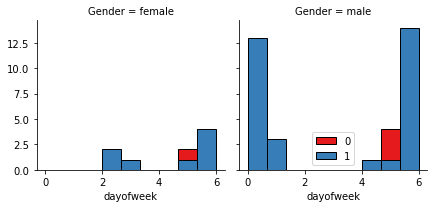

In [122]:
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
bins = np.linspace(test_df.dayofweek.min(), test_df.dayofweek.max(), 10)
g = sns.FacetGrid(test_df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


In [123]:
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df.head()

Unnamed: 0  Unnamed: 0.1  loan_status  Principal  terms effective_date  \
0           1             1            1       1000     30     2016-09-08   
1           5             5            1        300      7     2016-09-09   
2          21            21            1       1000     30     2016-09-10   
3          24            24            1       1000     30     2016-09-10   
4          35            35            1        800     15     2016-09-11   

    due_date  age  education  Gender  dayofweek  weekend  
0 2016-10-07   50          0  female          3        0  
1 2016-09-15   35          2    male          4        1  
2 2016-10-09   43          1  female          5        1  
3 2016-10-09   26          3    male          5        1  
4 2016-09-25   29          0    male          6        1

In [124]:
test_df['effective_date'] = le.fit_transform(test_df['effective_date'])

In [125]:
test_df['due_date'] = le.fit_transform(test_df['due_date'])

In [126]:
test_df['Gender'] = le.fit_transform(test_df['Gender'])

In [127]:
XX_test = test_df.drop(test_df[['Unnamed: 0','Unnamed: 0.1','loan_status']],axis = 1)
y_test_new = test_df['loan_status']

In [128]:
XX_test.shape,y_test_new.shape

((54, 9), (54,))

In [129]:
X_test_sc = sclar.fit_transform(XX_test)

In [130]:
X_test_new = pd.DataFrame(X_test_sc,columns=['Principal','terms','effective_date','due_date','age','education','Gender','dayofweek','weekend'])

In [131]:
X_test_new.shape

(54, 9)

### KNN

In [132]:
#KNeighborsClassifier(algorithm='brute', leaf_size=10, n_neighbors=7)
knn.fit(X_train,y_train)
y_pred_knn_test_new = knn.predict(X_test_new)

In [133]:
print("For Checking on Testing Dataset")
Accuracy_testknn_new=metrics.accuracy_score(y_test_new,y_pred_knn_test_new)
precision_testknn_new=metrics.precision_score(y_test_new,y_pred_knn_test_new)
recall_testknn_new=metrics.recall_score(y_test_new,y_pred_knn_test_new)
f1_score_testknn_new=metrics.f1_score(y_test_new,y_pred_knn_test_new)
roc_auc_testknn_new=metrics.roc_auc_score(y_test_new,y_pred_knn_test_new)
log_lossknn  = metrics.log_loss(y_test_new,y_pred_knn_test_new)
print("Model Name =",'K Nearest Neighbor')
print("Accuracy is ",Accuracy_testknn_new)
print("Precision score is ",precision_testknn_new)
print("Recall _score is",recall_testknn_new)
print("f1 SCore score is ",f1_score_testknn_new)
print("Roc_Auc score is",roc_auc_testknn_new)
print("log_loss is ",log_lossknn)

For Checking on Testing Dataset
Model Name = K Nearest Neighbor
Accuracy is  0.7037037037037037
Precision score is  0.8
Recall _score is 0.8
f1 SCore score is  0.8000000000000002
Roc_Auc score is 0.6142857142857143
log_loss is  10.233829983296529


here Training Accuracy is 79% and Testing Accuracy is 70% with 7 neighbours

### Decision Tree

In [136]:
# Train the model using the training sets 
# DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features='log2', min_samples_split=50, random_state=51, splitter='random')
DTT.fit(X_train,y_train)
y_pred_DTT_test_new = DTT.predict(X_test_new)


In [137]:
Accuracy_testdt_new=metrics.accuracy_score(y_test_new,y_pred_DTT_test_new)
precision_testdt_new=metrics.precision_score(y_test_new,y_pred_DTT_test_new)
recall_testdt_new=metrics.recall_score(y_test_new,y_pred_DTT_test_new)
f1_score_testdt_new=metrics.f1_score(y_test_new,y_pred_DTT_test_new)
roc_auc_testdt_new=metrics.roc_auc_score(y_test_new,y_pred_DTT_test_new)
log_lossDTT  = metrics.log_loss(y_test_new,y_pred_knn_test_new)
print("Model Name =",'Decision Tree')
print("Accuracy is ",Accuracy_testdt_new)
print("Precision score is ",precision_testdt_new)
print("Recall _score is",recall_testdt_new)
print("f1 SCore score is ",f1_score_testdt_new)
print("Roc_Auc score is",roc_auc_testdt_new)
print("log_loss is ",log_lossDTT)

Model Name = Decision Tree
Accuracy is  0.7592592592592593
Precision score is  0.8292682926829268
Recall _score is 0.85
f1 SCore score is  0.8395061728395061
Roc_Auc score is 0.675
log_loss is  10.233829983296529


Here Training Accuracy is 77% and Testing Accuracy is 75% 

### SVC 

In [138]:
#SVC(C=1, class_weight={0: 0.5, 1: 0.5}, gamma=0.001, kernel='linear',probability=True)
svc.fit(X_train,y_train)
y_pred_svc_test_new = svc.predict(X_test_new)



In [139]:
Accuracy_testsvc_new=metrics.accuracy_score(y_test_new,y_pred_svc_test_new)
precision_testsvc_new=metrics.precision_score(y_test_new,y_pred_svc_test_new)
recall_testsvc_new=metrics.recall_score(y_test_new,y_pred_svc_test_new)
f1_score_testsvc_new=metrics.f1_score(y_test_new,y_pred_svc_test_new)
roc_auc_testsvc_new=metrics.roc_auc_score(y_test_new,y_pred_svc_test_new)
log_losssvc  = metrics.log_loss(y_test_new,y_pred_svc_test_new)
print("Model Name =",'Support Vector Machine')
print("Accuracy is ",Accuracy_testsvc_new)
print("Precision score is ",precision_testsvc_new)
print("Recall _score is",recall_testsvc_new)
print("f1 SCore score is ",f1_score_testsvc_new)
print("Roc_Auc score is",roc_auc_testsvc_new)
print("log_loss is ",log_losssvc)

Model Name = Support Vector Machine
Accuracy is  0.7777777777777778
Precision score is  0.8181818181818182
Recall _score is 0.9
f1 SCore score is  0.8571428571428572
Roc_Auc score is 0.6642857142857143
log_loss is  7.675402102192033


Here Training Accuracy is 76% and Testing Accuracy is 77%

### Logistic Regression

In [140]:
#LogisticRegression(C=1, class_weight={0: 0.5, 1: 0.5}, penalty='l1', solver='liblinear')
clf.fit(X_train,y_train)
y_pred_clf_test_new = clf.predict(X_test_new)


In [141]:
Accuracy_testlog_new=metrics.accuracy_score(y_test_new,y_pred_clf_test_new)
precision_testlog_new=metrics.precision_score(y_test_new,y_pred_clf_test_new)
recall_testlog_new=metrics.recall_score(y_test_new,y_pred_clf_test_new)
f1_score_testlog_new=metrics.f1_score(y_test_new,y_pred_clf_test_new)
roc_auc_testlog_new=metrics.roc_auc_score(y_test_new,y_pred_clf_test_new)
log_losslog = metrics.log_loss(y_test_new,y_pred_clf_test_new)
print("Model Name =",'Decision Tree')
print("Accuracy is ",Accuracy_testlog_new)
print("Precision score is ",precision_testlog_new)
print("Recall _score is",recall_testlog_new)
print("f1 SCore score is ",f1_score_testlog_new)
print("Roc_Auc score is",roc_auc_testlog_new)
print("log_loss is ",log_losslog)

Model Name = Decision Tree
Accuracy is  0.7962962962962963
Precision score is  0.8085106382978723
Recall _score is 0.95
f1 SCore score is  0.8735632183908046
Roc_Auc score is 0.6535714285714285
log_loss is  7.035809939275727


Here training Accuracy is 76% and Testing Accuracy is 79% 

# Report

You should be able to report the accuracy of the built model using different evaluation metrics:


| Algorithm          | Jaccard | F1-score | LogLoss |
| ------------------ | ------- | -------- | ------- |
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |


In [143]:
Classifier = ['Knn','Decision Tree','SVM','Logistic Regression']



In [145]:
data = {'Training_Accuracy' : [Accuracy_trainknn,Accuracy_traindt,Accuracy_trainsvc,Accuracy_trainlog],
        'Testing_Accuracy':[Accuracy_testknn_new,Accuracy_testdt_new,Accuracy_testsvc_new,Accuracy_testlog_new],
        'Traing_F1_score':[f1_score_testknn_new,f1_score_testdt_new,f1_score_testsvc_new,f1_score_testlog_new],
        'Log_loss' : [log_lossknn,log_lossDTT,log_losssvc,log_losslog]
}

In [146]:
resultdf = pd.DataFrame(data=data,index=Classifier)

In [147]:
resultdf

Training_Accuracy  Testing_Accuracy  Traing_F1_score  \
Knn                           0.797101          0.703704         0.800000   
Decision Tree                 0.778986          0.759259         0.839506   
SVM                           0.768116          0.777778         0.857143   
Logistic Regression           0.768116          0.796296         0.873563   

                      Log_loss  
Knn                  10.233830  
Decision Tree        10.233830  
SVM                   7.675402  
Logistic Regression   7.035810

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

## Change Log

| Date (YYYY-MM-DD) | Version | Changed By    | Change Description                                                             |
| ----------------- | ------- | ------------- | ------------------------------------------------------------------------------ |
| 2020-10-27        | 2.1     | Lakshmi Holla | Made changes in import statement due to updates in version of  sklearn library |
| 2020-08-27        | 2.0     | Malika Singla | Added lab to GitLab                                                            |

<hr>

## <h3 align="center"> © IBM Corporation 2020. All rights reserved. <h3/>

<p>
